In [101]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import ipywidgets as widgets
import os
import nibabel as nib

def angle_between_vectors_arr(a, b, vec_dim=-1):
    dots = np.sum(a* b, axis=vec_dim)
    norms = np.linalg.norm(a, axis=vec_dim) * np.linalg.norm(b, axis=vec_dim)
    cos_theta = np.clip(dots / norms, -1.0, 1.0)
    theta_rad = np.arccos(cos_theta)        # in radians
    theta_deg = np.degrees(theta_rad)
    theta_deg[theta_deg > 90] = 180 - theta_deg[theta_deg > 90]  # angle between directions, not vectors
    return theta_deg

def angle_between_vectors(a, b):
    a, b = a.flatten(), b.flatten()
    cos_theta = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # numerical safety
    return np.arccos(cos_theta) * 180 / np.pi  # in degrees

def compute_analysis_metrics(vec1_comb, org_vec1):
    n_bs = vec1_comb.shape[-2]
    # Compute average outer product
    M = np.einsum('...i,...j->...ij', vec1_comb, vec1_comb)  # shape (..., n, 3, 3)
    M = M.mean(axis=-3)  # average over the "n" dimension

    eigvals = np.zeros(M.shape[0:-1])
    eigvecs = np.zeros(M.shape)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            for k in range(M.shape[2]):
                if np.any(np.isnan(M[i,j,k,:,:])) or np.any(np.isinf(M[i,j,k,:,:])):
                    continue
                eval, evec = np.linalg.eig(M[i,j,k,:,:])
                idx = np.argsort(eval)[::-1]   # descending order
                eigvals[i,j,k,:] = eval[idx]
                eigvecs[i,j,k,:,:] = evec[:, idx]

    kappa = (1-np.sqrt((eigvals[...,1] + eigvals[...,2]) / (2*eigvals[...,0])))
    kappa[np.isnan(kappa)] = 0

    # Mean orientation is the first eigenvector of the dyadic tensor
    mean_orientations = eigvecs[...,:,0]  # shape (..., 3)
    # calculate angular bias: angle between mean orientation and ground truth
    bias_angle = angle_between_vectors_arr(mean_orientations, org_vec1)
    # calculate angular precision: angle between mean orientation and all bootstrap results and sort that
    precision_angle = angle_between_vectors_arr(mean_orientations[..., np.newaxis,:], vec1_comb)
    sorted_angle = np.sort(precision_angle, axis=-1)
    # take 95th percentile as measure of precision
    confidence_interval = 0.95
    idx_95 = int(np.round(confidence_interval * n_bs)) - 1
    print('95 confidence interval in reality index: ', idx_95)
    angle_95 = sorted_angle[..., idx_95]
    return kappa, bias_angle, angle_95

def plot_unit_sphere_samples(points):
    # Extract x, y, and z coordinates for plotting
    x_points, y_points, z_points = zip(*points)

    # Create a 3D plot for the unit sphere
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sphere surface
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

    # Plot each point on the unit sphere
    ax.scatter(x_points, y_points, z_points, color='red', s=50, label='Samples')

    # Label axes and set the aspect ratio to be equal
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])

    # Show the plot
    plt.legend()
    plt.show()


def run_statistics_on_angles_masked_bs_data(dir, mask, slice_idx=[0]):
    # only angle one is relevant for analysis

    f = h5py.File(dir + r'bootstrap_analysis_PI.h5','r')
    vec1_comb_PI = f['vec1_comb'][:]
    org_vec1 = f['org_vec_2'][:]
    vec2_comb_PI = f['vec2_comb'][:]
    org_vec2 = f['org_vec_2'][:]
    angles_PI = f['angles'][:]
    f.close()

    vec1_comb_PI = vec1_comb_PI[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    org_vec1 = org_vec1[:,:,slice_idx,:]*mask[..., slice_idx, None]
    vec2_comb_PI = vec2_comb_PI[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    org_vec2 = org_vec2[:,:,slice_idx,:]*mask[..., slice_idx, None]
    angles_PI_mask = np.where(mask[..., slice_idx,None, None], angles_PI[:,:,slice_idx,:,:], np.nan)

    angle_1_PI_mask = angles_PI_mask[...,0].flatten()
    angle_1_PI_filtered_mask = angle_1_PI_mask[~np.isnan(angle_1_PI_mask) & ~np.isinf(angle_1_PI_mask)]*180/np.pi
    angle_2_PI_mask = angles_PI_mask[...,1].flatten()
    angle_2_PI_filtered_mask = angle_2_PI_mask[~np.isnan(angle_2_PI_mask) & ~np.isinf(angle_2_PI_mask)]*180/np.pi

    f = h5py.File(dir + r'bootstrap_analysis_MPPCA.h5','r')
    vec1_comb_MPPCA = f['vec1_comb'][:]
    vec2_comb_MPPCA = f['vec2_comb'][:]
    angles_MPPCA = f['angles'][:]
    f.close()

    vec1_comb_MPPCA = vec1_comb_MPPCA[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    vec2_comb_MPPCA = vec2_comb_MPPCA[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    angles_MPPCA_mask = np.where(mask[..., slice_idx,None, None], angles_MPPCA[:,:,slice_idx,:,:], np.nan)

    angle_1_MPPCA_mask = angles_MPPCA_mask[...,0].flatten()
    angle_1_MPPCA_filtered_mask = angle_1_MPPCA_mask[~np.isnan(angle_1_MPPCA_mask) & ~np.isinf(angle_1_MPPCA_mask)]*180/np.pi
    angle_2_MPPCA_mask = angles_MPPCA_mask[...,1].flatten()
    angle_2_MPPCA_filtered_mask = angle_2_MPPCA_mask[~np.isnan(angle_2_MPPCA_mask) & ~np.isinf(angle_2_MPPCA_mask)]*180/np.pi

    f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
    vec1_comb_LLR = f['vec1_comb'][:]
    vec2_comb_LLR = f['vec2_comb'][:]
    angles_LLR = f['angles'][:]
    f.close()

    vec1_comb_LLR = vec1_comb_LLR[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    vec2_comb_LLR = vec2_comb_LLR[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    angles_LLR_mask = np.where(mask[..., slice_idx,None, None], angles_LLR[:,:,slice_idx,:,:], np.nan)

    angle_1_LLR_mask = angles_LLR_mask[...,0].flatten()
    angle_1_LLR_filtered_mask = angle_1_LLR_mask[~np.isnan(angle_1_LLR_mask) & ~np.isinf(angle_1_LLR_mask)]*180/np.pi
    angle_2_LLR_mask = angles_LLR_mask[...,1].flatten()
    angle_2_LLR_filtered_mask = angle_2_LLR_mask[~np.isnan(angle_2_LLR_mask) & ~np.isinf(angle_2_LLR_mask)]*180/np.pi

    f = h5py.File(dir + r'bootstrap_analysis_DTI.h5','r')
    vec1_comb_DTI = f['vec1_comb'][:]
    vec2_comb_DTI = f['vec2_comb'][:]
    angles_DTI = f['angles'][:]
    f.close()

    vec1_comb_DTI = vec1_comb_DTI[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    vec2_comb_DTI = vec2_comb_DTI[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    angles_DTI_mask = np.where(mask[..., slice_idx,None, None], angles_DTI[:,:,slice_idx,:,:], np.nan)

    angle_1_DTI_mask = angles_DTI_mask[...,0].flatten()
    angle_1_DTI_filtered_mask = angle_1_DTI_mask[~np.isnan(angle_1_DTI_mask) & ~np.isinf(angle_1_DTI_mask)]*180/np.pi
    angle_2_DTI_mask = angles_DTI_mask[...,1].flatten()
    angle_2_DTI_filtered_mask = angle_2_DTI_mask[~np.isnan(angle_2_DTI_mask) & ~np.isinf(angle_2_DTI_mask)]*180/np.pi

    f = h5py.File(dir + r'bootstrap_analysis_BAS.h5','r')
    vec1_comb_BAS = f['vec1_comb'][:]
    vec2_comb_BAS = f['vec2_comb'][:]
    angles_BAS = f['angles'][:]
    f.close()

    vec1_comb_BAS = vec1_comb_BAS[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    vec2_comb_BAS = vec2_comb_BAS[:,:,slice_idx,:,:]*mask[..., slice_idx,None, None]
    angles_BAS_mask = np.where(mask[..., slice_idx,None, None], angles_BAS[:,:,slice_idx,:,:], np.nan)

    angle_1_BAS_mask = angles_BAS_mask[...,0].flatten()
    angle_1_BAS_filtered_mask = angle_1_BAS_mask[~np.isnan(angle_1_BAS_mask) & ~np.isinf(angle_1_BAS_mask)]*180/np.pi
    angle_2_BAS_mask = angles_BAS_mask[...,1].flatten()
    angle_2_BAS_filtered_mask = angle_2_BAS_mask[~np.isnan(angle_2_BAS_mask) & ~np.isinf(angle_2_BAS_mask)]*180/np.pi

    # data1 = [angle_1_PI_filtered_mask]
    # data2 = [angle_2_PI_filtered_mask]
    data1 = [angle_1_PI_filtered_mask, angle_1_MPPCA_filtered_mask, angle_1_LLR_filtered_mask, angle_1_DTI_filtered_mask, angle_1_BAS_filtered_mask]
    data2 = [angle_2_PI_filtered_mask, angle_2_MPPCA_filtered_mask, angle_2_LLR_filtered_mask, angle_2_DTI_filtered_mask, angle_2_BAS_filtered_mask]
    return data1, data2


def run_statistics_on_angles_masked_data(data1, data2, mask1, mask2=None):
    # only angle one is relevant for analysis
    if mask2 is None:
        mask2 = mask1

    out1 = []
    for d in data1:
        d_masked = (d*mask1).flatten()
        d_filtered_mask = d_masked[~np.isnan(d_masked) & ~np.isinf(d_masked)]
        out1.append(d_filtered_mask)

    out2 = []
    for d in data2:
        d_masked = (d*mask2).flatten()
        d_filtered_mask = d_masked[~np.isnan(d_masked) & ~np.isinf(d_masked)]
        out2.append(d_filtered_mask)

    
    return out1, out2

def plot_violins(data, dataNames, dataTitles, save_fig=False, save_dir="./", spacing=0.35, bias_or_prec="bias", ylim_max=[90, 90]):
    """
    spacing: horizontal distance between adjacent violins (smaller => closer together).
             Try 0.25–0.40. Adjust widths below if you change spacing.
    """
    import os, numpy as np, matplotlib.pyplot as plt

    num_rows = len(data)
    plot_colors = ["#0050FF", "#FFD200","#FF00A2", "#00C400", "#FF6A00", "#000000", "#00FFFF", "#FFC0CB", "#808080"]

    # x positions packed tightly: start at 1.0 and step by `spacing`
    n = len(dataNames)
    positions = 1.0 + np.arange(n) * spacing
    widths = spacing * 0.9  # slightly less than spacing so neighboring violins nearly touch

    fig, axes = plt.subplots(num_rows, 1, figsize=(3, 3*num_rows), squeeze=False)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        parts = ax.violinplot(
            data[i],
            positions=positions,
            widths=widths,
            showmeans=False,
            showmedians=True,
            showextrema=False
        )

        for l, pc in enumerate(parts['bodies']):
            pc.set_facecolor(plot_colors[l % len(plot_colors)])
            pc.set_edgecolor('black')
            pc.set_alpha(1)

        ax.set_xticks(positions)
        ax.set_xticklabels(dataNames, rotation=0)  # rotate if labels start colliding
        if i > 1:
            ax.axhline(0, color='red', linestyle='--', linewidth=2, label="GT value")
        ax.set_title(dataTitles[i])
        ax.set_ylabel("Values")

        # Optional: tighten x-limits so there isn't extra padding
        pad = spacing * 0.7
        ax.set_xlim(positions[0] - pad, positions[-1] + pad)
        ax.set_ylim(0, ylim_max[i])
        from matplotlib.ticker import MultipleLocator, FormatStrFormatter
        ax.yaxis.set_major_locator(MultipleLocator(10))        # ticks every 10
        ax.yaxis.set_major_formatter(FormatStrFormatter('%d')) # force integer formatting

        # --- Save each subplot (row) separately as a PDF ---
        if save_fig:
            os.makedirs(save_dir, exist_ok=True)
            subfig = plt.figure(figsize=(3, 3))
            sub_ax = subfig.add_subplot(111)
            parts_sub = sub_ax.violinplot(
                data[i],
                positions=positions,
                widths=widths,
                showmeans=False,
                showmedians=True,
                showextrema=False
            )
            for l, pc in enumerate(parts_sub['bodies']):
                pc.set_facecolor(plot_colors[l % len(plot_colors)])
                pc.set_edgecolor('black')
                pc.set_alpha(1)
            sub_ax.set_xticks(positions)
            sub_ax.set_xticklabels(dataNames)
            if i > 1:
                sub_ax.axhline(0, color='red', linestyle='--', linewidth=2)
            sub_ax.set_title(dataTitles[i])
            sub_ax.set_ylabel("Values")
            sub_ax.set_xlim(positions[0] - pad, positions[-1] + pad)
            sub_ax.set_ylim(0, ylim_max[i])
            from matplotlib.ticker import MultipleLocator, FormatStrFormatter
            sub_ax.yaxis.set_major_locator(MultipleLocator(10))        # ticks every 10
            sub_ax.yaxis.set_major_formatter(FormatStrFormatter('%d')) # force integer formatting

            filename = os.path.join(save_dir, f"violin_{bias_or_prec}_{dataTitles[i].replace(' ', '_')}.pdf")
            subfig.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close(subfig)

    plt.tight_layout()
    plt.show()




def plot_boxplots(data, dataNames, dataTitles, save_figs=False, save_dir="./"):
    num_cols = len(data)
    fig, axes = plt.subplots(1, num_cols, figsize=(12, 5))
    if num_cols > 1:
        axes = axes.flatten()
    if num_cols == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        # ax.boxplot(data[i], tick_labels=["PI"])
        ax.boxplot(data[i], tick_labels=dataNames)
        if i > 1:
            hline = 0
            ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
        ax.set_title(dataTitles[i])
        ax.set_ylabel("Values")

        # --- save each subplot (column) separately as a PDF ---
        if save_figs:
            os.makedirs(save_dir, exist_ok=True)
            subfig = plt.figure(figsize=(5, 5))
            sub_ax = subfig.add_subplot(111)

            # re-plot same data on its own figure for saving
            sub_ax.boxplot(data[i], tick_labels=dataNames)
            if i > 1:
                sub_ax.axhline(0, color='red', linestyle='--', linewidth=2, label=f"GT value")
            sub_ax.set_title(dataTitles[i])
            sub_ax.set_ylabel("Values")

            filename = os.path.join(save_dir, f"box_col_{i+1}_{dataTitles[i].replace(' ', '_')}.pdf")
            subfig.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close(subfig)
            print(f"Saved: {filename}")


    plt.tight_layout()
    plt.show()

def print_stats(name, dataNames, data):
    
    for l in range(len(data)):
        print(f'1st quartile, Median, 3rd quartile of angle {l+1} in {name}:')
        for i, method in enumerate(dataNames):
        # for i, method in enumerate(['PI']):
            quartile_1 = np.percentile(data[l][i], 25)
            quartile_3 = np.percentile(data[l][i], 75)
            median = np.median(data[l][i])
            mean = np.mean(data[l][i])
            std = np.std(data[l][i])
            precentile_90 = np.percentile(data[l][i], 90)
            print(f"{method}:\t\t 1st quartile = {quartile_1:.0f}, \t Median = {median:.0f},\t 3rd quartile = {quartile_3:.0f}")
        print('\n\n')


# Create mask for one fiber and two fibers

In [37]:
index_f = nib.load(r'C:\msys64\home\glaserjs\bootstrap_analysis_1_fod\0\fixel_masks_all_new\index.nii')
index_data = index_f.get_fdata()
mask_1_plus_fiber = (index_data[:,:,:,0] > 0).astype(bool)
mask_2_fiber = (index_data[:,:,:,0] > 1).astype(bool)

(-0.5, 109.5, 109.5, -0.5)

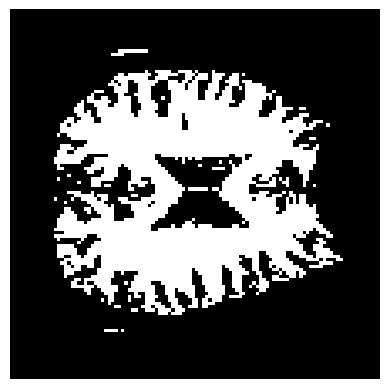

In [38]:
plt.imshow(mask_1_plus_fiber[:,:,11], cmap='gray')
plt.axis('off')

(-0.5, 109.5, 109.5, -0.5)

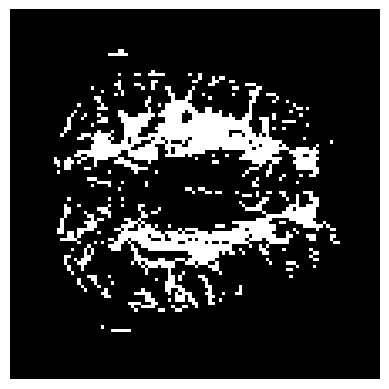

In [39]:
plt.imshow(mask_2_fiber[:,:,12], cmap='gray')
plt.axis('off')

# Violinplots

In [130]:
dir = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\bootstraps_1000_slice_12_PF' + os.sep

In [131]:
# LLR
f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
print(f.keys())
angles_PI = f['angles'][:]
f.close()
angle_1_PI = np.where(mask_1_plus_fiber[...,None], angles_PI[...,0], np.nan).flatten()

angle_1_PI_filtered = angle_1_PI[~np.isnan(angle_1_PI) & ~np.isinf(angle_1_PI)]*180/np.pi
angle_2_PI = np.where(mask_2_fiber[...,None], angles_PI[...,1], np.nan).flatten()
angle_2_PI_filtered = angle_2_PI[~np.isnan(angle_2_PI) & ~np.isinf(angle_2_PI)]*180/np.pi

# MPPCA
f = h5py.File(dir + r'bootstrap_analysis_MPPCA.h5','r')
print(f.keys())
angles_MPPCA = f['angles'][:]
f.close()
angle_1_MPPCA = np.where(mask_1_plus_fiber[...,None], angles_MPPCA[...,0], np.nan).flatten()
angle_1_MPPCA_filtered = angle_1_MPPCA[~np.isnan(angle_1_MPPCA) & ~np.isinf(angle_1_MPPCA)]*180/np.pi
angle_2_MPPCA = np.where(mask_2_fiber[...,None], angles_MPPCA[...,1], np.nan).flatten()
angle_2_MPPCA_filtered = angle_2_MPPCA[~np.isnan(angle_2_MPPCA) & ~np.isinf(angle_2_MPPCA)]*180/np.pi

# LLR
f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
print(f.keys())
angles_LLR = f['angles'][:]
f.close()
angle_1_LLR = np.where(mask_1_plus_fiber[...,None], angles_LLR[...,0], np.nan).flatten()
angle_1_LLR_filtered = angle_1_LLR[~np.isnan(angle_1_LLR) & ~np.isinf(angle_1_LLR)]*180/np.pi
angle_2_LLR = np.where(mask_2_fiber[...,None], angles_LLR[...,1], np.nan).flatten()
angle_2_LLR_filtered = angle_2_LLR[~np.isnan(angle_2_LLR) & ~np.isinf(angle_2_LLR)]*180/np.pi

# DTI
f = h5py.File(dir + r'bootstrap_analysis_DTI.h5','r')
print(f.keys())
angles_DTI = f['angles'][:]
f.close()
angle_1_DTI = np.where(mask_1_plus_fiber[...,None], angles_DTI[...,0], np.nan).flatten()
angle_1_DTI_filtered = angle_1_DTI[~np.isnan(angle_1_DTI) & ~np.isinf(angle_1_DTI)]*180/np.pi
angle_2_DTI = np.where(mask_2_fiber[...,None], angles_DTI[...,1], np.nan).flatten()
angle_2_DTI_filtered = angle_2_DTI[~np.isnan(angle_2_DTI) & ~np.isinf(angle_2_DTI)]*180/np.pi

# BAS
f = h5py.File(dir + r'bootstrap_analysis_BAS.h5','r')
print(f.keys())
angles_BAS = f['angles'][:]
f.close()
angle_1_BAS = np.where(mask_1_plus_fiber[...,None], angles_BAS[...,0], np.nan).flatten()
angle_1_BAS_filtered = angle_1_BAS[~np.isnan(angle_1_BAS) & ~np.isinf(angle_1_BAS)]*180/np.pi
angle_2_BAS = np.where(mask_2_fiber[...,None], angles_BAS[...,1], np.nan).flatten()
angle_2_BAS_filtered = angle_2_BAS[~np.isnan(angle_2_BAS) & ~np.isinf(angle_2_BAS)]*180/np.pi

<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>


In [132]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    #
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [133]:
print('Number of primary fits')
print('angle_1_PI_filtered shape: ',angle_1_PI_filtered.shape)
print('angle_1_MPPCA_filtered shape: ',angle_1_MPPCA_filtered.shape)
print('angle_1_LLR_filtered shape: ',angle_1_LLR_filtered.shape)
print('angle_1_BAS_filtered shape: ',angle_1_BAS_filtered.shape)
print('angle_1_DTI_filtered shape: ',angle_1_DTI_filtered.shape)

print('Number of secondary fits')
print('angle_2_PI_filtered shape: ',angle_2_PI_filtered.shape)
print('angle_2_MPPCA_filtered shape: ',angle_2_MPPCA_filtered.shape)
print('angle_2_LLR_filtered shape: ',angle_2_LLR_filtered.shape)
print('angle_2_BAS_filtered shape: ',angle_2_BAS_filtered.shape)
print('angle_2_DTI_filtered shape: ',angle_2_DTI_filtered.shape)


Number of primary fits
angle_1_PI_filtered shape:  (3421000,)
angle_1_MPPCA_filtered shape:  (3421000,)
angle_1_LLR_filtered shape:  (3421000,)
angle_1_BAS_filtered shape:  (3421000,)
angle_1_DTI_filtered shape:  (3421000,)
Number of secondary fits
angle_2_PI_filtered shape:  (1202000,)
angle_2_MPPCA_filtered shape:  (1202000,)
angle_2_LLR_filtered shape:  (1202000,)
angle_2_BAS_filtered shape:  (1201999,)
angle_2_DTI_filtered shape:  (1201999,)


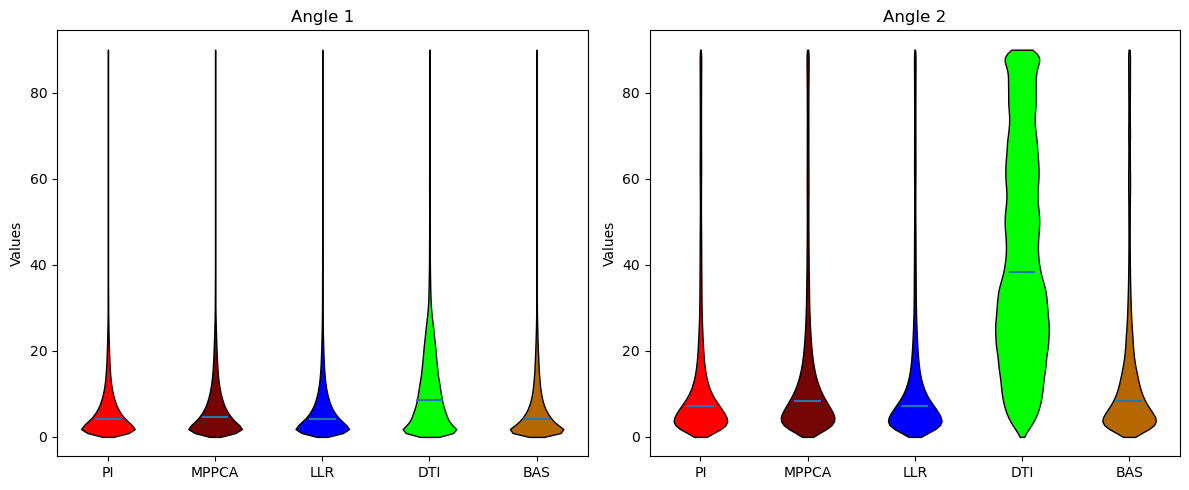

In [134]:
angles1 = [angle_1_PI_filtered , angle_1_MPPCA_filtered, angle_1_LLR_filtered , angle_1_DTI_filtered , angle_1_BAS_filtered ]  # flatten to 1D
angles2 = [angle_2_PI_filtered , angle_2_MPPCA_filtered, angle_2_LLR_filtered , angle_2_DTI_filtered , angle_2_BAS_filtered ]  # flatten to 1D

data = [angles1, angles2]
dataNames = ["Angle 1", "Angle 2"]
plot_colors = ["#FF0000", "#750404","#0000FF", "#00FF00", "#B66700"]
# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True, showextrema=False)

    for l, pc in enumerate(parts['bodies']):
        pc.set_facecolor(plot_colors[l])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # quartile1, medians, quartile3 = np.percentile(data[i], [25, 50, 75], axis=1)
    # whiskers = np.array([
    #     adjacent_values(sorted_array, q1, q3)
    #     for sorted_array, q1, q3 in zip(data[i], quartile1, quartile3)])
    # whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    # inds = np.arange(1, len(medians)+1)
    # ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    # ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    # ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    # ax.axhline(7)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(["PI", "MPPCA", "LLR", "DTI", "BAS"])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()


# Boxplots

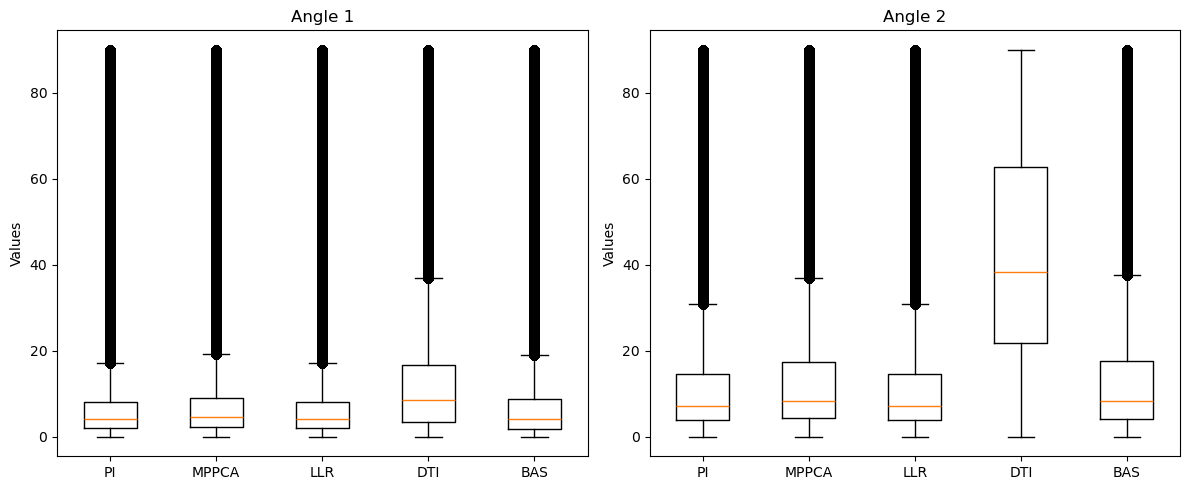

In [135]:

# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.boxplot(data[i], tick_labels=["PI", "MPPCA", "LLR", "DTI", "BAS"])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()


# Plot maps with angle error

In [10]:
# PI
f = h5py.File(dir + r'bootstrap_analysis_PI.h5', 'r')
print(f.keys())
bs_angles_pi = f['angles'][:]*180/np.pi
bs_angles_pi[np.isinf(bs_angles_pi)] = np.nan
f.close()

print(bs_angles_pi.shape)
n_rows = bs_angles_pi.shape[0]
n_cols = bs_angles_pi.shape[1]
n_bs = bs_angles_pi.shape[3]

vmax_angle_1 = np.nanpercentile(bs_angles_pi[...,0], 99)
vmax_angle_2 = np.nanpercentile(bs_angles_pi[...,1], 99)
# bs_angles_pi[np.isnan(bs_angles_pi)] = 0
bs_angles_pi_1_map = np.where(mask_1_plus_fiber[...,None], bs_angles_pi[...,0], np.nan)
bs_angles_pi_2_map = np.where(mask_2_fiber[...,None], bs_angles_pi[...,1], np.nan)

# MPPCA
f = h5py.File(dir + r'bootstrap_analysis_MPPCA.h5', 'r')
print(f.keys())
bs_angles_mppca = f['angles'][:]*180/np.pi
bs_angles_mppca[np.isinf(bs_angles_mppca)] = np.nan
f.close()
bs_angles_mppca_1_map = np.where(mask_1_plus_fiber[...,None], bs_angles_mppca[...,0], np.nan)
bs_angles_mppca_2_map = np.where(mask_2_fiber[...,None], bs_angles_mppca[...,1], np.nan)

# DTI
f = h5py.File(dir + r'bootstrap_analysis_DTI.h5', 'r')
bs_angles_dti = f['angles'][:]*180/np.pi
bs_angles_dti[np.isinf(bs_angles_dti)] = np.nan
f.close()
bs_angles_dti_1_map = np.where(mask_1_plus_fiber[...,None], bs_angles_dti[...,0], np.nan)
bs_angles_dti_2_map = np.where(mask_2_fiber[...,None], bs_angles_dti[...,1], np.nan)

# BAS
f = h5py.File(dir + r'bootstrap_analysis_BAS.h5', 'r')
bs_angles_bas = f['angles'][:]*180/np.pi
bs_angles_bas[np.isinf(bs_angles_bas)] = np.nan
f.close()
bs_angles_bas_1_map = np.where(mask_1_plus_fiber[...,None], bs_angles_bas[...,0], np.nan)
bs_angles_bas_2_map = np.where(mask_2_fiber[...,None], bs_angles_bas[...,1], np.nan)

# LLR
f = h5py.File(dir + r'bootstrap_analysis_LLR.h5', 'r')
bs_angles_llr = f['angles'][:]*180/np.pi
bs_angles_llr[np.isinf(bs_angles_llr)] = np.nan
f.close()
bs_angles_llr_1_map = np.where(mask_1_plus_fiber[...,None], bs_angles_llr[...,0], np.nan)
bs_angles_llr_2_map = np.where(mask_2_fiber[...,None], bs_angles_llr[...,1], np.nan)



<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
(110, 110, 1, 100, 2)
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>


What are the values along the bootstraps?

For vae we need to calculate the var and filter nan (no second fiber fitted) values

In [11]:
import warnings
warnings.filterwarnings("ignore", message="Degrees of freedom")

var_along_bs_pi_1 = np.nanvar(bs_angles_pi_1_map, axis=-1)
var_along_bs_pi_2 = np.nanvar(bs_angles_pi_2_map, axis=-1)
# var_along_bs_pi_2[np.isnan(var_along_bs_pi_2)] = 0

var_along_bs_dti_1 = np.nanvar(bs_angles_dti_1_map, axis=-1)
var_along_bs_dti_2 = np.nanvar(bs_angles_dti_2_map, axis=-1)
# var_along_bs_dti_2[np.isnan(var_along_bs_dti_2)] = 0

var_along_bs_bas_1 = np.nanvar(bs_angles_bas_1_map, axis=-1)
var_along_bs_bas_2 = np.nanvar(bs_angles_bas_2_map, axis=-1)
# var_along_bs_bas_2[np.isnan(var_along_bs_bas_2)] = 0

var_along_bs_llr_1 = np.nanvar(bs_angles_llr_1_map, axis=-1)
var_along_bs_llr_2 = np.nanvar(bs_angles_llr_2_map, axis=-1)
# var_along_bs_llr_2[np.isnan(var_along_bs_llr_2)] = 0

var_along_bs_mppca_1 = np.nanvar(bs_angles_mppca_1_map, axis=-1)
var_along_bs_mppca_2 = np.nanvar(bs_angles_mppca_2_map, axis=-1)


For mean we need to calculate the mean and filter out every entry which is over 10000 (masked) or nan (no second fiber fitted)

In [12]:

import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

mean_along_bs_pi_1 = np.nanmean(bs_angles_pi_1_map, axis=-1)
mean_along_bs_pi_2 = np.nanmean(bs_angles_pi_2_map, axis=-1)

mean_along_bs_dti_1 = np.nanmean(bs_angles_dti_1_map, axis=-1)
mean_along_bs_dti_2 = np.nanmean(bs_angles_dti_2_map, axis=-1)

mean_along_bs_bas_1 = np.nanmean(bs_angles_bas_1_map, axis=-1)
mean_along_bs_bas_2 = np.nanmean(bs_angles_bas_2_map, axis=-1)

mean_along_bs_llr_1 = np.nanmean(bs_angles_llr_1_map, axis=-1)
mean_along_bs_llr_2 = np.nanmean(bs_angles_llr_2_map, axis=-1)

mean_along_bs_mppca_1 = np.nanmean(bs_angles_mppca_1_map, axis=-1)
mean_along_bs_mppca_2 = np.nanmean(bs_angles_mppca_2_map, axis=-1)

In [13]:

rows = 3
cols = 3
N_diff=126
N_z = 5
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10))
    plt.subplot(2, 5, 1)
    plt.title('PI Angle 1 mean over bootstrap')
    plt.imshow(mean_along_bs_pi_1[:,:,n_slice], cmap='hot', vmax=vmax_angle_1)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA Angle 1 mean over bootstrap')
    plt.imshow(mean_along_bs_mppca_1[:,:,n_slice], cmap='hot', vmax=vmax_angle_1)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR Angle 1 mean over bootstrap')
    plt.imshow(mean_along_bs_llr_1[:,:,n_slice], cmap='hot', vmax=vmax_angle_1)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS Angle 1 mean over bootstrap')
    plt.imshow(mean_along_bs_bas_1[:,:,n_slice], cmap='hot', vmax=vmax_angle_1)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI Angle 1 mean over bootstrap')
    im=plt.imshow(mean_along_bs_dti_1[:,:,n_slice], cmap='hot', vmax=vmax_angle_1)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(2, 5, 6)
    plt.title('PI Angle 2 mean over bootstrap')
    plt.imshow(mean_along_bs_pi_2[:,:,n_slice], cmap='hot', vmax=vmax_angle_2)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA Angle 2 mean over bootstrap')
    plt.imshow(mean_along_bs_mppca_2[:,:,n_slice], cmap='hot', vmax=vmax_angle_2)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR Angle 2 mean over bootstrap')
    plt.imshow(mean_along_bs_llr_2[:,:,n_slice], cmap='hot', vmax=vmax_angle_2)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS Angle 2 mean over bootstrap')
    plt.imshow(mean_along_bs_bas_2[:,:,n_slice], cmap='hot', vmax=vmax_angle_2)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI Angle 2 mean over bootstrap')
    im2=plt.imshow(mean_along_bs_dti_2[:,:,n_slice], cmap='hot', vmax=vmax_angle_2)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=4), Output()), _dom_classes=('widget-inter…

In [14]:
rows = 3
cols = 3
N_diff=126
N_z = 5
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10))
    vmax1 = np.nanpercentile(var_along_bs_pi_1, 99)
    vmax2 = np.nanpercentile(var_along_bs_pi_2, 99)

    plt.subplot(2, 5, 1)
    plt.title('PI Angle 1 variance')
    plt.imshow(var_along_bs_pi_1[:,:,n_slice], cmap='hot', vmax=vmax1)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA Angle 1 variance')
    plt.imshow(var_along_bs_mppca_1[:,:,n_slice], cmap='hot', vmax=vmax1)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR Angle 1 variance')
    plt.imshow(var_along_bs_llr_1[:,:,n_slice], cmap='hot', vmax=vmax1)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS Angle 1 variance')
    plt.imshow(var_along_bs_bas_1[:,:,n_slice], cmap='hot', vmax=vmax1)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI Angle 1 variance')
    im=plt.imshow(var_along_bs_dti_1[:,:,n_slice], cmap='hot', vmax=vmax1)
    plt.axis('off')
    plt.colorbar(im, label="Intensity")

    plt.subplot(2, 5, 6)
    plt.title('PI Angle 2 variance')
    plt.imshow(var_along_bs_pi_2[:,:,n_slice], cmap='hot', vmax=vmax2)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA Angle 2 variance')
    plt.imshow(var_along_bs_mppca_2[:,:,n_slice], cmap='hot', vmax=vmax2)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR Angle 2 variance')
    plt.imshow(var_along_bs_llr_2[:,:,n_slice], cmap='hot', vmax=vmax2)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS Angle 2 variance')
    plt.imshow(var_along_bs_bas_2[:,:,n_slice], cmap='hot', vmax=vmax2)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI Angle 2 variance')
    im2 = plt.imshow(var_along_bs_dti_2[:,:,n_slice], cmap='hot', vmax=vmax2)
    plt.axis('off')
    plt.colorbar(im2, label="Intensity")


interactive(children=(IntSlider(value=0, description='n_slice', max=4), Output()), _dom_classes=('widget-inter…

# Dyadic tensor metrics computations

In [6]:
dir = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\BS_analysis_slice_all_1000' + os.sep

In [7]:
f = h5py.File(dir + r'bootstrap_analysis_DAE_BAS_splitted_reco_latent_smooth.h5','r')
print(f.keys())
vec1_comb_PI = f['vec1_comb'][:]
org_vec1 = f['org_vec_1'][:]
vec2_comb_PI = f['vec2_comb'][:]
org_vec2 = f['org_vec_2'][:]
f.close()
kappa_1_PI, bias_angle_1_PI, angle_95_1_PI = compute_analysis_metrics(vec1_comb_PI, org_vec1)
kappa_2_PI, bias_angle_2_PI, angle_95_2_PI = compute_analysis_metrics(vec2_comb_PI, org_vec2)

# f = h5py.File(dir + r'bootstrap_analysis_MPPCA.h5','r')
# vec1_comb_MPPCA = f['vec1_comb'][:]
# vec2_comb_MPPCA = f['vec2_comb'][:]
# f.close()
# kappa_1_MPPCA, bias_angle_1_MPPCA, angle_95_1_MPPCA = compute_analysis_metrics(vec1_comb_MPPCA, org_vec1)
# kappa_2_MPPCA, bias_angle_2_MPPCA, angle_95_2_MPPCA = compute_analysis_metrics(vec2_comb_MPPCA, org_vec2)



# f = h5py.File(dir + r'bootstrap_analysis_DTI.h5','r')
# vec1_comb_DTI = f['vec1_comb'][:]
# vec2_comb_DTI = f['vec2_comb'][:]
# f.close()
# kappa_1_DTI, bias_angle_1_DTI, angle_95_1_DTI = compute_analysis_metrics(vec1_comb_DTI, org_vec1)
# kappa_2_DTI, bias_angle_2_DTI, angle_95_2_DTI = compute_analysis_metrics(vec2_comb_DTI, org_vec2)

# f = h5py.File(dir + r'bootstrap_analysis_BAS.h5','r')
# vec1_comb_BAS = f['vec1_comb'][:]
# vec2_comb_BAS = f['vec2_comb'][:]
# f.close()
# kappa_1_BAS, bias_angle_1_BAS, angle_95_1_BAS = compute_analysis_metrics(vec1_comb_BAS, org_vec1)
# kappa_2_BAS, bias_angle_2_BAS, angle_95_2_BAS = compute_analysis_metrics(vec2_comb_BAS, org_vec2)

# f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
# vec1_comb_LLR = f['vec1_comb'][:]
# vec2_comb_LLR = f['vec2_comb'][:]
# f.close()
# kappa_1_LLR, bias_angle_1_LLR, angle_95_1_LLR = compute_analysis_metrics(vec1_comb_LLR, org_vec1)
# kappa_2_LLR, bias_angle_2_LLR, angle_95_2_LLR = compute_analysis_metrics(vec2_comb_LLR, org_vec2)

<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>


C:\Users\glaserjs\AppData\Local\Temp\ipykernel_33328\1077085997.py:42: RuntimeWarning: invalid value encountered in divide
  kappa = (1-np.sqrt((eigvals[...,1] + eigvals[...,2]) / (2*eigvals[...,0])))
C:\Users\glaserjs\AppData\Local\Temp\ipykernel_33328\1077085997.py:11: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dots / norms, -1.0, 1.0)


95 confidence interval in reality index:  94
95 confidence interval in reality index:  94


In [8]:
f = h5py.File(dir + r'\results\DAE_BAS_splitted_reco_latent_smooth_bias_prec_all_slices.h5','w')
f.create_dataset('Kappa_1', data=kappa_1_PI)
f.create_dataset('Kappa_2', data=kappa_2_PI)
f.create_dataset('Bias_1', data=bias_angle_1_PI)
f.create_dataset('Bias_2', data=bias_angle_2_PI)
f.create_dataset('Prec_1', data=angle_95_1_PI)
f.create_dataset('Prec_2', data=angle_95_2_PI)
f.close()

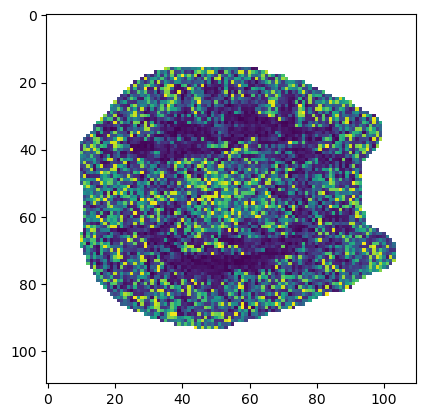

In [194]:
plt.imshow(bias_angle_2_PI[:,:,11])

# Look at angular Bias

In [137]:
mask_1_plus_fiber_float = mask_1_plus_fiber.copy().astype(float)
mask_2_fiber_float = mask_2_fiber.copy().astype(float)

mask_1_plus_fiber_float[~mask_1_plus_fiber] = np.nan
mask_2_fiber_float[~mask_2_fiber] = np.nan

In [139]:
from matplotlib.colors import LogNorm
rows = 3
cols = 3
N_diff=126
N_z = 1
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax_angle_1 = vmax_angle_2 = 90
cmap = 'viridis'


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10), dpi=500)
    plt.subplot(2, 5, 1)
    plt.title('PI Angle 1 bias')
    plt.imshow(bias_angle_1_PI[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA Angle 1 bias')
    plt.imshow(bias_angle_1_MPPCA[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR Angle 1 bias')
    plt.imshow(bias_angle_1_LLR[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS Angle 1 bias')
    plt.imshow(bias_angle_1_BAS[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI Angle 1 bias')
    im=plt.imshow(bias_angle_1_DTI[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(2, 5, 6)
    plt.title('PI Angle 2 bias')
    plt.imshow(bias_angle_2_PI[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA Angle 2 bias')
    plt.imshow(bias_angle_2_MPPCA[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR Angle 2 bias')
    plt.imshow(bias_angle_2_LLR[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS Angle 2 bias')
    plt.imshow(bias_angle_2_BAS[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI Angle 2 bias')
    im2=plt.imshow(bias_angle_2_DTI[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=0), Output()), _dom_classes=('widget-inter…

# Uncertainty

In [141]:

rows = 3
cols = 3
N_diff=126
N_z = 1
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax_angle_1 = vmax_angle_2 = 90


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10), dpi=500)
    plt.subplot(2, 5, 1)
    plt.title('PI Angle 1 95th best')
    plt.imshow(angle_95_1_PI[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA Angle 1 95th best')
    plt.imshow(angle_95_1_MPPCA[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR Angle 1 95th best')
    plt.imshow(angle_95_1_LLR[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS Angle 1 95th best')
    plt.imshow(angle_95_1_BAS[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI Angle 1 95th best')
    im=plt.imshow(angle_95_1_DTI[:,:,n_slice]*mask_1_plus_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(2, 5, 6)
    plt.title('PI Angle 2 95th best')
    plt.imshow(angle_95_2_PI[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA Angle 2 95th best')
    plt.imshow(angle_95_2_MPPCA[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR Angle 2 95th best')
    plt.imshow(angle_95_2_LLR[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS Angle 2 95th best')
    plt.imshow(angle_95_2_BAS[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI Angle 2 95th best')
    im2=plt.imshow(angle_95_2_DTI[:,:,n_slice]*mask_2_fiber_float[...,0], vmin=0, vmax=45, cmap=cmap)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=0), Output()), _dom_classes=('widget-inter…

# Coherence maps

In [58]:

rows = 3
cols = 3
N_diff=126
N_z = 1
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
kappa_max = 1
kappa_min = 0


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10))
    plt.subplot(2, 5, 1)
    plt.title('PI coherence 1')
    plt.imshow(kappa_1_PI[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA coherence 1')
    plt.imshow(kappa_1_MPPCA[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR coherence 1')
    plt.imshow(kappa_1_LLR[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS coherence 1')
    plt.imshow(kappa_1_BAS[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI coherence 1')
    im=plt.imshow(kappa_1_DTI[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(2, 5, 6)
    plt.title('PI coherence 2')
    plt.imshow(kappa_2_PI[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA coherence 2')
    plt.imshow(kappa_2_MPPCA[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR coherence 2')
    plt.imshow(kappa_2_LLR[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS coherence 2')
    plt.imshow(kappa_2_BAS[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI coherence 2')
    im2=plt.imshow(kappa_2_DTI[:,:,n_slice], cmap='hot', vmax=kappa_max, vmin=kappa_min)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=0), Output()), _dom_classes=('widget-inter…

# Analyzing masks

In [142]:
mask_dir = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\Analyzing_masks' + os.sep

mask_CC_f = nib.load(mask_dir + r'CC_s12.nii')
CC = mask_CC_f.get_fdata().astype(bool)

crossing_at_bottom_s12_f = nib.load(mask_dir + r'crossing_at_bottom_s12.nii')
BCS = crossing_at_bottom_s12_f.get_fdata().astype(bool)                         #BSC = Bottom crossing section

crossing_at_CC_s12_f = nib.load(mask_dir + r'Crossing_at_CC_s12.nii')
CCCS = crossing_at_CC_s12_f.get_fdata().astype(bool)                              #CCCS = Crossing at CC section

crossing_x_z_plane_s12_f  = nib.load(mask_dir + r'crossing_x_z_plane_s12.nii')
CXZP = crossing_x_z_plane_s12_f.get_fdata().astype(bool)                            #CXZP = Crossing in x-z plane

crossing_s12_f = nib.load(mask_dir + r'crossing_s12.nii')
CSR = crossing_s12_f.get_fdata().astype(bool)                                        #CSR = Crossing section right side

crossing_x_z_plane_s12_right_side_f = nib.load(mask_dir + r'Crossing_x_z_plane_s12_right_side.nii')
CXZPRS = crossing_x_z_plane_s12_right_side_f.get_fdata().astype(bool)                                        #CSR = Crossing section right side

(-0.5, 109.5, 109.5, -0.5)

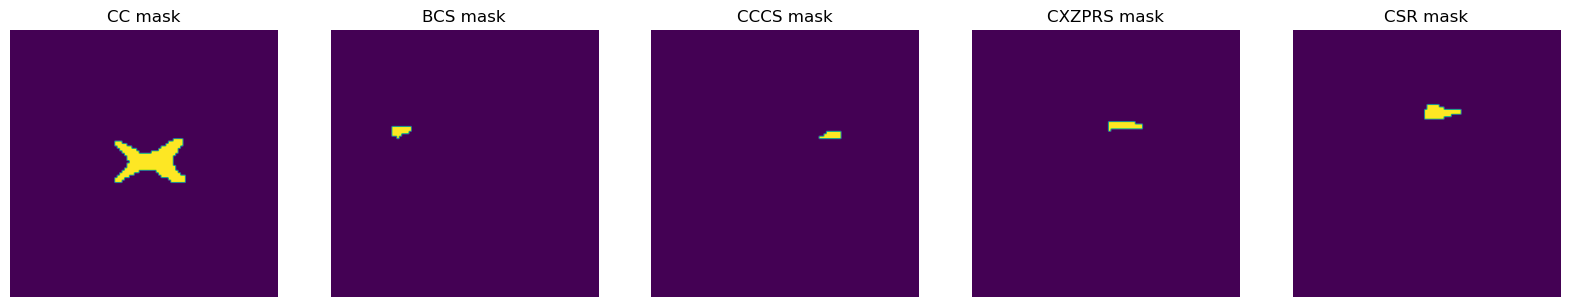

In [143]:
plt.subplots(1, 5, figsize=(20,20))

plt.subplot(1, 5, 1)
plt.imshow(CC[:,:,0])
plt.title('CC mask')
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(BCS[:,:,0])
plt.title('BCS mask')
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(CCCS[:,:,0])
plt.title('CCCS mask')
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(CXZPRS[:,:,0])
plt.title('CXZPRS mask')
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(CSR[:,:,0])
plt.title('CSR mask')
plt.axis('off')

# CC

In [144]:
angles1_CC, angles2_CC = run_statistics_on_angles_masked(dir, CC)
data = [angles1_CC]
dataNames = ["Angle 1"]

## Violinplots

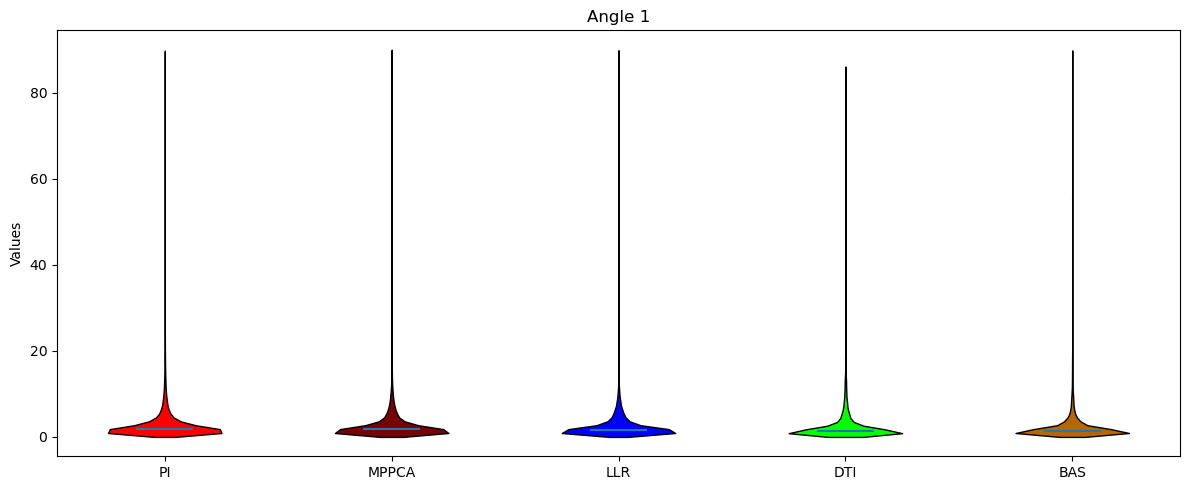

In [145]:
plot_violins(data, dataNames)

In [146]:
print('Median, mean, std of angle 1 in CC mask:')
for i, method in enumerate(['PI', 'MPPCA', 'LLR', 'DTI', 'BAS']):
    median = np.median(data[0][i])
    mean = np.mean(data[0][i])
    std = np.std(data[0][i])
    print(f"{method}: Median = {median:.2f}, Mean = {mean:.2f}, Std = {std:.2f}")

Median, mean, std of angle 1 in CC mask:
PI: Median = 1.85, Mean = 2.72, Std = 3.65
MPPCA: Median = 1.74, Mean = 2.60, Std = 3.89
LLR: Median = 1.67, Mean = 2.48, Std = 3.28
DTI: Median = 1.40, Mean = 2.55, Std = 4.93
BAS: Median = 1.42, Mean = 2.24, Std = 3.66


## Boxplots

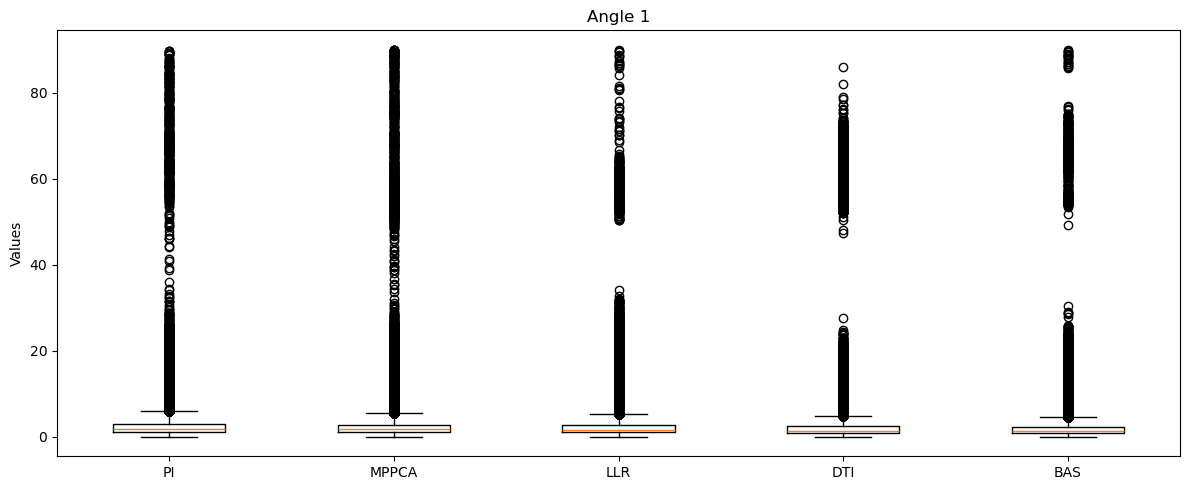

In [147]:
plot_boxplots(data, dataNames)

# BCS

In [148]:
angles1_BCS, angles2_BCS = run_statistics_on_angles_masked(dir, BCS)
data = [angles1_BCS, angles2_BCS]
dataNames = ["Angle 1", "Angle 2"]

## Violinplots

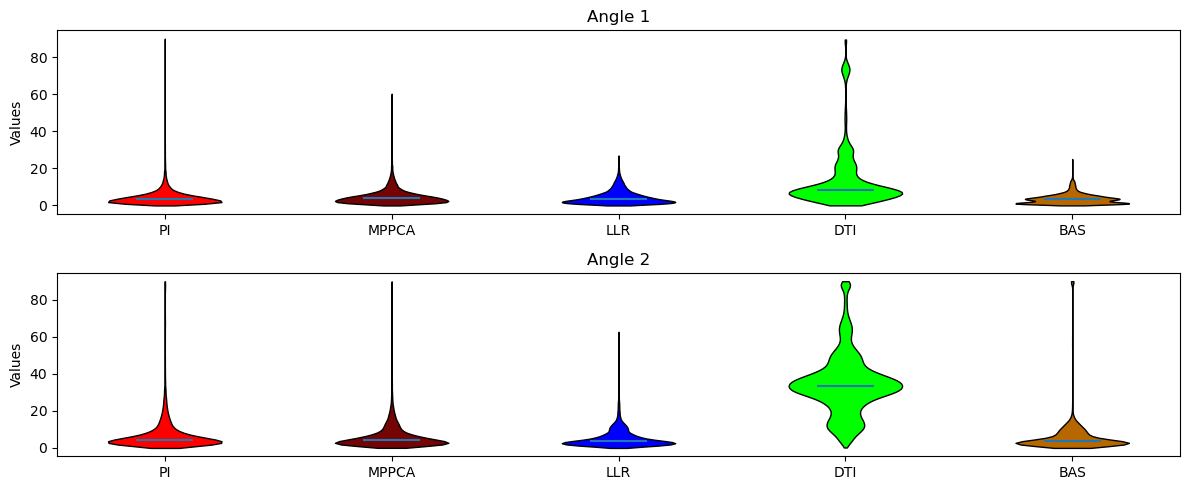

In [149]:
plot_violins(data, dataNames)

## Boxplots

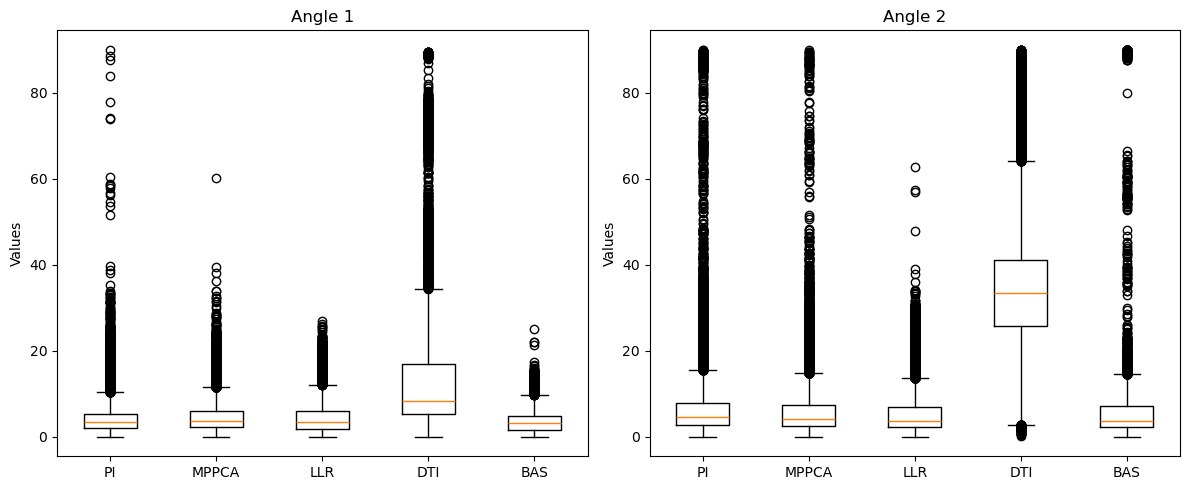

In [150]:
plot_boxplots(data, dataNames)

## Statistics

In [151]:
print_stats('BCS mask', data)

Median, mean, std of angle 1 in BCS mask:
PI:	 Median = 3.37, 	 Mean = 4.26,	 Std = 3.83
MPPCA:	 Median = 3.75, 	 Mean = 4.68,	 Std = 3.68
LLR:	 Median = 3.37, 	 Mean = 4.48,	 Std = 3.68
DTI:	 Median = 8.41, 	 Mean = 14.23,	 Std = 16.30
BAS:	 Median = 3.22, 	 Mean = 3.61,	 Std = 2.66



Median, mean, std of angle 2 in BCS mask:
PI:	 Median = 4.55, 	 Mean = 7.00,	 Std = 8.67
MPPCA:	 Median = 4.23, 	 Mean = 6.21,	 Std = 6.90
LLR:	 Median = 3.79, 	 Mean = 5.30,	 Std = 4.58
DTI:	 Median = 33.56, 	 Mean = 34.52,	 Std = 16.32
BAS:	 Median = 3.60, 	 Mean = 6.05,	 Std = 10.04





# CCCS

In [174]:
angles1_CCCS, angles2_CCCS = run_statistics_on_angles_masked(dir, CCCS)
data = [angles1_CCCS, angles2_CCCS]
dataNames = ["Angle 1", "Angle 2"]

## Violonplots

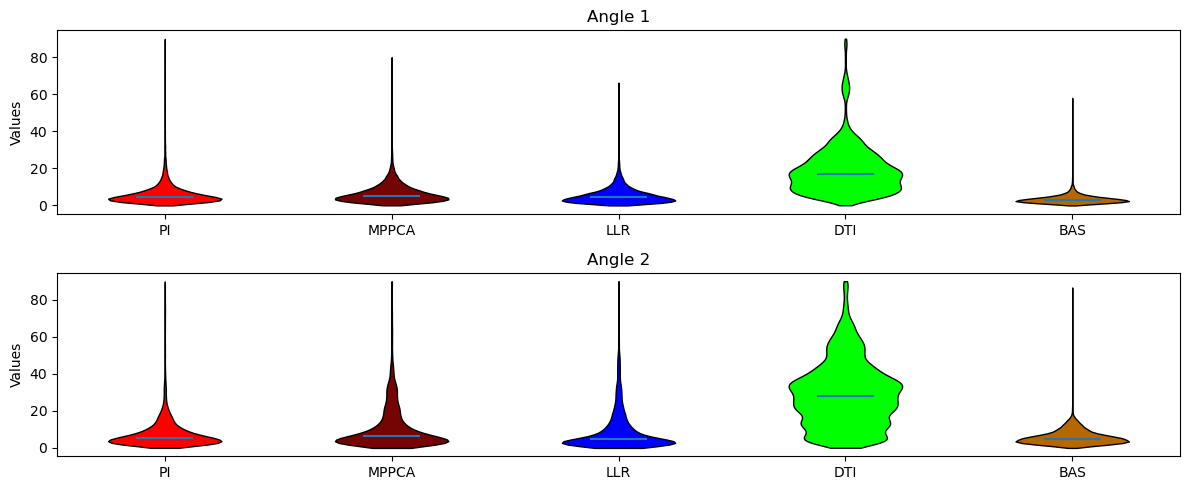

In [175]:
plot_violins(data, dataNames)

## Boxplots

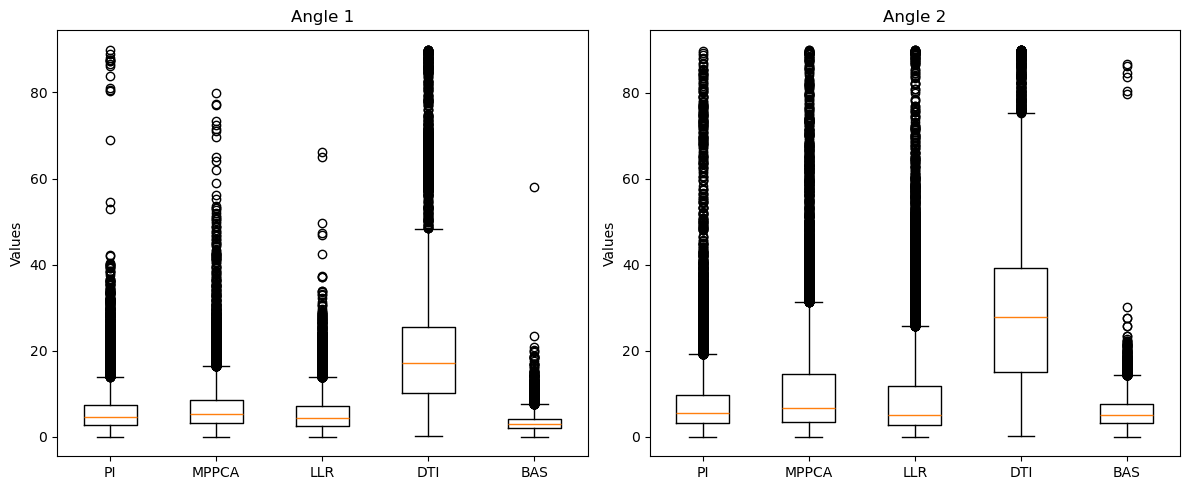

In [176]:
plot_boxplots(data, dataNames)

## Statistics

In [177]:
print_stats('CCCS mask', data)

Median, mean, std of angle 1 in CCCS mask:
PI:	 Median = 4.60, 	 Mean = 5.95,	 Std = 5.20
MPPCA:	 Median = 5.24, 	 Mean = 6.62,	 Std = 5.40
LLR:	 Median = 4.36, 	 Mean = 5.45,	 Std = 4.23
DTI:	 Median = 17.15, 	 Mean = 19.55,	 Std = 13.48
BAS:	 Median = 2.96, 	 Mean = 3.35,	 Std = 2.07



Median, mean, std of angle 2 in CCCS mask:
PI:	 Median = 5.55, 	 Mean = 8.00,	 Std = 8.54
MPPCA:	 Median = 6.62, 	 Mean = 11.38,	 Std = 12.31
LLR:	 Median = 5.02, 	 Mean = 9.73,	 Std = 11.84
DTI:	 Median = 27.83, 	 Mean = 29.10,	 Std = 17.62
BAS:	 Median = 5.07, 	 Mean = 5.88,	 Std = 3.83





# CXZP

In [156]:
angles1_CXZP, angles2_CXZP = run_statistics_on_angles_masked(dir, CXZP)
data = [angles1_CXZP, angles2_CXZP]
dataNames = ["Angle 1", "Angle 2"]

## Violinplots

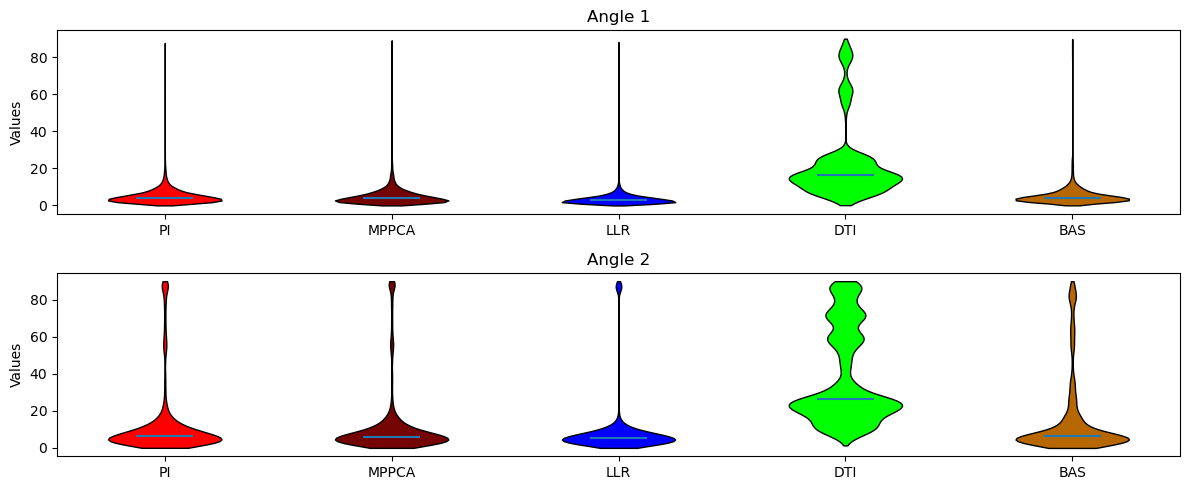

In [157]:
plot_violins(data, dataNames)

## Boxplots

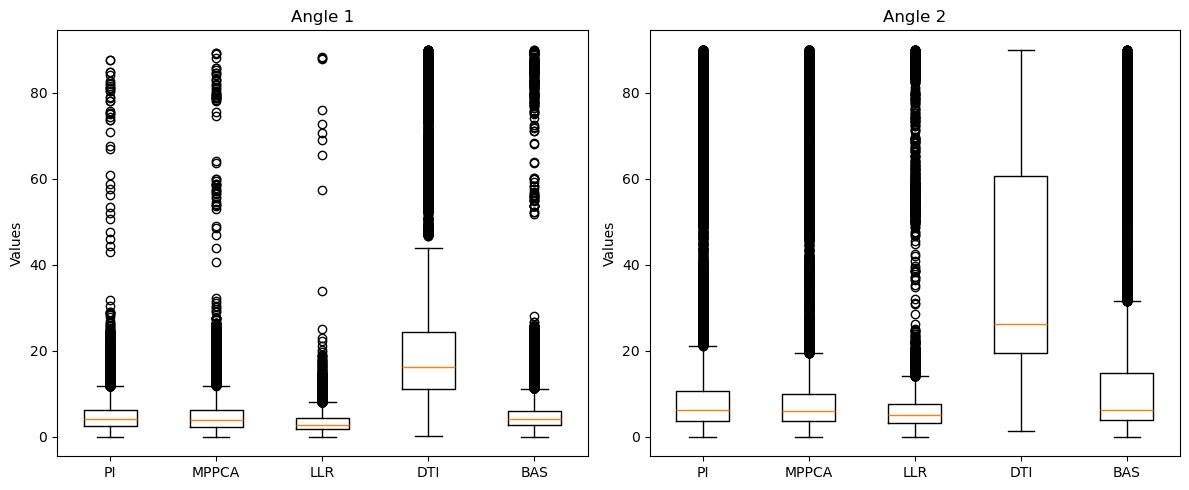

In [158]:
plot_boxplots(data, dataNames)

## Statistics

In [159]:
print_stats('CSXP mask', data)

Median, mean, std of angle 1 in CSXP mask:
PI:	 Median = 4.09, 	 Mean = 4.93,	 Std = 4.13
MPPCA:	 Median = 3.82, 	 Mean = 4.86,	 Std = 4.66
LLR:	 Median = 2.87, 	 Mean = 3.33,	 Std = 2.49
DTI:	 Median = 16.16, 	 Mean = 22.86,	 Std = 20.57
BAS:	 Median = 4.11, 	 Mean = 5.40,	 Std = 6.80



Median, mean, std of angle 2 in CSXP mask:
PI:	 Median = 6.31, 	 Mean = 12.57,	 Std = 19.28
MPPCA:	 Median = 5.99, 	 Mean = 11.85,	 Std = 18.68
LLR:	 Median = 5.16, 	 Mean = 8.89,	 Std = 16.16
DTI:	 Median = 26.19, 	 Mean = 38.71,	 Std = 25.49
BAS:	 Median = 6.30, 	 Mean = 15.61,	 Std = 21.79





# CSR

In [160]:
angles1_CSR, angles2_CSR = run_statistics_on_angles_masked(dir, CSR)
data = [angles1_CSR, angles2_CSR]
dataNames = ["Angle 1", "Angle 2"]

## Violinplots

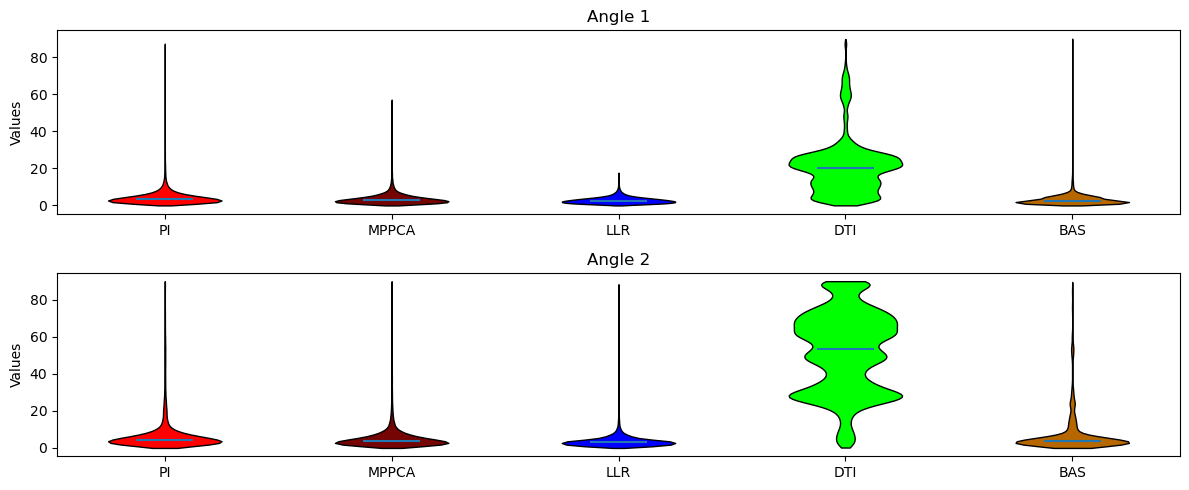

In [161]:
plot_violins(data, dataNames)

## Boxplots

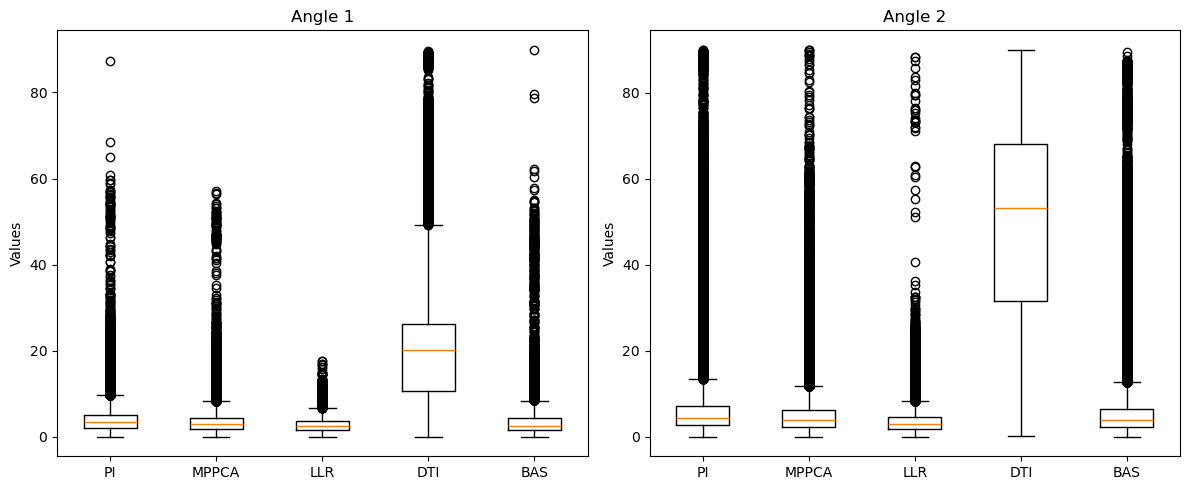

In [162]:
plot_boxplots(data, dataNames)

## Statistics

In [163]:
print_stats('CSR mask', data)

Median, mean, std of angle 1 in CSR mask:
PI:	 Median = 3.43, 	 Mean = 4.14,	 Std = 3.46
MPPCA:	 Median = 2.89, 	 Mean = 3.54,	 Std = 3.08
LLR:	 Median = 2.53, 	 Mean = 2.83,	 Std = 1.72
DTI:	 Median = 20.22, 	 Mean = 20.96,	 Std = 14.73
BAS:	 Median = 2.58, 	 Mean = 3.25,	 Std = 3.30



Median, mean, std of angle 2 in CSR mask:
PI:	 Median = 4.49, 	 Mean = 7.12,	 Std = 9.77
MPPCA:	 Median = 3.88, 	 Mean = 5.42,	 Std = 6.39
LLR:	 Median = 3.11, 	 Mean = 3.67,	 Std = 3.10
DTI:	 Median = 53.30, 	 Mean = 51.35,	 Std = 21.40
BAS:	 Median = 3.94, 	 Mean = 7.80,	 Std = 11.70





# CXZPRS

In [164]:
angles1_CXZPRS, angles2_CXZPRS = run_statistics_on_angles_masked(dir, CXZPRS)
data = [angles1_CXZPRS, angles2_CXZPRS]
dataNames = ["Angle 1", "Angle 2"]

## Violinplots

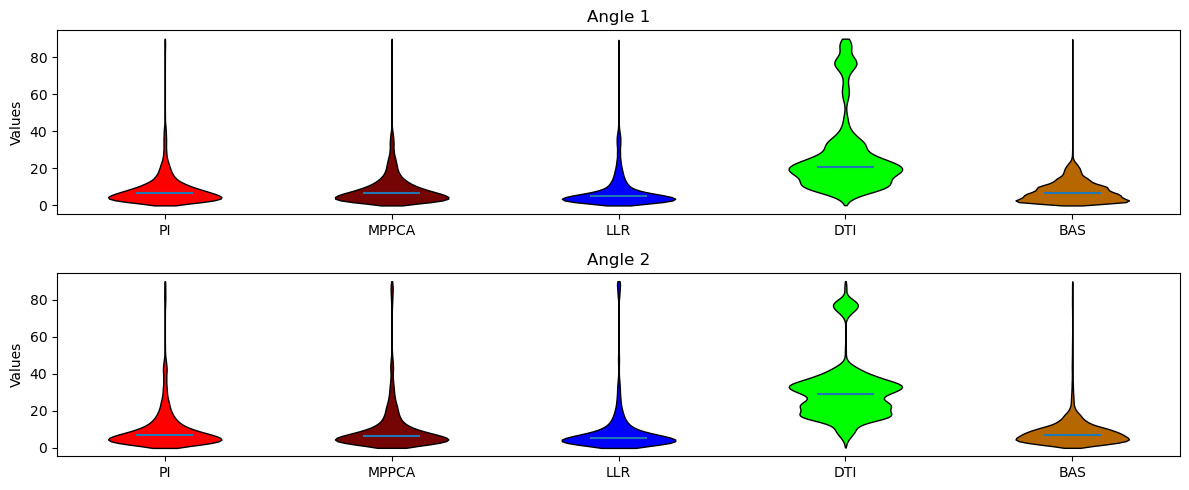

In [165]:
plot_violins(data, dataNames)

## Boxplots

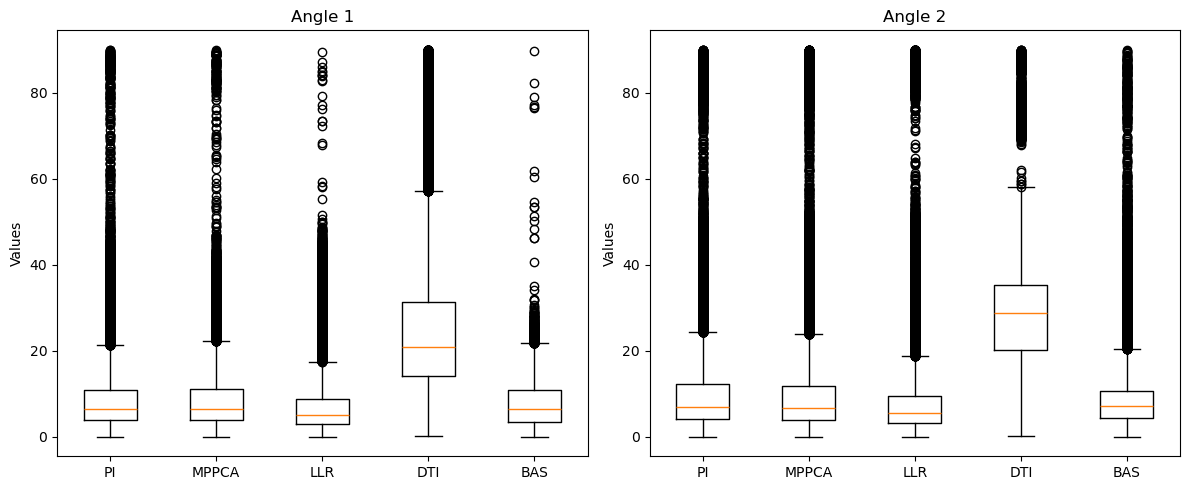

In [166]:
plot_boxplots(data, dataNames)

## Statistics

In [167]:
print_stats('CSXZPR mask', data)

Median, mean, std of angle 1 in CSXZPR mask:
PI:	 Median = 6.60, 	 Mean = 9.06,	 Std = 9.11
MPPCA:	 Median = 6.57, 	 Mean = 9.10,	 Std = 8.60
LLR:	 Median = 5.00, 	 Mean = 7.81,	 Std = 8.20
DTI:	 Median = 20.93, 	 Mean = 27.61,	 Std = 21.02
BAS:	 Median = 6.58, 	 Mean = 7.79,	 Std = 5.53



Median, mean, std of angle 2 in CSXZPR mask:
PI:	 Median = 6.97, 	 Mean = 10.65,	 Std = 11.88
MPPCA:	 Median = 6.66, 	 Mean = 10.98,	 Std = 13.48
LLR:	 Median = 5.56, 	 Mean = 9.56,	 Std = 13.90
DTI:	 Median = 28.89, 	 Mean = 30.62,	 Std = 15.95
BAS:	 Median = 7.16, 	 Mean = 8.95,	 Std = 8.52





BAS shows same behaviour as other reconstructions, slight improvements

# Calculate the bias between bootstrapped PI and bootstrapped BAS

In [168]:
vec1_comb_BAS
vec2_comb_PI

array([[[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        ...,


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],

In [169]:
def calc_mean_eigenvector(vec_comb):
    # vec_comb: shape (..., n, 3) where n is the number of bootstrap samples
    # org_vec: shape (3,) ground truth vector for bias calculation
    n_bs = vec_comb.shape[-2]
    # Compute average outer product
    M = np.einsum('...i,...j->...ij', vec_comb, vec_comb)  # shape (..., n, 3, 3)
    M = M.mean(axis=-3)  # average over the "n" dimension

    eigvals = np.zeros(M.shape[0:-1])
    eigvecs = np.zeros(M.shape)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            for k in range(M.shape[2]):
                if np.any(np.isnan(M[i,j,k,:,:])) or np.any(np.isinf(M[i,j,k,:,:])):
                    continue
                eval, evec = np.linalg.eig(M[i,j,k,:,:])
                idx = np.argsort(eval)[::-1]   # descending order
                eigvals[i,j,k,:] = eval[idx]
                eigvecs[i,j,k,:,:] = evec[:, idx]

    # Mean orientation is the first eigenvector of the dyadic tensor
    return eigvecs[...,:,0]  # shape (..., 3)


In [170]:
bias_angle_pi_bas_1 = angle_between_vectors_arr(calc_mean_eigenvector(vec1_comb_PI), calc_mean_eigenvector(vec1_comb_BAS))
bias_angle_pi_bas_2 = angle_between_vectors_arr(calc_mean_eigenvector(vec2_comb_PI), calc_mean_eigenvector(vec2_comb_BAS))

C:\Users\glaserjs\AppData\Local\Temp\ipykernel_32120\3232261450.py:11: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dots / norms, -1.0, 1.0)


In [187]:
bias_angle_pi_bas_1.shape

(110, 110, 1)

(-0.5, 109.5, 109.5, -0.5)

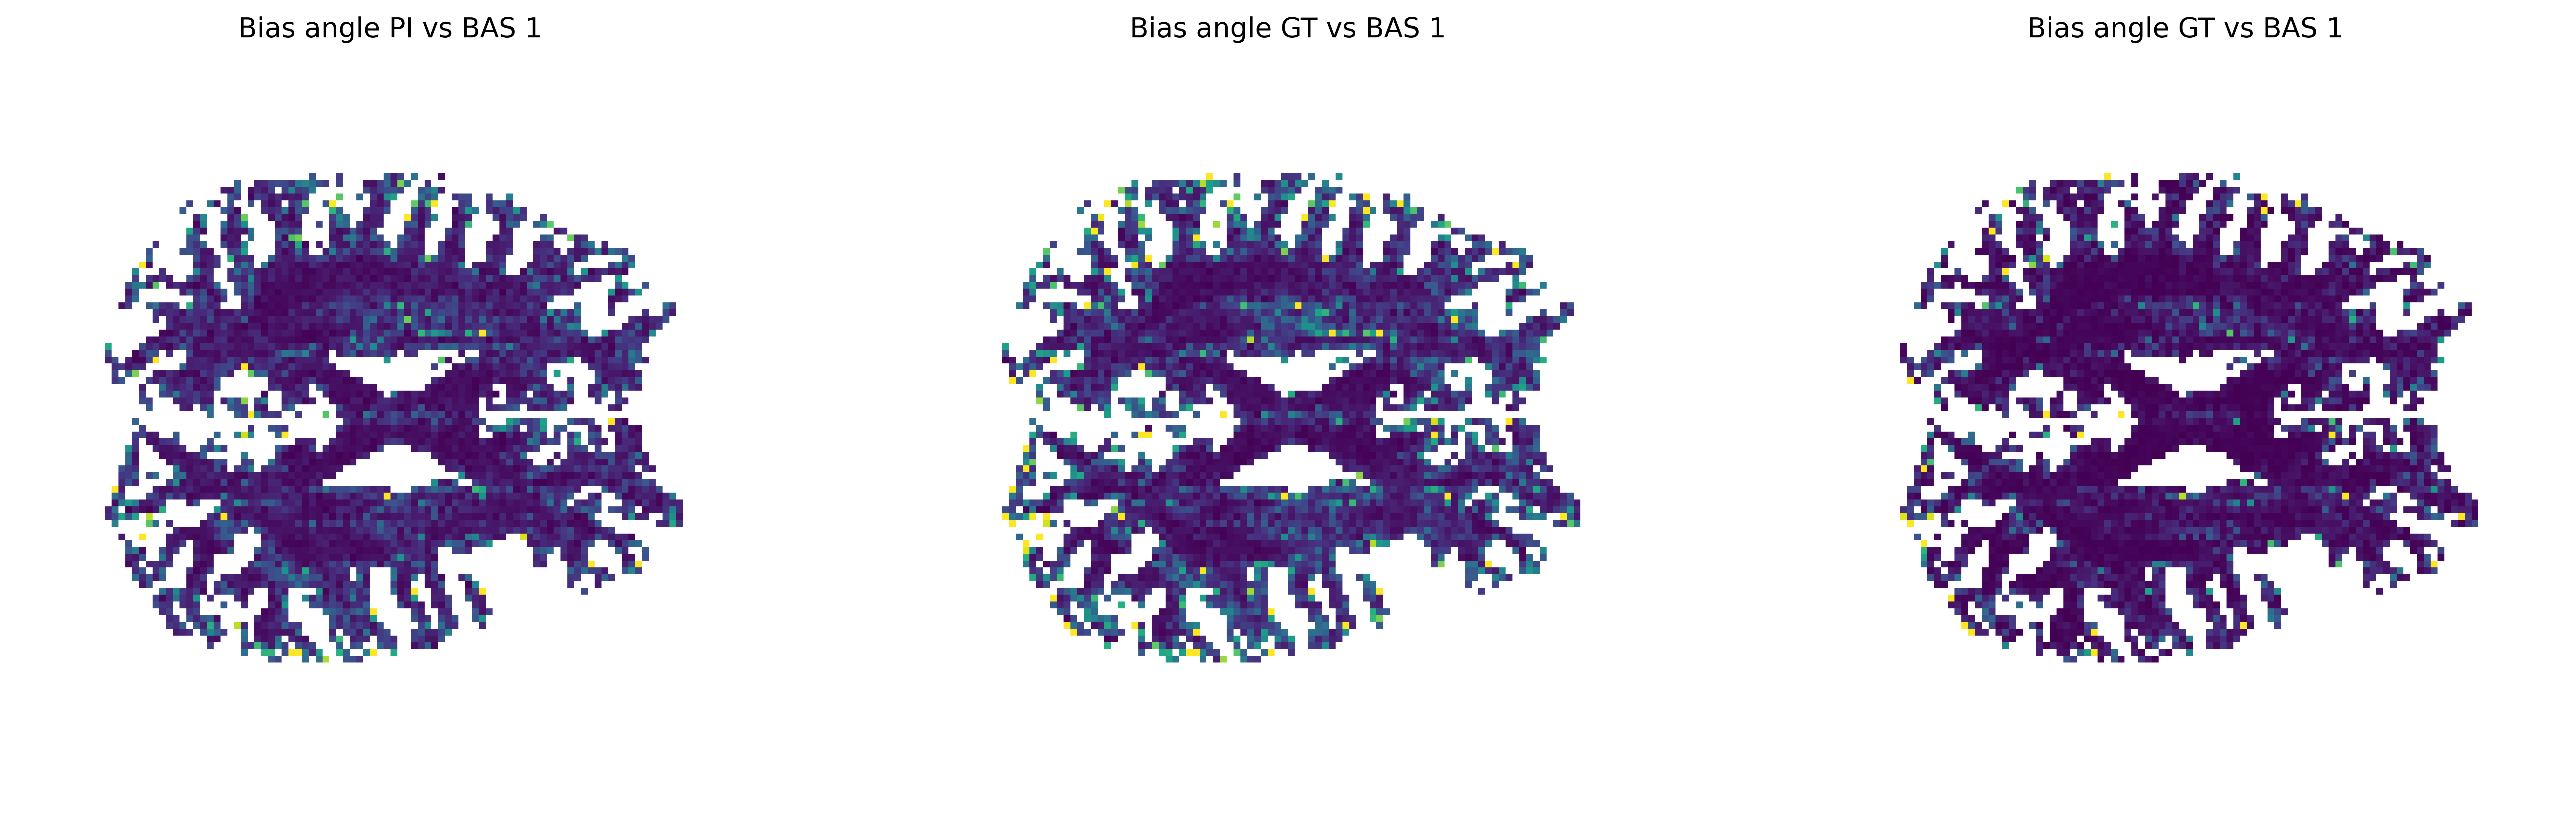

In [193]:
vmax = 30
vmin = 0

plt.subplots(1, 3, figsize=(20, 10), dpi=500)
plt.subplot(1, 3, 1)
plt.title('Bias angle PI vs BAS 1')
plt.imshow(bias_angle_1_PI*mask_1_plus_fiber_float, cmap=cmap, vmax=vmax, vmin=vmin)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Bias angle GT vs BAS 1')
plt.imshow(bias_angle_1_BAS[:,:,0]*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=vmax, vmin=vmin)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Bias angle GT vs BAS 1')
plt.imshow(abs(bias_angle_1_BAS[:,:,0]*mask_1_plus_fiber_float[...,0] - bias_angle_1_PI[...,0]*mask_1_plus_fiber_float[...,0]), cmap=cmap, vmax=vmax, vmin=vmin)
plt.axis('off')

In [ ]:
nib.save(nib.Nifti1Image(bias_angle_pi_bas_1.astype(np.float32), affine=mask_1_plus_fiber_float), dir + r'bias_angle_PI_vs_BAS_1.nii')

In [94]:
def save_nifti_with_header(data, reference_nifti_path, output_path):
    ref_img = nib.load(reference_nifti_path)
    new_img = nib.Nifti1Image(data.astype(np.float32), affine=ref_img.affine, header=ref_img.header)
    nib.save(new_img, output_path)

In [95]:
save_nifti_with_header(bias_angle_pi_bas_1, r'C:\msys64\home\glaserjs\bootstrap_analysis_1_fod\0\GT_PEAKS_12.nii', output_path=dir + r'bias_angle_PI_vs_BAS_1.nii')

In [ ]:
bias_angle_1_BAS

'W:\\radiologie\\mrt-probanden\\AG_Laun\\Julius_Glaser\\Revision_bipolar\\fod\\bootstraps_100_slice_12\\'

In [98]:
save_nifti_with_header(bias_angle_1_PI, r'C:\msys64\home\glaserjs\bootstrap_analysis_1_fod\0\GT_PEAKS_12.nii', output_path=dir + r'bias_angle_1_PI.nii')

In [178]:

rows = 3
cols = 3
N_diff=126
N_z = 1
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax_angle_1 = vmax_angle_2 = 90


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(2, 5, figsize=(20, 10), dpi=500)
    plt.subplot(2, 5, 1)
    plt.title('PI Angle 1 95th best')
    plt.imshow(bias_angle_1_PI[:,:,n_slice]/90*(1-angle_95_1_PI[:,:,n_slice]/90)*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 2)
    plt.title('MPPCA Angle 1 95th best')
    plt.imshow(bias_angle_1_MPPCA[:,:,n_slice]/90*(1-angle_95_1_MPPCA[:,:,n_slice]/90)*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 3)
    plt.title('LLR Angle 1 95th best')
    plt.imshow(bias_angle_1_LLR[:,:,n_slice]/90*(1-angle_95_1_LLR[:,:,n_slice]/90)*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 4)
    plt.title('BAS Angle 1 95th best')
    plt.imshow(bias_angle_1_BAS[:,:,n_slice]/90*(1-angle_95_1_BAS[:,:,n_slice]/90)*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 5)
    plt.title('DTI Angle 1 95th best')
    im=plt.imshow(bias_angle_1_DTI[:,:,n_slice]/90*(1-angle_95_1_DTI[:,:,n_slice]/90)*mask_1_plus_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(2, 5, 6)
    plt.title('PI Angle 2 95th best')
    plt.imshow(bias_angle_2_PI[:,:,n_slice]/90*(1-angle_95_2_PI[:,:,n_slice]/90)*mask_2_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 7)
    plt.title('MPPCA Angle 2 95th best')
    plt.imshow(bias_angle_2_MPPCA[:,:,n_slice]/90*(1-angle_95_1_MPPCA[:,:,n_slice]/90)*mask_2_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 8)
    plt.title('LLR Angle 2 95th best')
    plt.imshow(bias_angle_2_LLR[:,:,n_slice]/90*(1-angle_95_2_LLR[:,:,n_slice]/90)*mask_2_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 9)
    plt.title('BAS Angle 2 95th best')
    plt.imshow(bias_angle_2_BAS[:,:,n_slice]/90*(1-angle_95_2_BAS[:,:,n_slice]/90)*mask_2_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')
    plt.subplot(2, 5, 10)
    plt.title('DTI Angle 2 95th best')
    im2=plt.imshow(bias_angle_2_DTI[:,:,n_slice]/90*(1-angle_95_2_DTI[:,:,n_slice]/90)*mask_2_fiber_float[...,0], cmap=cmap, vmax=1, vmin=0)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=0), Output()), _dom_classes=('widget-inter…

Take the bias and precision

take only entries of mask

filter out nan

2d plot bias vs precision for all recos

In [179]:
masked_bias_PI_1 = (bias_angle_1_PI[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_bias_PI_1 = masked_bias_PI_1[~np.isnan(masked_bias_PI_1)]
masked_prec_PI_1 = (angle_95_1_PI[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_prec_PI_1 = masked_prec_PI_1[~np.isnan(masked_prec_PI_1)]
PI_prec_c = np.mean(masked_prec_PI_1)
PI_bias_c = np.mean(masked_bias_PI_1)

masked_bias_MPPCA_1 = (bias_angle_1_MPPCA[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_bias_MPPCA_1 = masked_bias_MPPCA_1[~np.isnan(masked_bias_MPPCA_1)]
masked_prec_MPPCA_1 = (angle_95_1_MPPCA[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_prec_MPPCA_1 = masked_prec_MPPCA_1[~np.isnan(masked_prec_MPPCA_1)]
MPPCA_prec_c = np.mean(masked_prec_MPPCA_1)
MPPCA_bias_c = np.mean(masked_bias_MPPCA_1)

masked_bias_LLR_1 = (bias_angle_1_LLR[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_bias_LLR_1 = masked_bias_LLR_1[~np.isnan(masked_bias_LLR_1)]
masked_prec_LLR_1 = (angle_95_1_LLR[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_prec_LLR_1 = masked_prec_LLR_1[~np.isnan(masked_prec_LLR_1)]
LLR_prec_c = np.mean(masked_prec_LLR_1)
LLR_bias_c = np.mean(masked_bias_LLR_1)

masked_bias_DTI_1 = (bias_angle_1_DTI[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_bias_DTI_1 = masked_bias_DTI_1[~np.isnan(masked_bias_DTI_1)]
masked_prec_DTI_1 = (angle_95_1_DTI[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_prec_DTI_1 = masked_prec_DTI_1[~np.isnan(masked_prec_DTI_1)]
DTI_prec_c = np.mean(masked_prec_DTI_1)
DTI_bias_c = np.mean(masked_bias_DTI_1)

masked_bias_BAS_1 = (bias_angle_1_BAS[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_bias_BAS_1 = masked_bias_BAS_1[~np.isnan(masked_bias_BAS_1)]
masked_prec_BAS_1 = (angle_95_1_BAS[:,:,0]*mask_1_plus_fiber_float[...,0]).flatten()
masked_prec_BAS_1 = masked_prec_BAS_1[~np.isnan(masked_prec_BAS_1)]
BAS_prec_c = np.mean(masked_prec_BAS_1)
BAS_bias_c = np.mean(masked_bias_BAS_1)

Text(0, 0.5, 'Bias in degrees')

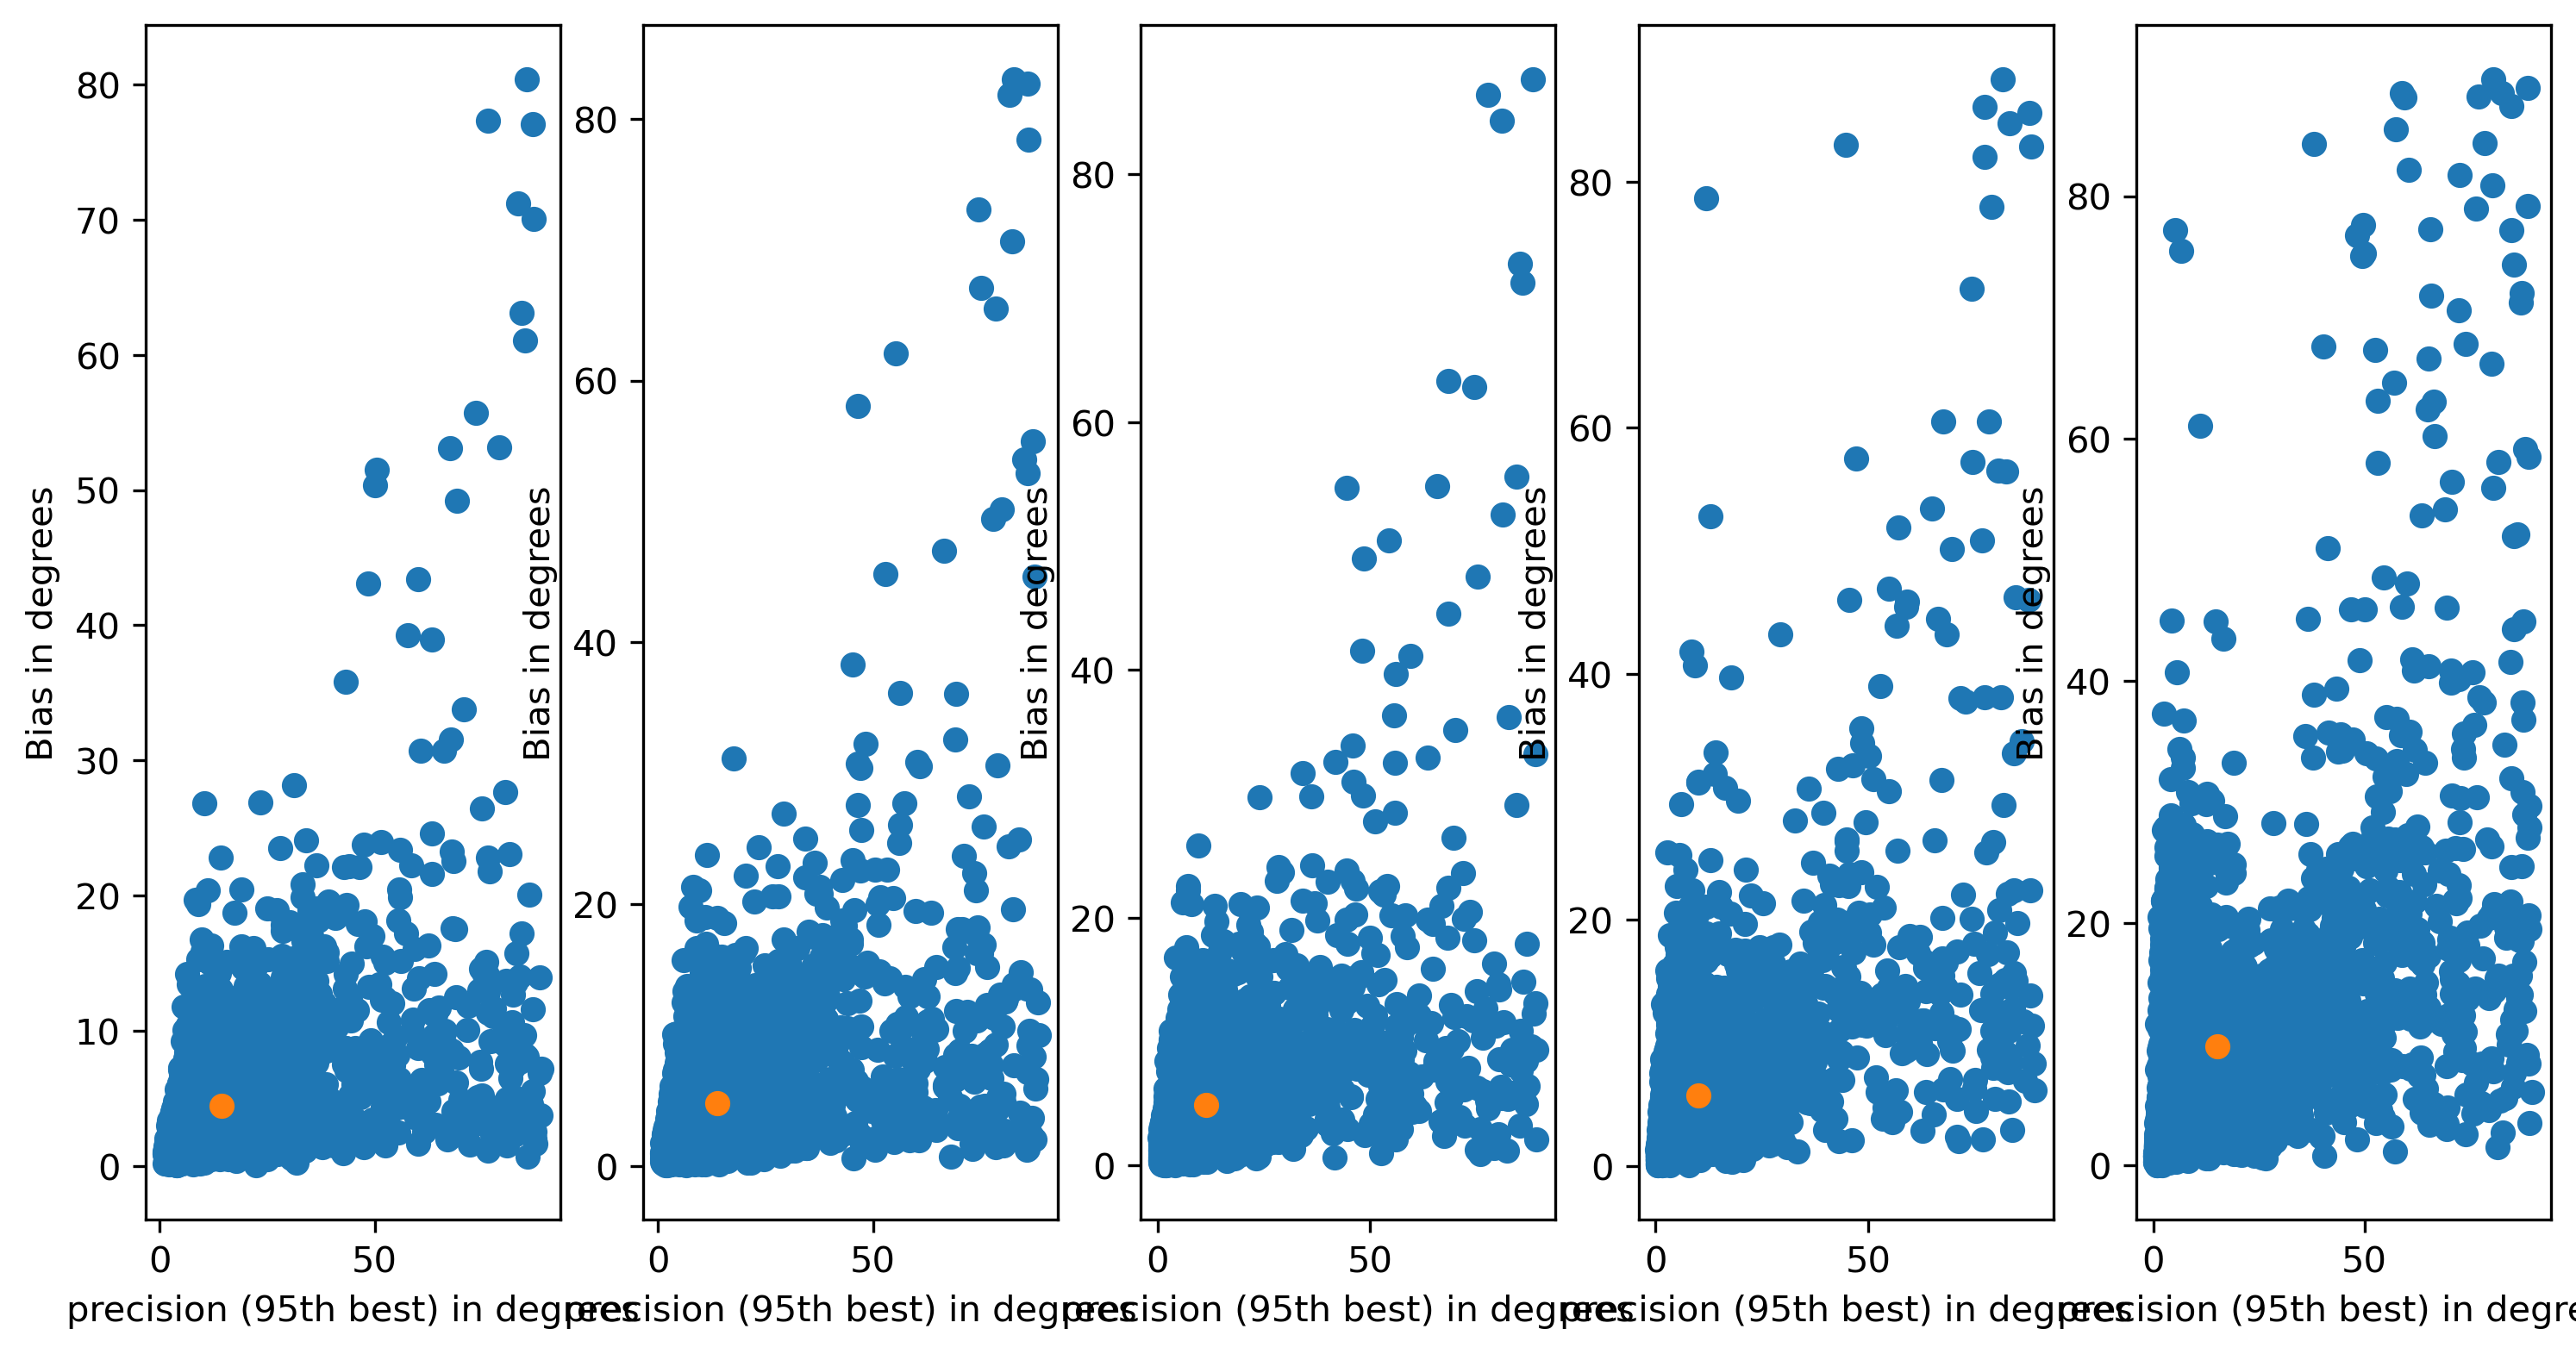

In [180]:
plt.subplots(1, 5, figsize=(12, 6), dpi=300)
plt.subplot(1, 5, 1)
plt.scatter(masked_prec_PI_1, masked_bias_PI_1, marker='o')
plt.scatter(PI_prec_c, PI_bias_c, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 2)
plt.scatter(masked_prec_MPPCA_1, masked_bias_MPPCA_1, marker='o')
plt.scatter(MPPCA_prec_c, MPPCA_bias_c, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 3)
plt.scatter(masked_prec_LLR_1, masked_bias_LLR_1, marker='o')
plt.scatter(LLR_prec_c, LLR_bias_c, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 4)
plt.scatter(masked_prec_BAS_1, masked_bias_BAS_1, marker='o')
plt.scatter(BAS_prec_c, BAS_bias_c, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 5)
plt.scatter(masked_prec_DTI_1, masked_bias_DTI_1, marker='o')
plt.scatter(DTI_prec_c, DTI_bias_c, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

In [181]:
print(PI_prec_c, PI_bias_c)
print(MPPCA_prec_c, MPPCA_bias_c)
print(LLR_prec_c, LLR_bias_c)
print(BAS_prec_c, BAS_bias_c)
print(DTI_prec_c, DTI_bias_c)


14.359449486804312 4.476945143232269
13.733342327007028 4.832492433584776
11.344795560126162 4.906869859825809
10.190927137106257 5.754927583901778
15.23295952852594 9.8677510842041


In [182]:
masked_bias_PI_2 = (bias_angle_2_PI[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_bias_PI_2 = masked_bias_PI_2[~np.isnan(masked_bias_PI_2)]
masked_prec_PI_2 = (angle_95_2_PI[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_prec_PI_2 = masked_prec_PI_2[~np.isnan(masked_prec_PI_2)]
PI_prec_c_2 = np.mean(masked_prec_PI_2)
PI_bias_c_2 = np.mean(masked_bias_PI_2)

masked_bias_MPPCA_2 = (bias_angle_2_MPPCA[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_bias_MPPCA_2 = masked_bias_MPPCA_2[~np.isnan(masked_bias_MPPCA_2)]
masked_prec_MPPCA_2 = (angle_95_2_MPPCA[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_prec_MPPCA_2 = masked_prec_MPPCA_2[~np.isnan(masked_prec_MPPCA_2)]
MPPCA_prec_c_2 = np.mean(masked_prec_MPPCA_2)
MPPCA_bias_c_2 = np.mean(masked_bias_MPPCA_2)

masked_bias_LLR_2 = (bias_angle_2_LLR[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_bias_LLR_2 = masked_bias_LLR_2[~np.isnan(masked_bias_LLR_2)]
masked_prec_LLR_2 = (angle_95_2_LLR[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_prec_LLR_2 = masked_prec_LLR_2[~np.isnan(masked_prec_LLR_2)]
LLR_prec_c_2 = np.mean(masked_prec_LLR_2)
LLR_bias_c_2 = np.mean(masked_bias_LLR_2)

masked_bias_DTI_2 = (bias_angle_2_DTI[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_bias_DTI_2 = masked_bias_DTI_2[~np.isnan(masked_bias_DTI_2)]
masked_prec_DTI_2 = (angle_95_2_DTI[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_prec_DTI_2 = masked_prec_DTI_2[~np.isnan(masked_prec_DTI_2)]
DTI_prec_c_2 = np.mean(masked_prec_DTI_2)
DTI_bias_c_2 = np.mean(masked_bias_DTI_2)

masked_bias_BAS_2 = (bias_angle_2_BAS[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_bias_BAS_2 = masked_bias_BAS_2[~np.isnan(masked_bias_BAS_2)]
masked_prec_BAS_2 = (angle_95_2_BAS[:,:,0]*mask_2_fiber_float[...,0]).flatten()
masked_prec_BAS_2 = masked_prec_BAS_2[~np.isnan(masked_prec_BAS_2)]
BAS_prec_c_2 = np.mean(masked_prec_BAS_2)
BAS_bias_c_2 = np.mean(masked_bias_BAS_2)

Text(0, 0.5, 'Bias in degrees')

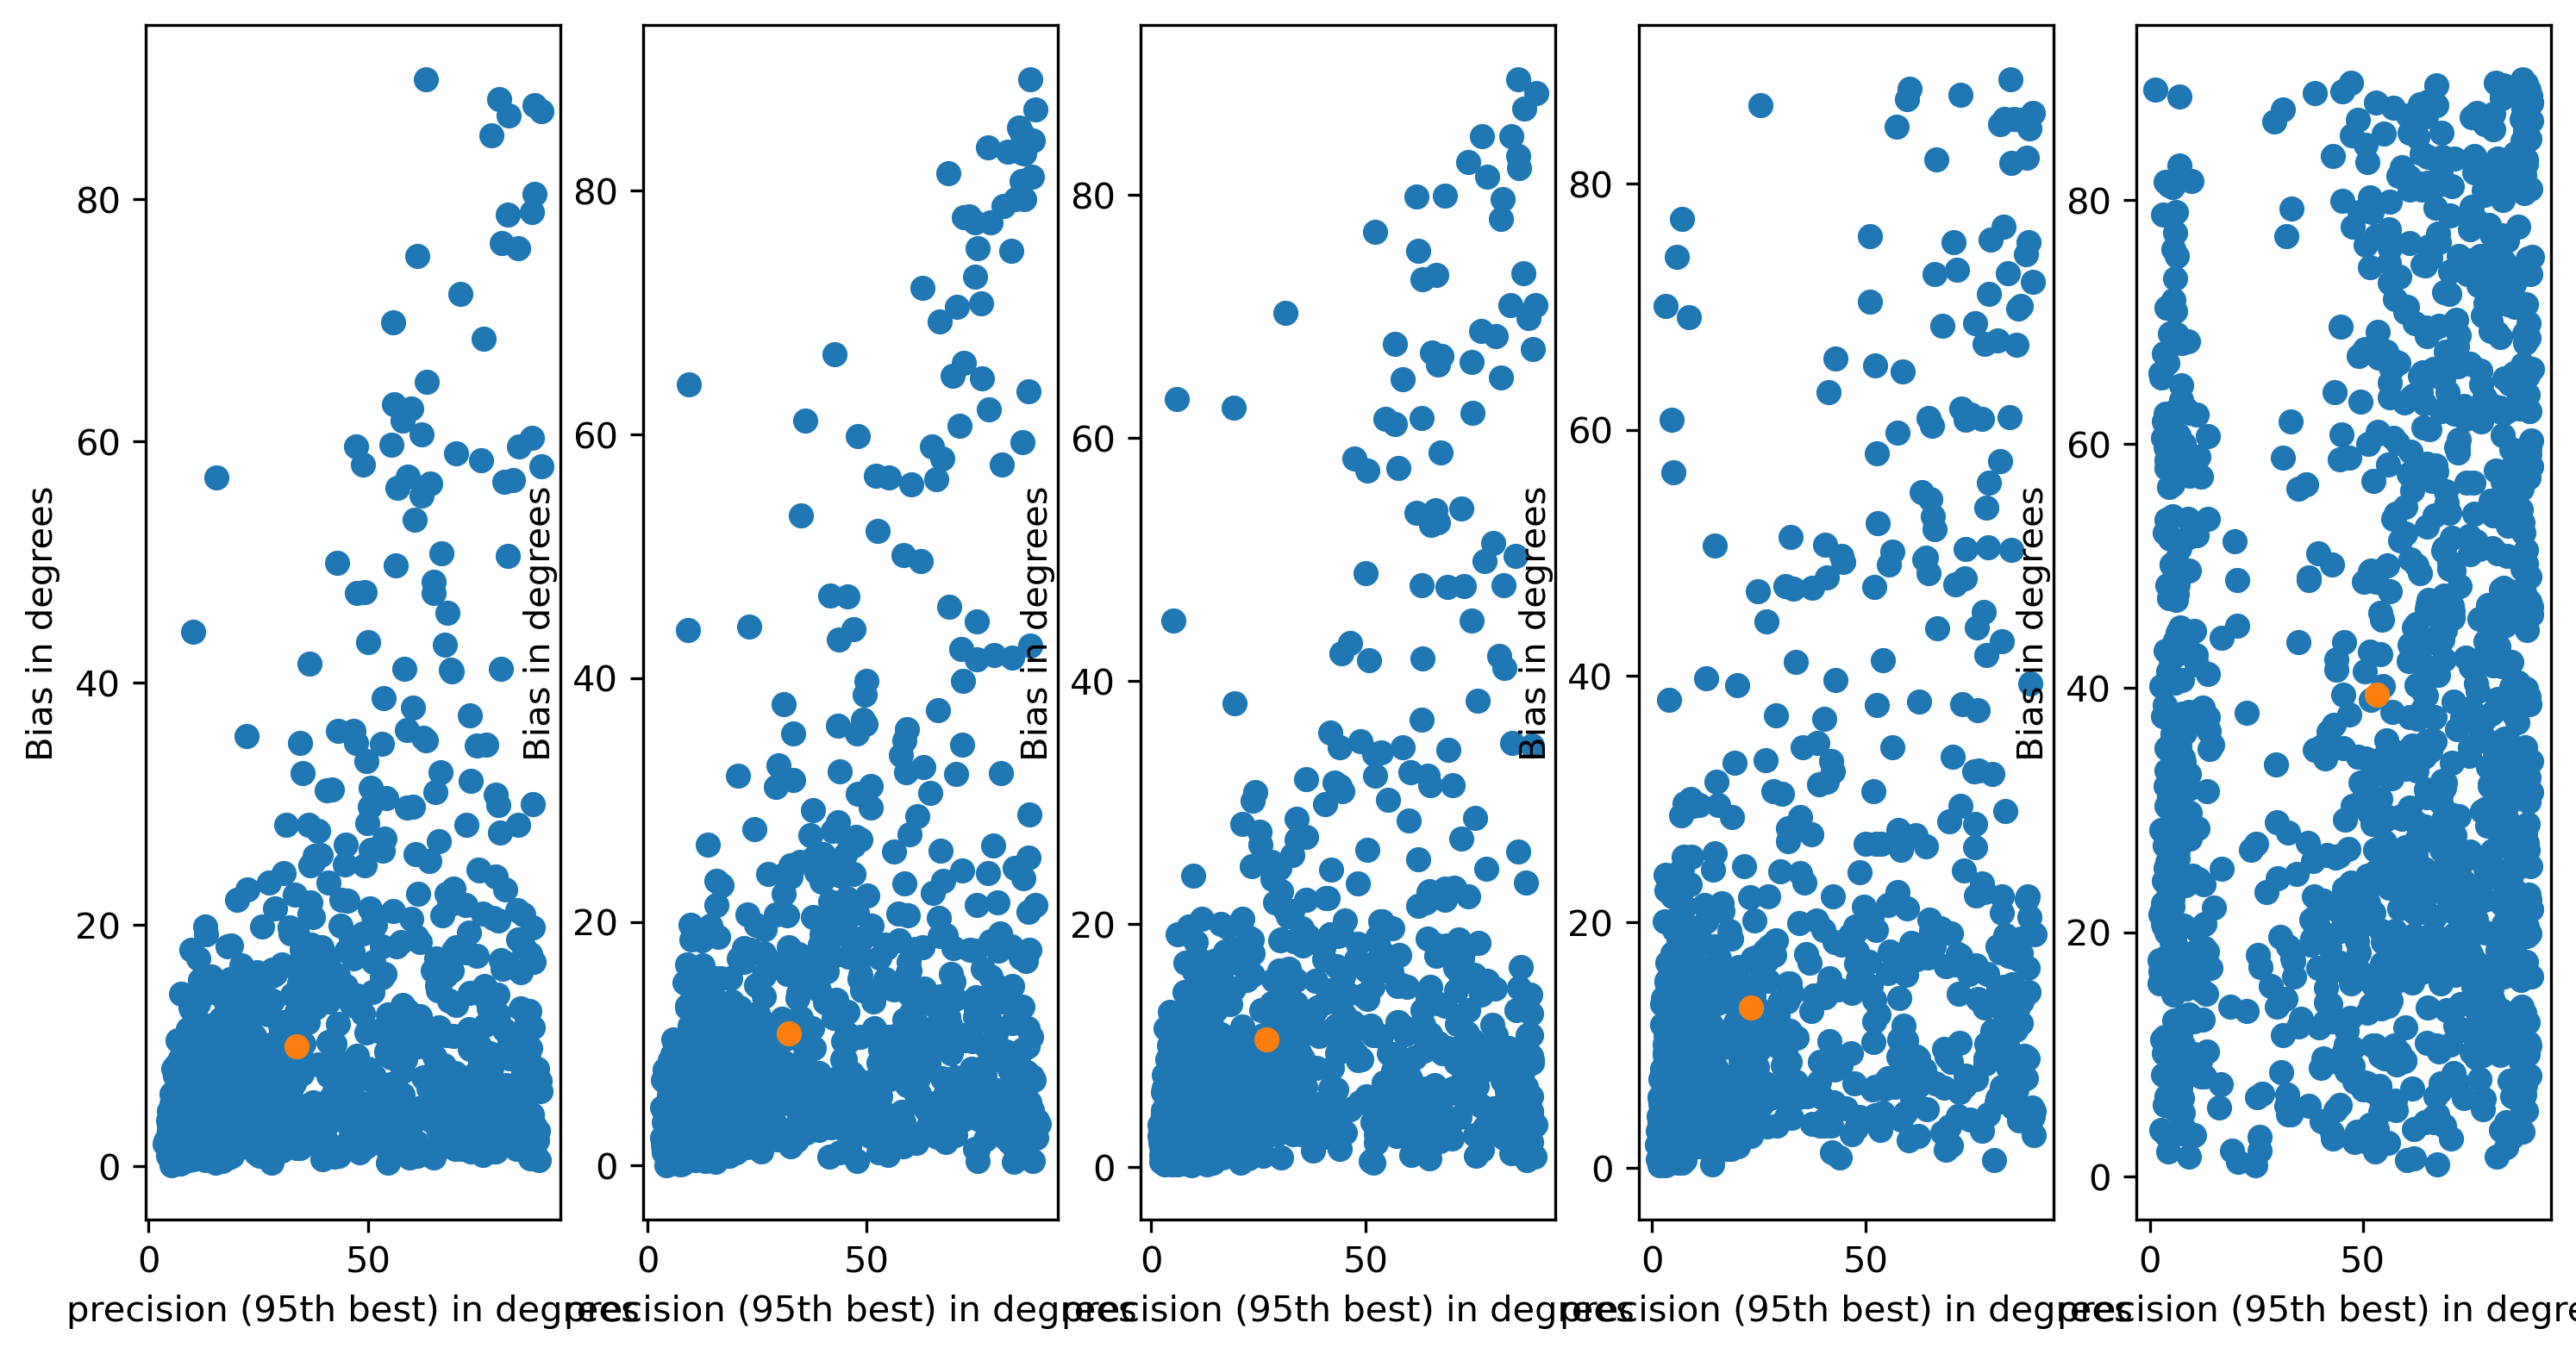

In [183]:
plt.subplots(1, 5, figsize=(12, 6), dpi=300)
plt.subplot(1, 5, 1)
plt.scatter(masked_prec_PI_2, masked_bias_PI_2, marker='o')
plt.scatter(PI_prec_c_2, PI_bias_c_2, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 2)
plt.scatter(masked_prec_MPPCA_2, masked_bias_MPPCA_2, marker='o')
plt.scatter(MPPCA_prec_c_2, MPPCA_bias_c_2, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 3)
plt.scatter(masked_prec_LLR_2, masked_bias_LLR_2, marker='o')
plt.scatter(LLR_prec_c_2, LLR_bias_c_2, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 4)
plt.scatter(masked_prec_BAS_2, masked_bias_BAS_2, marker='o')
plt.scatter(BAS_prec_c_2, BAS_bias_c_2, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

plt.subplot(1, 5, 5)
plt.scatter(masked_prec_DTI_2, masked_bias_DTI_2, marker='o')
plt.scatter(DTI_prec_c_2, DTI_bias_c_2, marker='o')
plt.xlabel("precision (95th best) in degrees")
plt.ylabel("Bias in degrees")

In [184]:
print(PI_prec_c_2, PI_bias_c_2)
print(MPPCA_prec_c_2, MPPCA_bias_c_2)
print(LLR_prec_c_2, LLR_bias_c_2)
print(BAS_prec_c_2, BAS_bias_c_2)
print(DTI_prec_c_2, DTI_bias_c_2)


33.68632525845682 9.96424085759581
32.132222812936874 10.84045253656016
26.791708145322506 10.481867105473514
23.181373175882314 13.076902366490371
53.31744073002283 39.494349840162364


# Complete Data Analysis

## Mask

In [102]:
index_f = nib.load(r'C:\msys64\home\glaserjs\bootstrap_analysis_1_fod\0\fixel_masks_all_new\index.nii')
index_data = index_f.get_fdata()
mask_1_plus_fiber_all = (index_data[:,:,0:25,0] > 0).astype(bool)
# mask_1_plus_fiber_all[:,:,0:7] = False
# mask_1_plus_fiber_all[:,:,23:25] = False
# mask_1_plus_fiber_all[0:30, :,:] = False
# mask_1_plus_fiber_all[80::, :,:] = False
# mask_1_plus_fiber_all[:, 0:25,:] = False
# mask_1_plus_fiber_all[:, 75::,:] = False
mask_2_fiber_all = (index_data[:,:,0:25,0] > 1).astype(bool)
mask_2_fiber_all = mask_2_fiber_all*mask_1_plus_fiber_all
# mask_2_fiber_all[:,:,0:10] = False
# mask_2_fiber_all[:,:,17::] = False

In [103]:
mask_1_plus_fiber_all.shape

(110, 110, 25)

In [104]:

N_diff=126
N_z = 25
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax_angle_1 = vmax_angle_2 = 90


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.imshow(mask_2_fiber_all[...,n_slice], cmap = 'gray', vmax=1, vmin=0)
    plt.axis('off')

interactive(children=(IntSlider(value=0, description='n_slice', max=24), Output()), _dom_classes=('widget-inte…

In [105]:
dir = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\BS_analysis_slice_all_1000' + os.sep

## Data loading

In [ ]:
# LLR
f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
print(f.keys())
angles_PI = f['angles'][:]
f.close()
angle_1_PI = np.where(mask_1_plus_fiber_all[...,None], angles_PI[...,0], np.nan).flatten()

angle_1_PI_filtered = angle_1_PI[~np.isnan(angle_1_PI) & ~np.isinf(angle_1_PI)]*180/np.pi
angle_2_PI = np.where(mask_2_fiber_all[...,None], angles_PI[...,1], np.nan).flatten()
angle_2_PI_filtered = angle_2_PI[~np.isnan(angle_2_PI) & ~np.isinf(angle_2_PI)]*180/np.pi

# MPPCA
f = h5py.File(dir + r'bootstrap_analysis_MPPCA.h5','r')
print(f.keys())
angles_MPPCA = f['angles'][:]
f.close()
angle_1_MPPCA = np.where(mask_1_plus_fiber_all[...,None], angles_MPPCA[...,0], np.nan).flatten()
angle_1_MPPCA_filtered = angle_1_MPPCA[~np.isnan(angle_1_MPPCA) & ~np.isinf(angle_1_MPPCA)]*180/np.pi
angle_2_MPPCA = np.where(mask_2_fiber_all[...,None], angles_MPPCA[...,1], np.nan).flatten()
angle_2_MPPCA_filtered = angle_2_MPPCA[~np.isnan(angle_2_MPPCA) & ~np.isinf(angle_2_MPPCA)]*180/np.pi

# # LLR
# f = h5py.File(dir + r'bootstrap_analysis_LLR.h5','r')
# print(f.keys())
# angles_LLR = f['angles'][:]
# f.close()
# angle_1_LLR = np.where(mask_1_plus_fiber_all[...,None], angles_LLR[...,0], np.nan).flatten()
# angle_1_LLR_filtered = angle_1_LLR[~np.isnan(angle_1_LLR) & ~np.isinf(angle_1_LLR)]*180/np.pi
# angle_2_LLR = np.where(mask_2_fiber_all[...,None], angles_LLR[...,1], np.nan).flatten()
# angle_2_LLR_filtered = angle_2_LLR[~np.isnan(angle_2_LLR) & ~np.isinf(angle_2_LLR)]*180/np.pi

# DTI
f = h5py.File(dir + r'bootstrap_analysis_DTI.h5','r')
print(f.keys())
angles_DTI = f['angles'][:]
f.close()
angle_1_DTI = np.where(mask_1_plus_fiber_all[...,None], angles_DTI[...,0], np.nan).flatten()
angle_1_DTI_filtered = angle_1_DTI[~np.isnan(angle_1_DTI) & ~np.isinf(angle_1_DTI)]*180/np.pi
angle_2_DTI = np.where(mask_2_fiber_all[...,None], angles_DTI[...,1], np.nan).flatten()
angle_2_DTI_filtered = angle_2_DTI[~np.isnan(angle_2_DTI) & ~np.isinf(angle_2_DTI)]*180/np.pi

# BAS
f = h5py.File(dir + r'bootstrap_analysis_BAS.h5','r')
print(f.keys())
angles_BAS = f['angles'][:]
f.close()
angle_1_BAS = np.where(mask_1_plus_fiber_all[...,None], angles_BAS[...,0], np.nan).flatten()
angle_1_BAS_filtered = angle_1_BAS[~np.isnan(angle_1_BAS) & ~np.isinf(angle_1_BAS)]*180/np.pi
angle_2_BAS = np.where(mask_2_fiber_all[...,None], angles_BAS[...,1], np.nan).flatten()
angle_2_BAS_filtered = angle_2_BAS[~np.isnan(angle_2_BAS) & ~np.isinf(angle_2_BAS)]*180/np.pi

<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>
<KeysViewHDF5 ['angles', 'org_vec_1', 'org_vec_2', 'vec1_comb', 'vec2_comb']>


In [ ]:
print('Number of primary fits')
print('angle_1_PI_filtered shape: ',angle_1_PI_filtered.shape)
print('angle_1_MPPCA_filtered shape: ',angle_1_MPPCA_filtered.shape)
print('angle_1_LLR_filtered shape: ',angle_1_LLR_filtered.shape)
print('angle_1_BAS_filtered shape: ',angle_1_BAS_filtered.shape)
print('angle_1_DTI_filtered shape: ',angle_1_DTI_filtered.shape)

print('Number of secondary fits')
print('angle_2_PI_filtered shape: ',angle_2_PI_filtered.shape)
print('angle_2_MPPCA_filtered shape: ',angle_2_MPPCA_filtered.shape)
print('angle_2_LLR_filtered shape: ',angle_2_LLR_filtered.shape)
print('angle_2_BAS_filtered shape: ',angle_2_BAS_filtered.shape)
print('angle_2_DTI_filtered shape: ',angle_2_DTI_filtered.shape)


Number of primary fits
angle_1_PI_filtered shape:  (51880068,)
angle_1_MPPCA_filtered shape:  (51932000,)
angle_1_LLR_filtered shape:  (51880068,)
angle_1_BAS_filtered shape:  (51932000,)
angle_1_DTI_filtered shape:  (51932000,)
Number of secondary fits
angle_2_PI_filtered shape:  (14933050,)
angle_2_MPPCA_filtered shape:  (14948000,)
angle_2_LLR_filtered shape:  (14933050,)
angle_2_BAS_filtered shape:  (14947999,)
angle_2_DTI_filtered shape:  (14947992,)


In [89]:
angles1 = [angle_1_PI_filtered , angle_1_MPPCA_filtered, angle_1_LLR_filtered , angle_1_DTI_filtered , angle_1_BAS_filtered ]  # flatten to 1D
angles2 = [angle_2_PI_filtered , angle_2_MPPCA_filtered, angle_2_LLR_filtered , angle_2_DTI_filtered , angle_2_BAS_filtered ]  # flatten to 1D

print_stats('angle_1_PI_filtered', [angles1, angles2])

Median, mean, std of angle 1 in angle_1_PI_filtered:
PI:	 Median = 5.31, 	 Mean = 8.70,	 Std = 11.12
MPPCA:	 Median = 5.54, 	 Mean = 9.02,	 Std = 11.13
LLR:	 Median = 5.31, 	 Mean = 8.70,	 Std = 11.12
DTI:	 Median = 8.99, 	 Mean = 12.64,	 Std = 13.15
BAS:	 Median = 4.94, 	 Mean = 8.59,	 Std = 11.00



Median, mean, std of angle 2 in angle_1_PI_filtered:
PI:	 Median = 8.96, 	 Mean = 17.98,	 Std = 21.44
MPPCA:	 Median = 9.62, 	 Mean = 18.47,	 Std = 21.34
LLR:	 Median = 8.96, 	 Mean = 17.98,	 Std = 21.44
DTI:	 Median = 34.21, 	 Mean = 40.13,	 Std = 26.06
BAS:	 Median = 9.61, 	 Mean = 17.96,	 Std = 20.91





## Violinplots

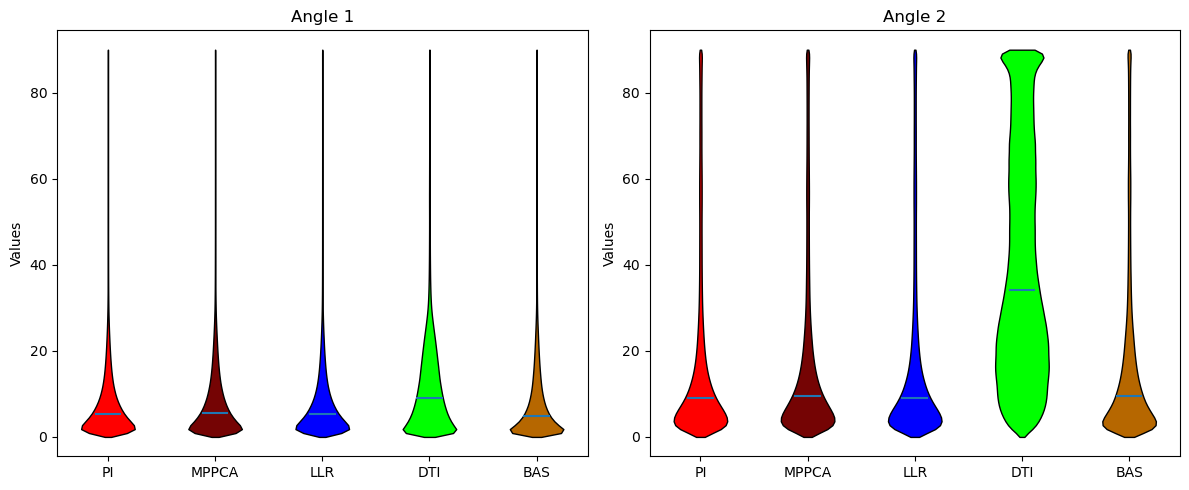

In [7]:
angles1 = [angle_1_PI_filtered , angle_1_MPPCA_filtered, angle_1_LLR_filtered , angle_1_DTI_filtered , angle_1_BAS_filtered ]  # flatten to 1D
angles2 = [angle_2_PI_filtered , angle_2_MPPCA_filtered, angle_2_LLR_filtered , angle_2_DTI_filtered , angle_2_BAS_filtered ]  # flatten to 1D

data = [angles1, angles2]
dataNames = ["Angle 1", "Angle 2"]
plot_colors = ["#FF0000", "#750404","#0000FF", "#00FF00", "#B66700"]
# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True, showextrema=False)

    for l, pc in enumerate(parts['bodies']):
        pc.set_facecolor(plot_colors[l])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # quartile1, medians, quartile3 = np.percentile(data[i], [25, 50, 75], axis=1)
    # whiskers = np.array([
    #     adjacent_values(sorted_array, q1, q3)
    #     for sorted_array, q1, q3 in zip(data[i], quartile1, quartile3)])
    # whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    # inds = np.arange(1, len(medians)+1)
    # ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    # ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    # ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    # ax.axhline(7)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(["PI", "MPPCA", "LLR", "DTI", "BAS"])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()


## Boxplots

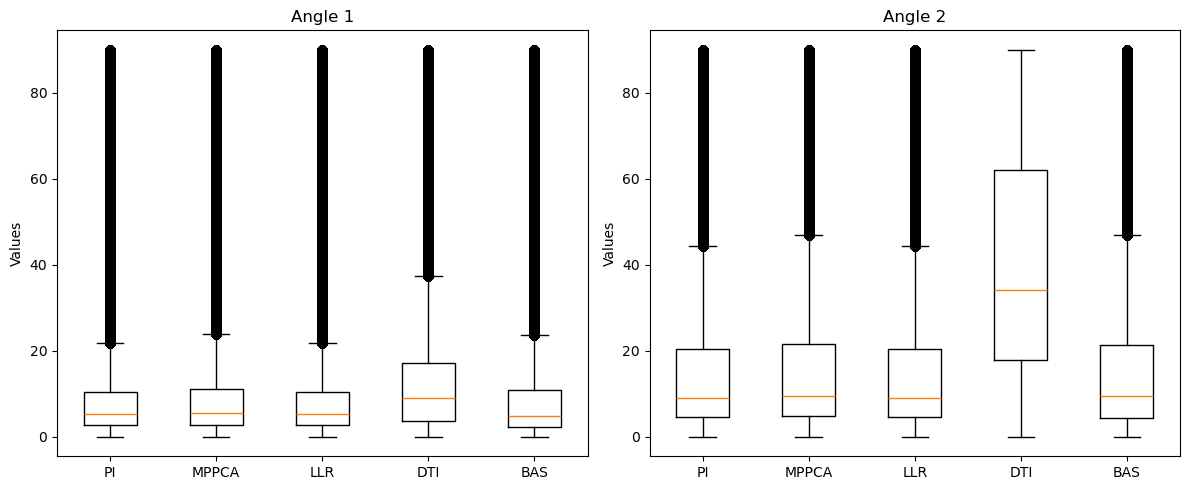

In [8]:

# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.boxplot(data[i], tick_labels=["PI", "MPPCA", "LLR", "DTI", "BAS"])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()


## Bias

In [107]:
analysis_path = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\BS_analysis_slice_all_1000\results' + os.sep

f = h5py.File(analysis_path + r'\PI_bias_prec_all_slices.h5','r')
bias_angle_1_PI = f['Bias_1'][:]
bias_angle_2_PI = f['Bias_2'][:]
angle_95_1_PI = f['Prec_1'][:]
angle_95_2_PI = f['Prec_2'][:]
f.close()

f = h5py.File(analysis_path + r'\MPPCA_bias_prec_all_slices.h5','r')
bias_angle_1_MPPCA = f['Bias_1'][:]
bias_angle_2_MPPCA = f['Bias_2'][:]
angle_95_1_MPPCA = f['Prec_1'][:]
angle_95_2_MPPCA = f['Prec_2'][:]
f.close()

f = h5py.File(analysis_path + r'\DTI_bias_prec_all_slices.h5','r')
bias_angle_1_DTI = f['Bias_1'][:]
bias_angle_2_DTI = f['Bias_2'][:]
angle_95_1_DTI = f['Prec_1'][:]
angle_95_2_DTI = f['Prec_2'][:]
f.close()

f = h5py.File(analysis_path + r'\BAS_bias_prec_all_slices.h5','r')
bias_angle_1_BAS = f['Bias_1'][:]
bias_angle_2_BAS = f['Bias_2'][:]
angle_95_1_BAS = f['Prec_1'][:]
angle_95_2_BAS = f['Prec_2'][:]
f.close()

f = h5py.File(analysis_path + r'\LLR1_blk3_lam0.01_bias_prec_all_slices.h5','r')
bias_angle_1_LLR = f['Bias_1'][:]
bias_angle_2_LLR = f['Bias_2'][:]
angle_95_1_LLR = f['Prec_1'][:]
angle_95_2_LLR = f['Prec_2'][:]
f.close()

f = h5py.File(analysis_path + r'\DAE_BAS_new_reco_bias_prec_all_slices.h5','r')
bias_angle_1_BAS_new_reco = f['Bias_1'][:]
bias_angle_2_BAS_new_reco = f['Bias_2'][:]
angle_95_1_BAS_new_reco = f['Prec_1'][:]
angle_95_2_BAS_new_reco = f['Prec_2'][:]
f.close()



f = h5py.File(analysis_path + r'\DAE_BAS_splitted_reco_latent_smooth_bias_prec_all_slices.h5','r')
bias_angle_1_BAS_split_new_reco = f['Bias_1'][:]
bias_angle_2_BAS_split_new_reco = f['Bias_2'][:]
angle_95_1_BAS_split_new_reco = f['Prec_1'][:]
angle_95_2_BAS_split_new_reco = f['Prec_2'][:]
f.close()
# f = h5py.File(analysis_path + r'\DAE_BAS_splitted_reco_TV_01_9_3_03_bias_prec_all_slices.h5','r')
# bias_angle_1_BAS_split_new_reco_new_TV = f['Bias_1'][:]
# bias_angle_2_BAS_split_new_reco_new_TV = f['Bias_2'][:]
# angle_95_1_BAS_split_new_reco_new_TV = f['Prec_1'][:]
# angle_95_2_BAS_split_new_reco_new_TV = f['Prec_2'][:]
# f.close()

# f = h5py.File(analysis_path + r'\DAE_BAS_splitted_reco_WR_01_40_25_10_bias_prec_all_slices.h5','r')
# bias_angle_1_BAS_split_new_reco_new_wave = f['Bias_1'][:]
# bias_angle_2_BAS_split_new_reco_new_wave = f['Bias_2'][:]
# angle_95_1_BAS_split_new_reco_new_wave= f['Prec_1'][:]
# angle_95_2_BAS_split_new_reco_new_wave = f['Prec_2'][:]
# f.close()

# f = h5py.File(r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\BS_analysis_slice_all_1000\bootstrap_analysis_LLR.h5','r')
# org_vec1 = f['org_vec_1'][:]
# org_vec2 = f['org_vec_2'][:]
# vec1_comb_LLR = f['vec1_comb'][:]
# vec2_comb_LLR = f['vec2_comb'][:]
# # 337 is broken
# vec1_comb_LLR = np.delete(vec1_comb_LLR, 337, axis=-2)
# vec2_comb_LLR = np.delete(vec2_comb_LLR, 337, axis=-2)
# f.close()
# kappa_1_LLR, bias_angle_1_LLR, angle_95_1_LLR = compute_analysis_metrics(vec1_comb_LLR, org_vec1)
# kappa_2_LLR, bias_angle_2_LLR, angle_95_2_LLR = compute_analysis_metrics(vec2_comb_LLR, org_vec2)

In [108]:
mask_1_plus_fiber_float_all = mask_1_plus_fiber_all.copy().astype(float)
mask_2_fiber_float_all = mask_2_fiber_all.copy().astype(float)

mask_1_plus_fiber_float_all[~mask_1_plus_fiber_all] = np.nan
mask_2_fiber_float_all[~mask_2_fiber_all] = np.nan

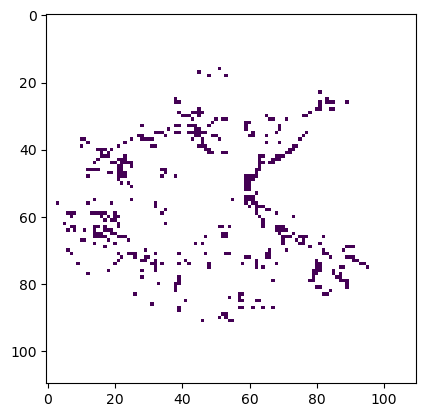

In [109]:
plt.imshow(mask_2_fiber_float_all[:,:,6])

In [12]:
rows = 2
cols = 5
N_diff=126
N_z = 25
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax=20
cmap = 'viridis'


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    n_slice=13
    plt.subplots(rows, cols, figsize=(20, 10), dpi=500)
    plt.subplot(rows, cols, 1)
    plt.title('PI Angle 1 bias')
    plt.imshow((bias_angle_1_PI*mask_1_plus_fiber_float_all)[:,:,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 2)
    plt.title('MPPCA Angle 1 bias')
    plt.imshow(bias_angle_1_MPPCA[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 3)
    plt.title('LLR Angle 1 bias')
    plt.imshow(bias_angle_1_LLR[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 4)
    plt.title('BAS Angle 1 bias')
    plt.imshow(bias_angle_1_BAS[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 5)
    plt.title('DTI Angle 1 bias')
    im=plt.imshow(bias_angle_1_DTI[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(rows, cols, cols+1)
    plt.title('PI Angle 2 bias')
    plt.imshow(bias_angle_2_PI[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+2)
    plt.title('MPPCA Angle 2 bias')
    plt.imshow(bias_angle_2_MPPCA[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+3)
    plt.title('LLR Angle 2 bias')
    plt.imshow(bias_angle_2_LLR[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+4)
    plt.title('BAS Angle 2 bias')
    plt.imshow(bias_angle_2_BAS[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+5)
    plt.title('DTI Angle 2 bias')
    im2=plt.imshow(bias_angle_2_DTI[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=24), Output()), _dom_classes=('widget-inte…

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rows = 2
cols = 5
N_z = 25
n_slice = 13
vmax = 20
cmap = 'viridis'

# Example titles & data structures
titles_1 = ['PI Angle 1 bias', 'MPPCA Angle 1 bias', 'LLR Angle 1 bias', 'BAS Angle 1 bias', 'DTI Angle 1 bias']
data_1 = [bias_angle_1_PI, bias_angle_1_MPPCA, bias_angle_1_LLR, bias_angle_1_BAS, bias_angle_1_DTI]
mask_1 = mask_1_plus_fiber_float_all

titles_2 = ['PI Angle 2 bias', 'MPPCA Angle 2 bias', 'LLR Angle 2 bias', 'BAS Angle 2 bias', 'DTI Angle 2 bias']
data_2 = [bias_angle_2_PI, bias_angle_2_MPPCA, bias_angle_2_LLR, bias_angle_2_BAS, bias_angle_2_DTI]
mask_2 = mask_2_fiber_float_all

# Combine into a single list for easier looping
all_titles = titles_1 + titles_2
all_data = data_1 + data_2
all_masks = [mask_1]*cols + [mask_2]*cols  # first 5 use mask_1, last 5 use mask_2

# --- Loop over all subplots and save each as its own PDF ---
for i, (title, data, mask) in enumerate(zip(all_titles, all_data, all_masks)):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)  # single subplot per figure
    im = ax.imshow((data* mask)[18:90,14:96, n_slice], vmin=0, vmax=vmax, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')
    
    # Add a colorbar without shrinking the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, label="Angle difference in degrees")
    
    # Save as PDF
    filename = f"{title.replace(' ', '_')}.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.close(fig)

print("✅ Saved all subplots with colorbars as individual PDF files (300 DPI).")


✅ Saved all subplots with colorbars as individual PDF files (300 DPI).


## Filter biasis

In [198]:
bias_angle_1_PI_filtered = (bias_angle_1_PI*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_PI_filtered = bias_angle_1_PI_filtered[~np.isnan(bias_angle_1_PI_filtered)]
bias_angle_2_PI_filtered = (bias_angle_2_PI*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_PI_filtered = bias_angle_2_PI_filtered[~np.isnan(bias_angle_2_PI_filtered)]

bias_angle_1_MPPCA_filtered = (bias_angle_1_MPPCA*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_MPPCA_filtered = bias_angle_1_MPPCA_filtered[~np.isnan(bias_angle_1_MPPCA_filtered)]
bias_angle_2_MPPCA_filtered = (bias_angle_2_MPPCA*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_MPPCA_filtered = bias_angle_2_MPPCA_filtered[~np.isnan(bias_angle_2_MPPCA_filtered)]

bias_angle_1_LLR_filtered = (bias_angle_1_LLR*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_LLR_filtered = bias_angle_1_LLR_filtered[~np.isnan(bias_angle_1_LLR_filtered)]
bias_angle_2_LLR_filtered = (bias_angle_2_LLR*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_LLR_filtered = bias_angle_2_LLR_filtered[~np.isnan(bias_angle_2_LLR_filtered)]

bias_angle_1_DTI_filtered = (bias_angle_1_DTI*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_DTI_filtered = bias_angle_1_DTI_filtered[~np.isnan(bias_angle_1_DTI_filtered)]
bias_angle_2_DTI_filtered = (bias_angle_2_DTI*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_DTI_filtered = bias_angle_2_DTI_filtered[~np.isnan(bias_angle_2_DTI_filtered)]

bias_angle_1_BAS_filtered = (bias_angle_1_BAS*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_BAS_filtered = bias_angle_1_BAS_filtered[~np.isnan(bias_angle_1_BAS_filtered)]
bias_angle_2_BAS_filtered = (bias_angle_2_BAS*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_BAS_filtered = bias_angle_2_BAS_filtered[~np.isnan(bias_angle_2_BAS_filtered)]

bias_angle_1_BAS_new_reco_filtered = (bias_angle_1_BAS_new_reco*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_BAS_new_reco_filtered = bias_angle_1_BAS_new_reco_filtered[~np.isnan(bias_angle_1_BAS_new_reco_filtered)]
bias_angle_2_BAS_new_reco_filtered = (bias_angle_2_BAS_new_reco*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_BAS_new_reco_filtered = bias_angle_2_BAS_new_reco_filtered[~np.isnan(bias_angle_2_BAS_new_reco_filtered)]


bias_angle_1_BAS_split_new_reco_filtered = (bias_angle_1_BAS_split_new_reco*mask_1_plus_fiber_float_all)[:,:,4:]
bias_angle_1_BAS_split_new_reco_filtered = bias_angle_1_BAS_split_new_reco_filtered[~np.isnan(bias_angle_1_BAS_split_new_reco_filtered)]
bias_angle_2_BAS_split_new_reco_filtered = (bias_angle_2_BAS_split_new_reco*mask_2_fiber_float_all)[:,:,4:]
bias_angle_2_BAS_split_new_reco_filtered = bias_angle_2_BAS_split_new_reco_filtered[~np.isnan(bias_angle_2_BAS_split_new_reco_filtered)]

# bias_angle_1_DAE_BAS_filtered = (bias_angle_1_DAE_BAS*mask_1_plus_fiber_float_all)[:,:,4:]
# bias_angle_1_DAE_BAS_filtered = bias_angle_1_DAE_BAS_filtered[~np.isnan(bias_angle_1_DAE_BAS_filtered)]
# bias_angle_2_DAE_BAS_filtered = (bias_angle_2_DAE_BAS*mask_2_fiber_float_all)[:,:,4:]
# bias_angle_2_DAE_BAS_filtered = bias_angle_2_DAE_BAS_filtered[~np.isnan(bias_angle_2_DAE_BAS_filtered)]

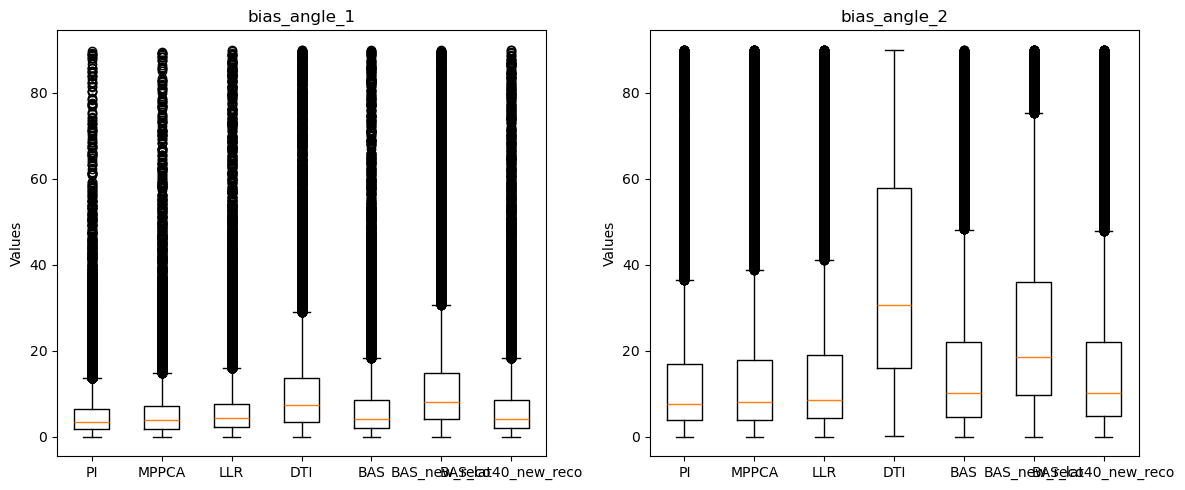

In [ ]:
data = [[bias_angle_1_PI_filtered , bias_angle_1_MPPCA_filtered, bias_angle_1_LLR_filtered , bias_angle_1_DTI_filtered , bias_angle_1_BAS_filtered, bias_angle_1_BAS_new_reco_filtered, bias_angle_1_BAS_split_new_reco_filtered ],
        [bias_angle_2_PI_filtered , bias_angle_2_MPPCA_filtered, bias_angle_2_LLR_filtered , bias_angle_2_DTI_filtered , bias_angle_2_BAS_filtered, bias_angle_2_BAS_new_reco_filtered, bias_angle_2_BAS_split_new_reco_filtered ] ]
# Create 2x2 subplot grid
dataNames = ['bias_angle_1', 'bias_angle_2']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.boxplot(data[i], tick_labels=["PI", "MPPCA", "LLR", "DTI", "BAS", 'BAS_new_reco', 'BAS_lat40_new_reco'])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()


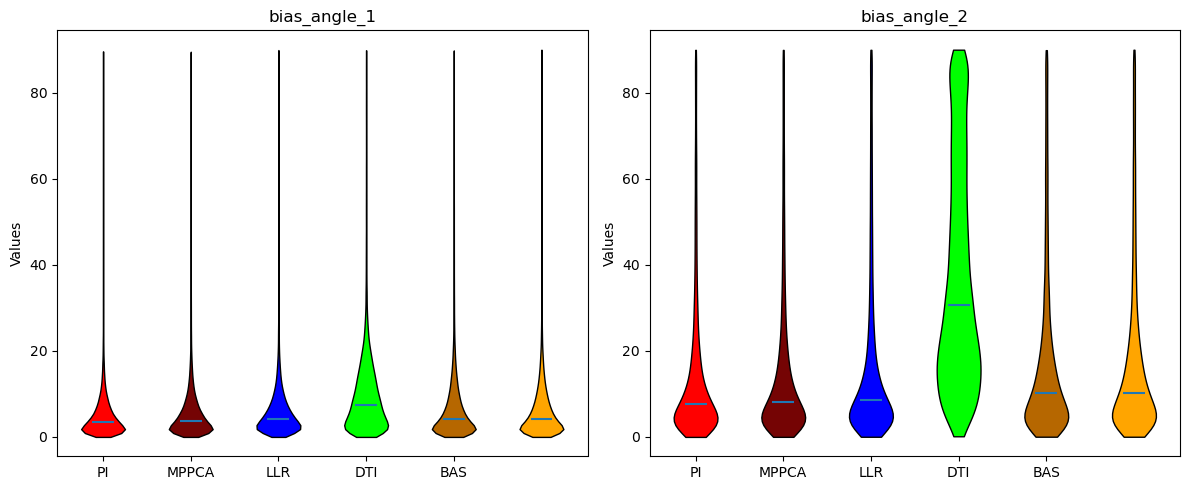

In [200]:
data = [[bias_angle_1_PI_filtered , bias_angle_1_MPPCA_filtered, bias_angle_1_LLR_filtered , bias_angle_1_DTI_filtered , bias_angle_1_BAS_filtered , bias_angle_1_BAS_split_new_reco_filtered ],
        [bias_angle_2_PI_filtered , bias_angle_2_MPPCA_filtered, bias_angle_2_LLR_filtered , bias_angle_2_DTI_filtered , bias_angle_2_BAS_filtered , bias_angle_2_BAS_split_new_reco_filtered] ]
# Create 2x2 subplot grid
dataNames = ['bias_angle_1', 'bias_angle_2']
plot_colors = ["#FF0000", "#750404","#0000FF", "#00FF00", "#B66700", "#FFA500", "#FFD580"]
# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    parts = ax.violinplot(data[i], showmeans=False, showmedians=True, showextrema=False)

    for l, pc in enumerate(parts['bodies']):
        pc.set_facecolor(plot_colors[l])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # quartile1, medians, quartile3 = np.percentile(data[i], [25, 50, 75], axis=1)
    # whiskers = np.array([
    #     adjacent_values(sorted_array, q1, q3)
    #     for sorted_array, q1, q3 in zip(data[i], quartile1, quartile3)])
    # whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    # inds = np.arange(1, len(medians)+1)
    # ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    # ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    # ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    # ax.axhline(7)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xticklabels(["PI", "MPPCA", "LLR", "DTI", "BAS"])
    if i > 1:
        hline = 0
        ax.axhline(hline, color='red', linestyle='--', linewidth=2, label=f"GT value")
    ax.set_title(dataNames[i])
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()

In [201]:
for i in range(2):
    print(f'90th percentile bias for angle {i+1}:')
    for j, method in enumerate(['PI', 'MPPCA', 'LLR', 'DTI', 'BAS']):
        mean_bias = np.percentile(data[i][j], 90)
        print(f'{method}: \t{mean_bias}')

90th percentile bias for angle 1:
PI: 	10.611382080370346
MPPCA: 	11.684932211517374
LLR: 	12.57166590765828
DTI: 	20.21524390673441
BAS: 	14.551081300241911
90th percentile bias for angle 2:
PI: 	37.663497514672
MPPCA: 	40.05490184754764
LLR: 	45.85243501882419
DTI: 	79.1563387813186
BAS: 	47.90277805260181


## Precision

In [202]:

rows = 2
cols = 5
N_diff=126
N_z = 25
N_coil = 32
slice_slider = widgets.IntSlider(min=0, max= N_z-1, step=1)
vmax = 20


@widgets.interact(n_slice = slice_slider)
def interact_plots( n_slice):
    plt.subplots(rows, cols, figsize=(20, 10), dpi=500)
    plt.subplot(rows, cols, 1)
    plt.title('PI Angle 1 95th best')
    plt.imshow(angle_95_1_PI[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 2)
    plt.title('MPPCA Angle 1 95th best')
    plt.imshow(angle_95_1_MPPCA[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 3)
    plt.title('LLR Angle 1 95th best')
    plt.imshow(angle_95_1_LLR[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 4)
    plt.title('BAS Angle 1 95th best')
    plt.imshow(angle_95_1_BAS[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, 5)
    plt.title('DTI Angle 1 95th best')
    im=plt.imshow(angle_95_1_DTI[:,:,n_slice]*mask_1_plus_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.colorbar(im, label="Angle difference in degrees")

    plt.subplot(rows, cols, cols+1)
    plt.title('PI Angle 2 95th best')
    plt.imshow(angle_95_2_PI[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+2)
    plt.title('MPPCA Angle 2 95th best')
    plt.imshow(angle_95_2_MPPCA[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+3)
    plt.title('LLR Angle 2 95th best')
    plt.imshow(angle_95_2_LLR[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+4)
    plt.title('BAS Angle 2 95th best')
    plt.imshow(angle_95_2_BAS[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(rows, cols, cols+5)
    plt.title('DTI Angle 2 95th best')
    im2=plt.imshow(angle_95_2_DTI[:,:,n_slice]*mask_2_fiber_float_all[...,n_slice], vmin=0, vmax=vmax, cmap=cmap)
    plt.axis('off')

    plt.colorbar(im2, label="Angle difference in degrees")


interactive(children=(IntSlider(value=0, description='n_slice', max=24), Output()), _dom_classes=('widget-inte…

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rows = 2
cols = 5
N_z = 25
n_slice = 13
vmax = 20
cmap = 'viridis'

# Example titles & data structures
titles_1 = ['PI Angle 1 prec', 'MPPCA Angle 1 prec', 'LLR Angle 1 prec', 'BAS Angle 1 prec', 'DTI Angle 1 prec', 'BAS new Angle 1 prec']
data_1 = [angle_95_1_PI, angle_95_1_MPPCA, angle_95_1_LLR, angle_95_1_BAS, angle_95_1_DTI]
mask_1 = mask_1_plus_fiber_float_all

titles_2 = ['PI Angle 2 prec', 'MPPCA Angle 2 prec', 'LLR Angle 2 prec', 'BAS Angle 2 prec', 'DTI Angle 2 prec', 'BAS new Angle 2 prec']
data_2 = [angle_95_2_PI, angle_95_2_MPPCA, angle_95_2_LLR, angle_95_2_BAS, angle_95_2_DTI]
mask_2 = mask_2_fiber_float_all

# Combine into a single list for easier looping
all_titles = titles_1 + titles_2
all_data = data_1 + data_2
all_masks = [mask_1]*cols + [mask_2]*cols  # first 5 use mask_1, last 5 use mask_2

# --- Loop over all subplots and save each as its own PDF ---
for i, (title, data, mask) in enumerate(zip(all_titles, all_data, all_masks)):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)  # single subplot per figure
    im = ax.imshow((data* mask)[18:90,14:96, n_slice], vmin=0, vmax=vmax, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')
    
    # Add a colorbar without shrinking the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, label="Angle difference in degrees")
    
    # Save as PDF
    filename = f"{title.replace(' ', '_')}.pdf"
    plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')
    plt.close(fig)

print("✅ Saved all subplots with colorbars as individual PDF files (300 DPI).")


✅ Saved all subplots with colorbars as individual PDF files (300 DPI).


## Analyzing masks

In [110]:
index_f = nib.load(r'C:\msys64\home\glaserjs\bootstrap_analysis_1_fod\0\fixel_masks_all_new\index.nii')
index_data = index_f.get_fdata()
mask_1_plus_fiber_all = (index_data[:,:,0:25,0] > 0).astype(bool)
# mask_1_plus_fiber_all[:,:,0:7] = False
# mask_1_plus_fiber_all[:,:,23:25] = False
# mask_1_plus_fiber_all[0:30, :,:] = False
# mask_1_plus_fiber_all[80::, :,:] = False
# mask_1_plus_fiber_all[:, 0:25,:] = False
# mask_1_plus_fiber_all[:, 75::,:] = False
mask_2_fiber_all = (index_data[:,:,0:25,0] > 1).astype(bool)
mask_2_fiber_all = mask_2_fiber_all*mask_1_plus_fiber_all
# mask_2_fiber_all[:,:,0:10] = False
# mask_2_fiber_all[:,:,13::] = False
# mask_2_fiber_all[0:30, :,:] = False
# mask_2_fiber_all[80::, :,:] = False
# mask_2_fiber_all[:, 0:25,:] = False
# mask_2_fiber_all[:, 75::,:] = False

mask_dir = r'W:\radiologie\mrt-probanden\AG_Laun\Julius_Glaser\Revision_bipolar\fod\Analyzing_masks\All_slices' + os.sep

mask_CC_f = nib.load(mask_dir + r'CorpusCallosum.nii')
CC_all = mask_CC_f.get_fdata().astype(float)
CC_all = CC_all[:,:,0:25]  # Corpus Callosum
CC_all[CC_all==0] = np.nan

crossing_section_f = nib.load(mask_dir + r'CrossingSection.nii')
CS_all = crossing_section_f.get_fdata().astype(float)                         #Crossing section front
CS_all = CS_all[:,:,0:25]
CS_all[CS_all==0] = np.nan
internal_capsule_f = nib.load(mask_dir + r'InternalCapsuleNew.nii')
IC_all = internal_capsule_f.get_fdata().astype(float)                              #IC = Internal Capsule
IC_all = IC_all[:,:,0:25]
IC_all[IC_all==0] = np.nan

mask_1_plus_fiber_float_all = mask_1_plus_fiber_all.copy().astype(float)
mask_2_fiber_float_all = mask_2_fiber_all.copy().astype(float)

mask_1_plus_fiber_float_all[~mask_1_plus_fiber_all] = np.nan
mask_2_fiber_float_all[~mask_2_fiber_all] = np.nan

## All

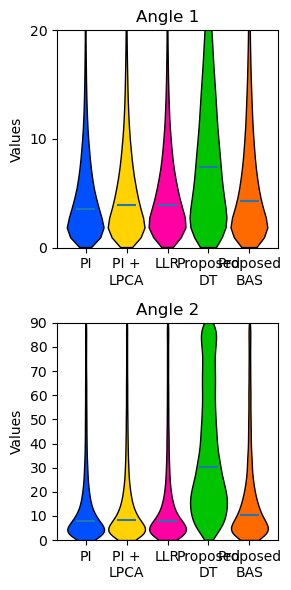

1st quartile, Median, 3rd quartile of angle 1 in All data mask:
PI:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 7
PI +
LPCA:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 7
LLR:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 7
Proposed
DT:		 1st quartile = 3, 	 Median = 7,	 3rd quartile = 13
Proposed
BAS:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 9



1st quartile, Median, 3rd quartile of angle 2 in All data mask:
PI:		 1st quartile = 4, 	 Median = 8,	 3rd quartile = 17
PI +
LPCA:		 1st quartile = 4, 	 Median = 8,	 3rd quartile = 18
LLR:		 1st quartile = 4, 	 Median = 8,	 3rd quartile = 18
Proposed
DT:		 1st quartile = 16, 	 Median = 30,	 3rd quartile = 57
Proposed
BAS:		 1st quartile = 5, 	 Median = 10,	 3rd quartile = 22





In [111]:
bias_data_1 = [bias_angle_1_PI, bias_angle_1_MPPCA, bias_angle_1_LLR , bias_angle_1_DTI, bias_angle_1_BAS]
bias_data_2 = [bias_angle_2_PI , bias_angle_2_MPPCA,bias_angle_2_LLR , bias_angle_2_DTI , bias_angle_2_BAS]
angles1_all, angles2_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, mask_1_plus_fiber_float_all, mask2=mask_2_fiber_float_all)
data = [angles1_all, angles2_all]
dataNames = ['PI', 'PI +\nLPCA', 'LLR', 'Proposed\nDT', 'Proposed\nBAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles,save_dir=r'C:\Workspace\LASER_resub\fig6\All_new',save_fig=True, ylim_max=[20,90])
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('All data mask', dataNames, data)

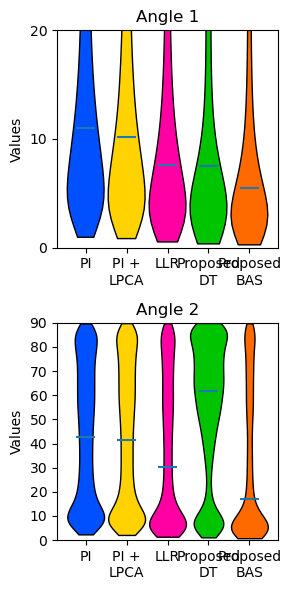

1st quartile, Median, 3rd quartile of angle 1 in All data mask:
PI:		 1st quartile = 6, 	 Median = 11,	 3rd quartile = 23
PI +
LPCA:		 1st quartile = 5, 	 Median = 10,	 3rd quartile = 22
LLR:		 1st quartile = 4, 	 Median = 8,	 3rd quartile = 17
Proposed
DT:		 1st quartile = 3, 	 Median = 8,	 3rd quartile = 26
Proposed
BAS:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 14



1st quartile, Median, 3rd quartile of angle 2 in All data mask:
PI:		 1st quartile = 14, 	 Median = 43,	 3rd quartile = 69
PI +
LPCA:		 1st quartile = 13, 	 Median = 41,	 3rd quartile = 69
LLR:		 1st quartile = 8, 	 Median = 30,	 3rd quartile = 64
Proposed
DT:		 1st quartile = 36, 	 Median = 62,	 3rd quartile = 78
Proposed
BAS:		 1st quartile = 6, 	 Median = 17,	 3rd quartile = 61





In [112]:
prec_data_1 = [angle_95_1_PI, angle_95_1_MPPCA, angle_95_1_LLR , angle_95_1_DTI, angle_95_1_BAS]
prec_data_2 = [angle_95_2_PI, angle_95_2_MPPCA, angle_95_2_LLR , angle_95_2_DTI, angle_95_2_BAS]
angles1_all, angles2_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, mask_1_plus_fiber_float_all, mask2=mask_2_fiber_float_all)
data = [angles1_all, angles2_all]
# dataNames = ['PI', 'MPPCA', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles,save_dir=r'C:\Workspace\LASER_resub\fig6\All_new',save_fig=True, bias_or_prec='prec', ylim_max=[20,90])
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('All data mask', dataNames, data)

## CC

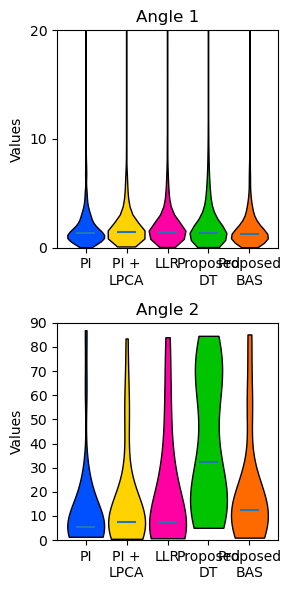

1st quartile, Median, 3rd quartile of angle 1 in CC mask:
PI:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2
PI +
LPCA:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2
LLR:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2
Proposed
DT:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2
Proposed
BAS:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2



1st quartile, Median, 3rd quartile of angle 2 in CC mask:
PI:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 10
PI +
LPCA:		 1st quartile = 5, 	 Median = 8,	 3rd quartile = 15
LLR:		 1st quartile = 3, 	 Median = 7,	 3rd quartile = 27
Proposed
DT:		 1st quartile = 14, 	 Median = 32,	 3rd quartile = 68
Proposed
BAS:		 1st quartile = 5, 	 Median = 12,	 3rd quartile = 22





In [113]:
angles1_CC_all, angles2_CC_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, CC_all, mask2=mask_2_fiber_float_all*CC_all)
data = [angles1_CC_all, angles2_CC_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CC_new',save_fig=True, ylim_max=[20,90])
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('CC mask', dataNames, data)

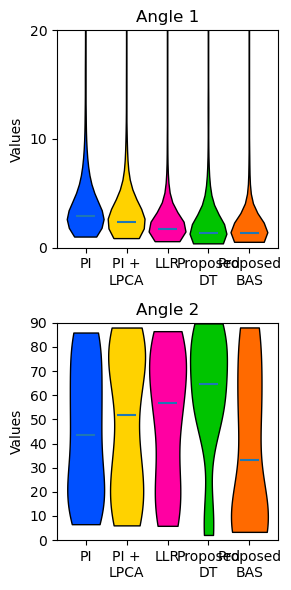

1st quartile, Median, 3rd quartile of angle 1 in CC mask:
PI:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 5
PI +
LPCA:		 1st quartile = 2, 	 Median = 2,	 3rd quartile = 4
LLR:		 1st quartile = 1, 	 Median = 2,	 3rd quartile = 3
Proposed
DT:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2
Proposed
BAS:		 1st quartile = 1, 	 Median = 1,	 3rd quartile = 2



1st quartile, Median, 3rd quartile of angle 2 in CC mask:
PI:		 1st quartile = 16, 	 Median = 43,	 3rd quartile = 72
PI +
LPCA:		 1st quartile = 22, 	 Median = 52,	 3rd quartile = 78
LLR:		 1st quartile = 23, 	 Median = 57,	 3rd quartile = 76
Proposed
DT:		 1st quartile = 54, 	 Median = 65,	 3rd quartile = 82
Proposed
BAS:		 1st quartile = 7, 	 Median = 33,	 3rd quartile = 65





In [114]:
prec1_CC_all, prec2_CC_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, CC_all,mask2=mask_2_fiber_float_all*CC_all)
data = [prec1_CC_all, prec2_CC_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CC_new',save_fig=True, ylim_max=[20,90], bias_or_prec='prec')
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('CC mask', dataNames, data)

## Internal Capsule

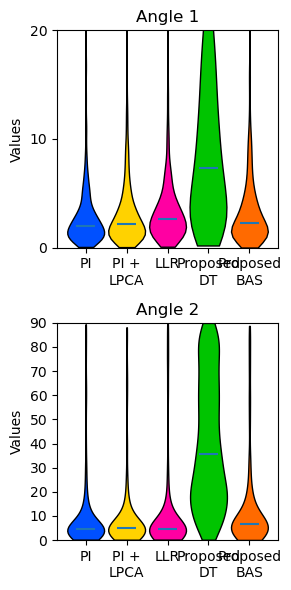

1st quartile, Median, 3rd quartile of angle 1 in IC mask:
PI:		 1st quartile = 1, 	 Median = 2,	 3rd quartile = 3
PI +
LPCA:		 1st quartile = 1, 	 Median = 2,	 3rd quartile = 4
LLR:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 4
Proposed
DT:		 1st quartile = 3, 	 Median = 7,	 3rd quartile = 14
Proposed
BAS:		 1st quartile = 1, 	 Median = 2,	 3rd quartile = 4



1st quartile, Median, 3rd quartile of angle 2 in IC mask:
PI:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 8
PI +
LPCA:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 9
LLR:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 8
Proposed
DT:		 1st quartile = 18, 	 Median = 35,	 3rd quartile = 63
Proposed
BAS:		 1st quartile = 3, 	 Median = 7,	 3rd quartile = 12





In [115]:
angles1_IC_all, angles2_IC_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, IC_all, mask2=mask_2_fiber_float_all*IC_all)
data = [angles1_IC_all, angles2_IC_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CST_new',save_fig=True, ylim_max=[20,90])
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('IC mask', dataNames, data)

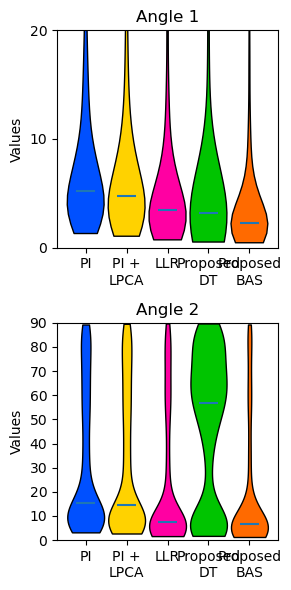

1st quartile, Median, 3rd quartile of angle 1 in IC mask:
PI:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 9
PI +
LPCA:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 8
LLR:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 6
Proposed
DT:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 6
Proposed
BAS:		 1st quartile = 1, 	 Median = 2,	 3rd quartile = 4



1st quartile, Median, 3rd quartile of angle 2 in IC mask:
PI:		 1st quartile = 8, 	 Median = 15,	 3rd quartile = 56
PI +
LPCA:		 1st quartile = 7, 	 Median = 14,	 3rd quartile = 56
LLR:		 1st quartile = 5, 	 Median = 7,	 3rd quartile = 44
Proposed
DT:		 1st quartile = 9, 	 Median = 57,	 3rd quartile = 73
Proposed
BAS:		 1st quartile = 4, 	 Median = 7,	 3rd quartile = 19





In [116]:
prec1_IC_all, prec2_IC_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, IC_all, mask2=mask_2_fiber_float_all*IC_all)
data = [prec1_IC_all, prec2_IC_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CST_new',save_fig=True, ylim_max=[20,90], bias_or_prec='prec')
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('IC mask', dataNames, data)

## Crossing Section

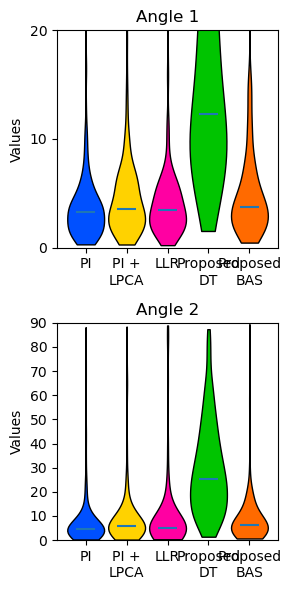

1st quartile, Median, 3rd quartile of angle 1 in CS mask:
PI:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 4
PI +
LPCA:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 6
LLR:		 1st quartile = 2, 	 Median = 3,	 3rd quartile = 5
Proposed
DT:		 1st quartile = 8, 	 Median = 12,	 3rd quartile = 20
Proposed
BAS:		 1st quartile = 2, 	 Median = 4,	 3rd quartile = 7



1st quartile, Median, 3rd quartile of angle 2 in CS mask:
PI:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 7
PI +
LPCA:		 1st quartile = 3, 	 Median = 6,	 3rd quartile = 10
LLR:		 1st quartile = 3, 	 Median = 5,	 3rd quartile = 10
Proposed
DT:		 1st quartile = 16, 	 Median = 25,	 3rd quartile = 41
Proposed
BAS:		 1st quartile = 3, 	 Median = 6,	 3rd quartile = 10





In [117]:
angles1_CS_all, angles2_CS_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, CS_all, mask2=mask_2_fiber_float_all*CS_all)
data = [angles1_CS_all, angles2_CS_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CS_new',save_fig=True, ylim_max=[20,90])
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('CS mask', dataNames, data)

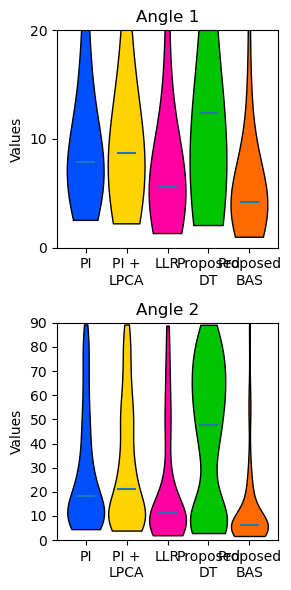

1st quartile, Median, 3rd quartile of angle 1 in CS mask:
PI:		 1st quartile = 6, 	 Median = 8,	 3rd quartile = 13
PI +
LPCA:		 1st quartile = 5, 	 Median = 9,	 3rd quartile = 14
LLR:		 1st quartile = 4, 	 Median = 6,	 3rd quartile = 9
Proposed
DT:		 1st quartile = 6, 	 Median = 12,	 3rd quartile = 38
Proposed
BAS:		 1st quartile = 3, 	 Median = 4,	 3rd quartile = 7



1st quartile, Median, 3rd quartile of angle 2 in CS mask:
PI:		 1st quartile = 9, 	 Median = 18,	 3rd quartile = 39
PI +
LPCA:		 1st quartile = 9, 	 Median = 21,	 3rd quartile = 49
LLR:		 1st quartile = 6, 	 Median = 11,	 3rd quartile = 28
Proposed
DT:		 1st quartile = 9, 	 Median = 48,	 3rd quartile = 68
Proposed
BAS:		 1st quartile = 4, 	 Median = 6,	 3rd quartile = 12





In [118]:
prec1_CS_all, prec2_CS_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, CS_all, mask2=mask_2_fiber_float_all*CS_all)
data = [prec1_CS_all, prec2_CS_all]
# dataNames = ['PI', 'PI2SH', 'MPPCA', 'MPPCA2SH', 'LLR', 'DTI', 'BAS']
dataTitles = ["Angle 1", "Angle 2"]
plot_violins(data, dataNames, dataTitles, save_dir=r'C:\Workspace\LASER_resub\fig6\CS_new',save_fig=True, ylim_max=[20,90], bias_or_prec='prec')
# plot_boxplots(data, dataNames, dataTitles, save_figs=True)
print_stats('CS mask', dataNames, data)

## Scatterplots

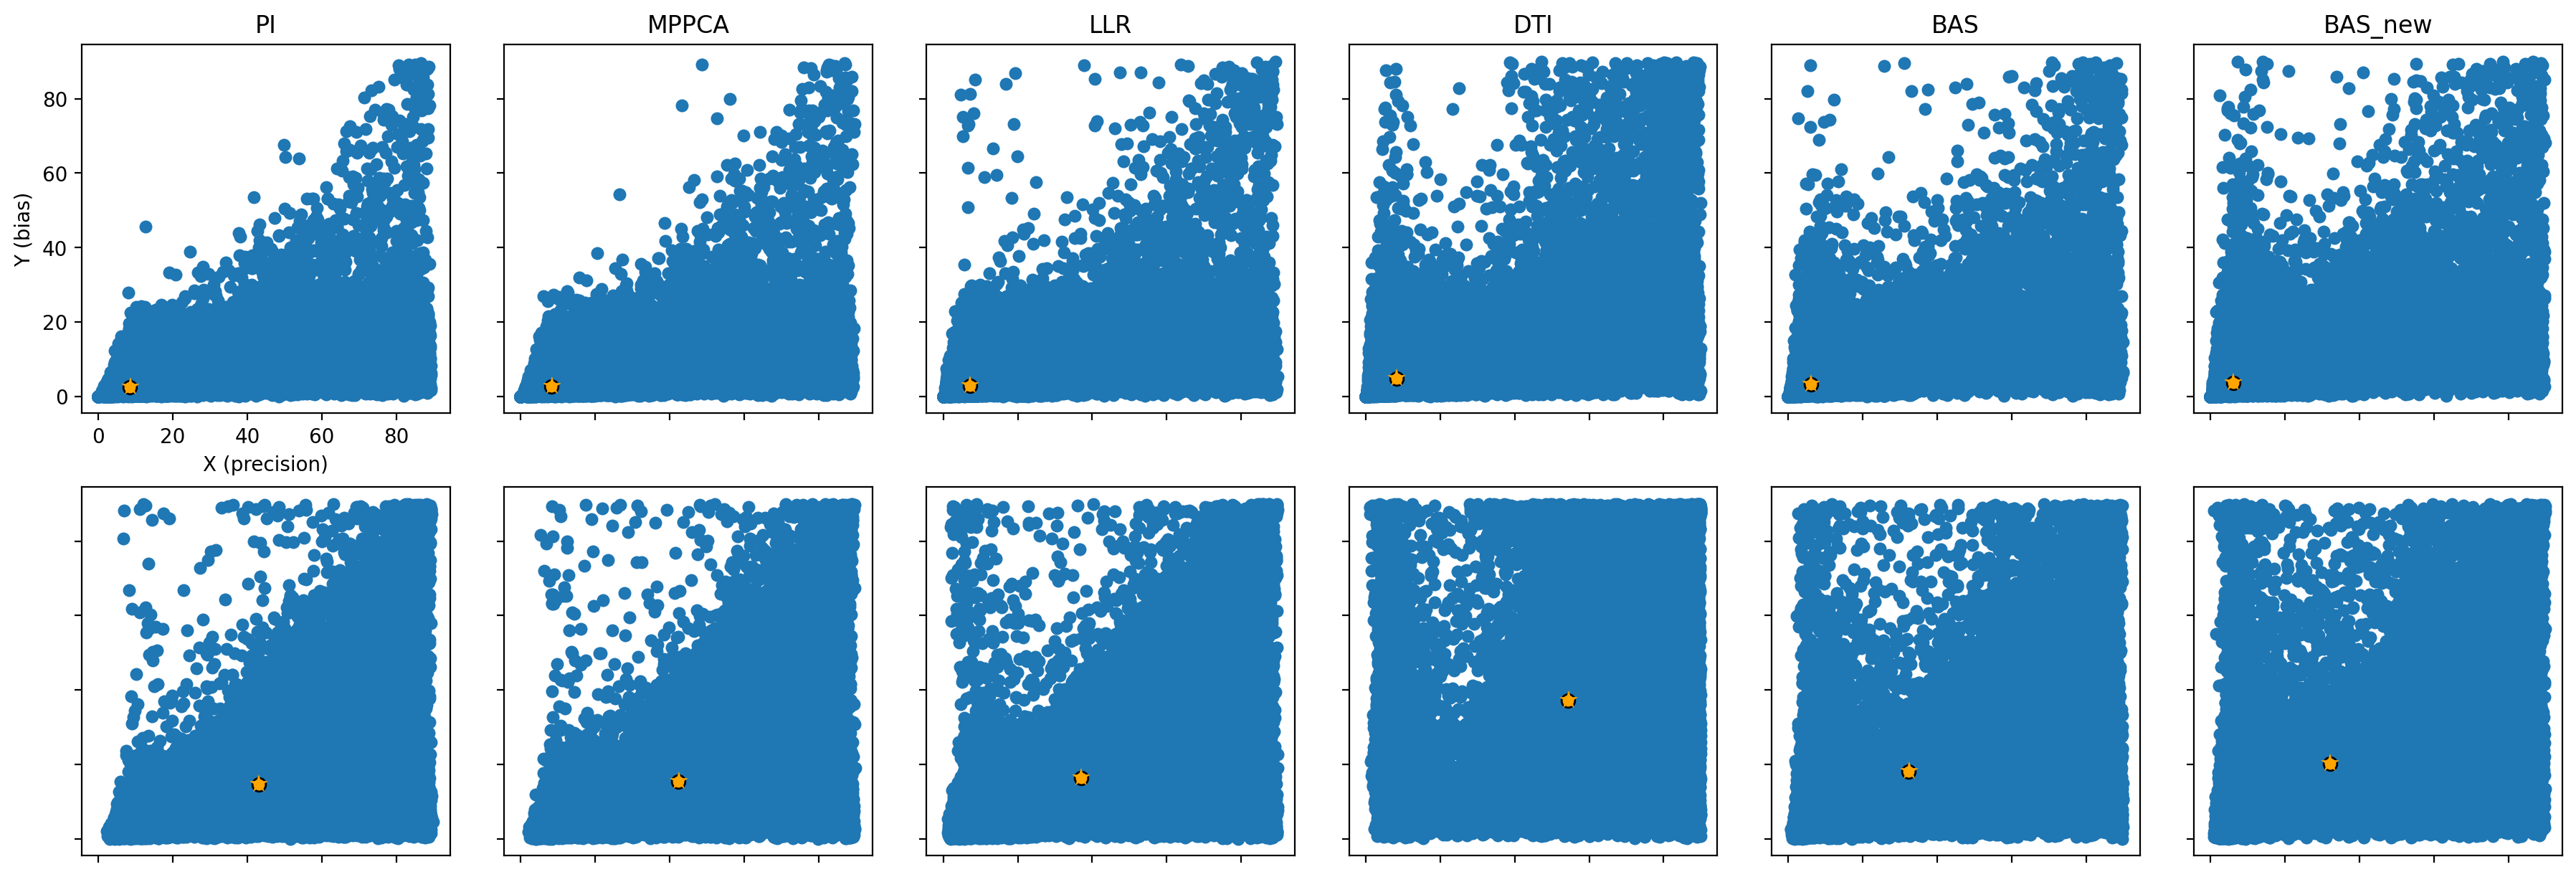

In [26]:
prec1_all, prec2_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, mask_1_plus_fiber_all, mask2=mask_2_fiber_float_all)
bias1_all, bias2_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, mask_1_plus_fiber_all, mask2=mask_2_fiber_float_all)

angles_var1 = bias1_all
angles_var2 = bias2_all
prec_var1 = prec1_all
prec_var2 = prec2_all
# --- settings you can tweak ---
DPI = 200
marker_size = 30
first_row_titles = dataNames  # or supply your own list
# ------------------------------

n = len(angles_var1)
assert n == len(prec_var1) == len(angles_var2) == len(prec_var2), "Mismatched list lengths."

# Compute global axis limits across ALL subplots (both rows)
def _flatten_concat(seq_of_arrays):
    return np.concatenate([np.ravel(a) for a in seq_of_arrays if a is not None and len(a) > 0])

x_all = _flatten_concat(list(prec_var1) + list(prec_var2))
y_all = _flatten_concat(list(angles_var1) + list(angles_var2))

# Handle cases with NaNs
x_all = x_all[~np.isnan(x_all)]
y_all = y_all[~np.isnan(y_all)]

x_min, x_max = (np.min(x_all), np.max(x_all)) if x_all.size else (0.0, 1.0)
y_min, y_max = (np.min(y_all), np.max(y_all)) if y_all.size else (0.0, 1.0)

# Add a small padding
def _pad(lo, hi, frac=0.05):
    span = hi - lo
    if span == 0:
        span = 1.0
    pad = span * frac
    return lo - pad, hi + pad

x_min, x_max = _pad(x_min, x_max)
y_min, y_max = _pad(y_min, y_max)

# Create the figure/grid
fig, axes = plt.subplots(
    2, n, figsize=(n*3, 2*3), dpi=DPI, constrained_layout=True
)

# If n==1, axes comes back as 1D; normalize to 2D indexing
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])

# First row
for i in range(n):
    ax = axes[0, i]
    x = prec_var1[i]
    y = angles_var1[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)
    ax.set_title(first_row_titles[i] if i < len(first_row_titles) else f"Plot {i+1}")



# Second row
for i in range(n):
    ax = axes[1, i]
    x = prec_var2[i]
    y = angles_var2[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)

# Axis labels: only on the first subplot; hide tick labels elsewhere
for r in range(2):
    for c in range(n):
        ax = axes[r, c]
        if r == 0 and c == 0:
            ax.set_xlabel("X (precision)")
            ax.set_ylabel("Y (bias)")
            continue
        ax.tick_params(labelbottom=False, labelleft=False)
        
save_path = "angles_precision_bias_grid.png"  # change if you like
fig.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


## CC

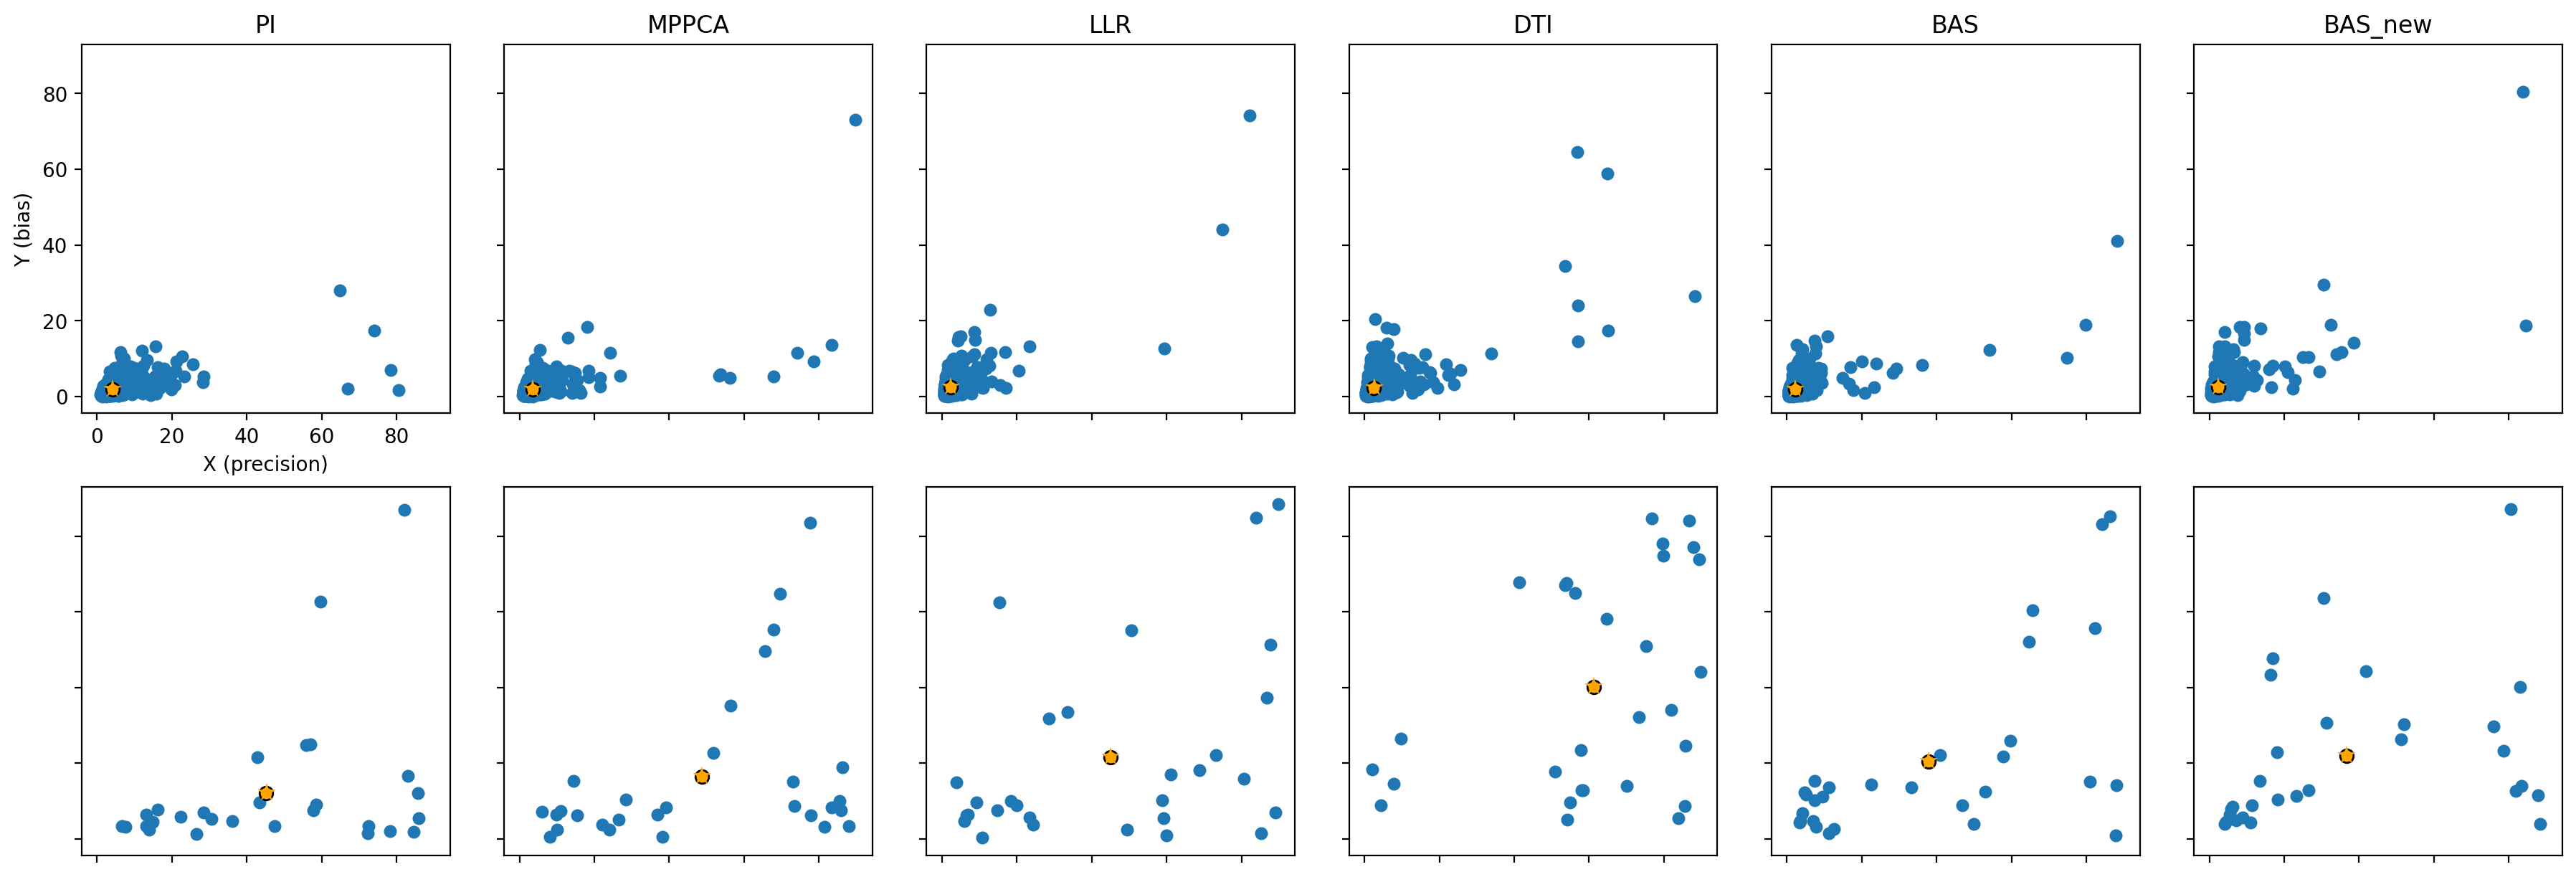

In [27]:
prec1_CC_all, prec2_CC_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, CC_all, mask2=mask_2_fiber_float_all*CC_all)
bias1_CC_all, bias2_CC_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, CC_all, mask2=mask_2_fiber_float_all*CC_all)

angles_var1 = bias1_CC_all
angles_var2 = bias2_CC_all
prec_var1 = prec1_CC_all
prec_var2 = prec2_CC_all
# --- settings you can tweak ---
DPI = 200
marker_size = 30
first_row_titles = dataNames  # or supply your own list
# ------------------------------

n = len(angles_var1)
assert n == len(prec_var1) == len(angles_var2) == len(prec_var2), "Mismatched list lengths."

# Compute global axis limits across ALL subplots (both rows)
def _flatten_concat(seq_of_arrays):
    return np.concatenate([np.ravel(a) for a in seq_of_arrays if a is not None and len(a) > 0])

x_all = _flatten_concat(list(prec_var1) + list(prec_var2))
y_all = _flatten_concat(list(angles_var1) + list(angles_var2))

# Handle cases with NaNs
x_all = x_all[~np.isnan(x_all)]
y_all = y_all[~np.isnan(y_all)]

x_min, x_max = (np.min(x_all), np.max(x_all)) if x_all.size else (0.0, 1.0)
y_min, y_max = (np.min(y_all), np.max(y_all)) if y_all.size else (0.0, 1.0)

# Add a small padding
def _pad(lo, hi, frac=0.05):
    span = hi - lo
    if span == 0:
        span = 1.0
    pad = span * frac
    return lo - pad, hi + pad

x_min, x_max = _pad(x_min, x_max)
y_min, y_max = _pad(y_min, y_max)

# Create the figure/grid
fig, axes = plt.subplots(
    2, n, figsize=(n*3, 2*3), dpi=DPI, constrained_layout=True
)

# If n==1, axes comes back as 1D; normalize to 2D indexing
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])

# First row
for i in range(n):
    ax = axes[0, i]
    x = prec_var1[i]
    y = angles_var1[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)
    ax.set_title(first_row_titles[i] if i < len(first_row_titles) else f"Plot {i+1}")



# Second row
for i in range(n):
    ax = axes[1, i]
    x = prec_var2[i]
    y = angles_var2[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)

# Axis labels: only on the first subplot; hide tick labels elsewhere
for r in range(2):
    for c in range(n):
        ax = axes[r, c]
        if r == 0 and c == 0:
            ax.set_xlabel("X (precision)")
            ax.set_ylabel("Y (bias)")
            continue
        ax.tick_params(labelbottom=False, labelleft=False)

save_path = "angles_precision_bias_grid.png"  # change if you like
fig.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


## IC

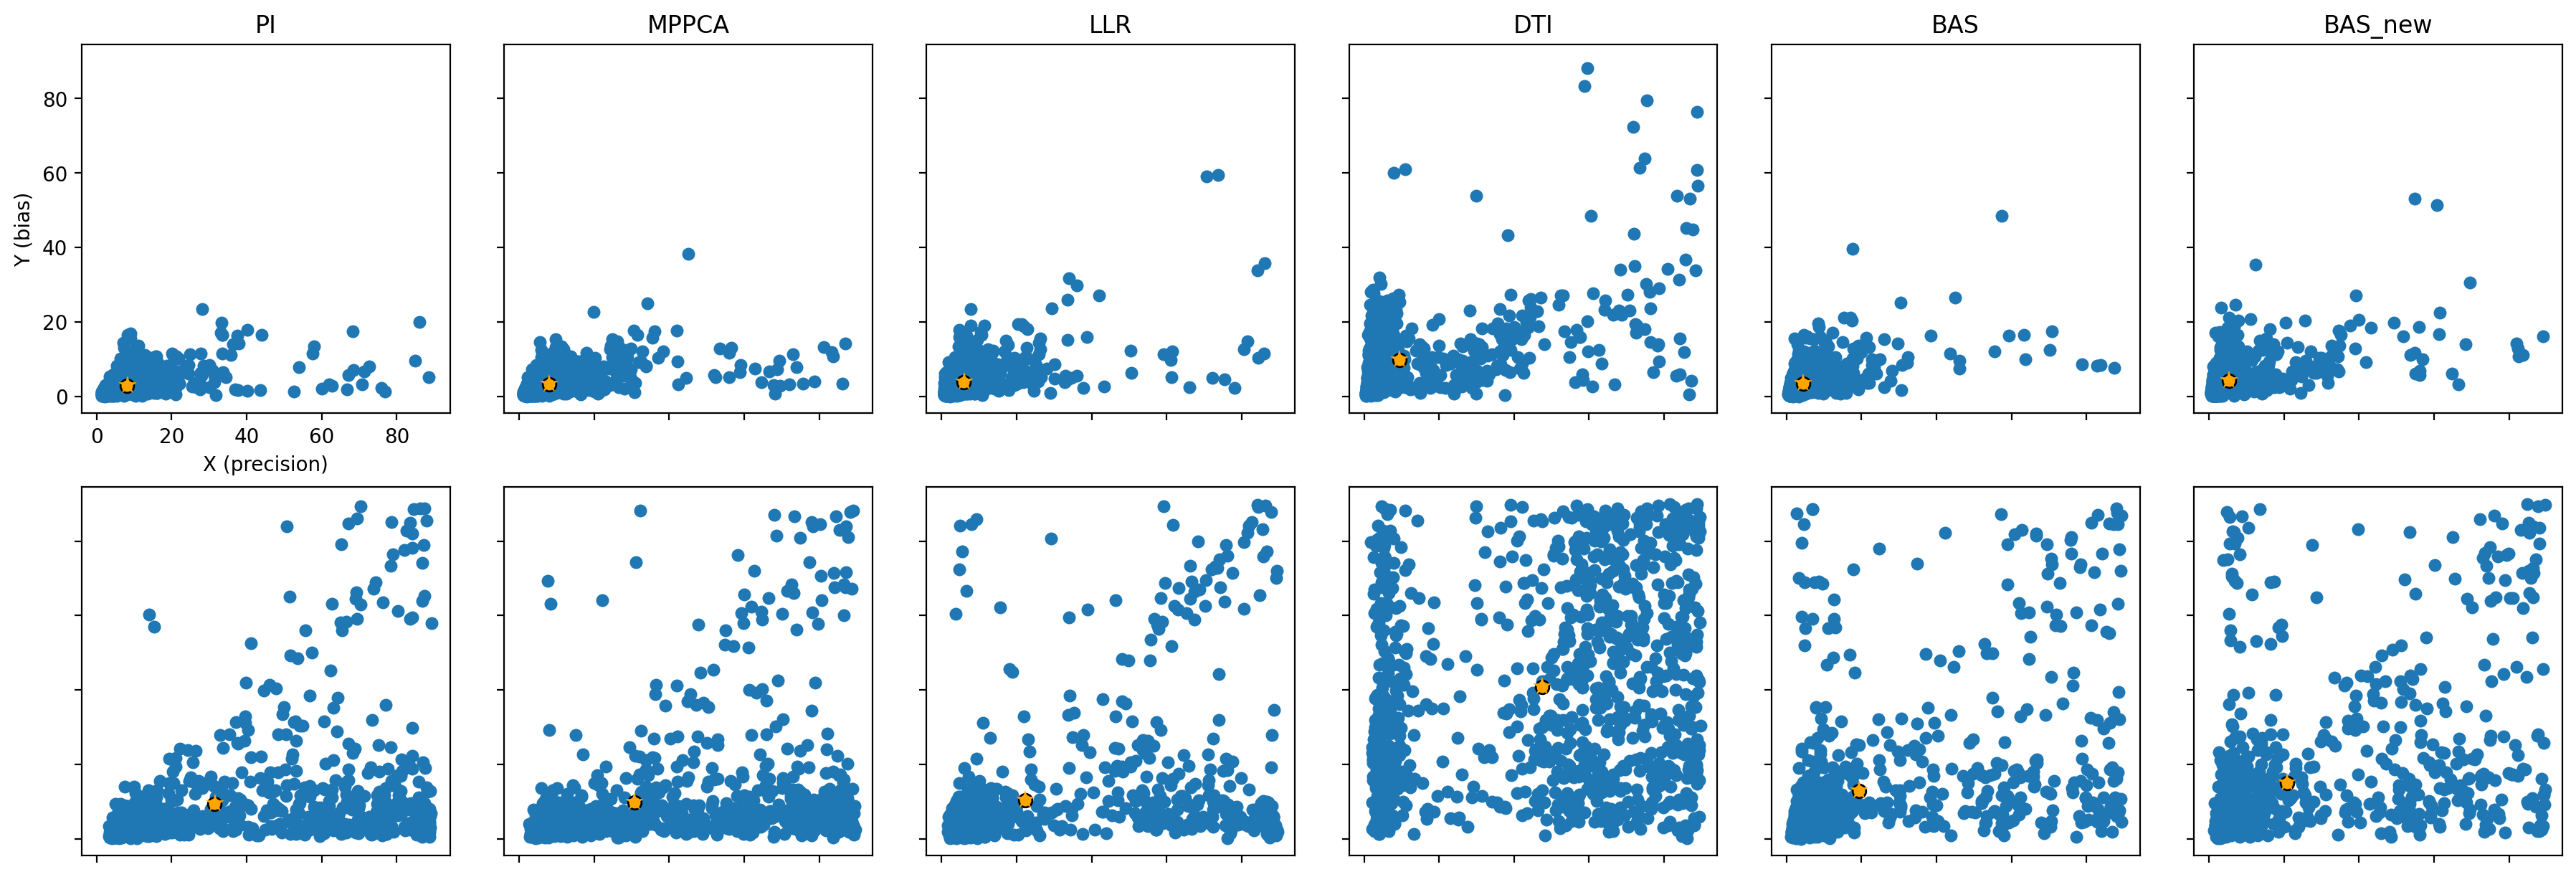

In [28]:
prec1_IC_all, prec2_IC_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, IC_all, mask2=mask_2_fiber_float_all*IC_all)
bias1_IC_all, bias2_IC_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, IC_all, mask2=mask_2_fiber_float_all*IC_all)

angles_var1 = bias1_IC_all
angles_var2 = bias2_IC_all
prec_var1 = prec1_IC_all
prec_var2 = prec2_IC_all
# --- settings you can tweak ---
DPI = 200
marker_size = 30
first_row_titles = dataNames  # or supply your own list
# ------------------------------

n = len(angles_var1)
assert n == len(prec_var1) == len(angles_var2) == len(prec_var2), "Mismatched list lengths."

# Compute global axis limits across ALL subplots (both rows)
def _flatten_concat(seq_of_arrays):
    return np.concatenate([np.ravel(a) for a in seq_of_arrays if a is not None and len(a) > 0])

x_all = _flatten_concat(list(prec_var1) + list(prec_var2))
y_all = _flatten_concat(list(angles_var1) + list(angles_var2))

# Handle cases with NaNs
x_all = x_all[~np.isnan(x_all)]
y_all = y_all[~np.isnan(y_all)]

x_min, x_max = (np.min(x_all), np.max(x_all)) if x_all.size else (0.0, 1.0)
y_min, y_max = (np.min(y_all), np.max(y_all)) if y_all.size else (0.0, 1.0)

# Add a small padding
def _pad(lo, hi, frac=0.05):
    span = hi - lo
    if span == 0:
        span = 1.0
    pad = span * frac
    return lo - pad, hi + pad

x_min, x_max = _pad(x_min, x_max)
y_min, y_max = _pad(y_min, y_max)

# Create the figure/grid
fig, axes = plt.subplots(
    2, n, figsize=(n*3, 2*3), dpi=DPI, constrained_layout=True
)

# If n==1, axes comes back as 1D; normalize to 2D indexing
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])

# First row
for i in range(n):
    ax = axes[0, i]
    x = prec_var1[i]
    y = angles_var1[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)
    ax.set_title(first_row_titles[i] if i < len(first_row_titles) else f"Plot {i+1}")



# Second row
for i in range(n):
    ax = axes[1, i]
    x = prec_var2[i]
    y = angles_var2[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)

# Axis labels: only on the first subplot; hide tick labels elsewhere
for r in range(2):
    for c in range(n):
        ax = axes[r, c]
        if r == 0 and c == 0:
            ax.set_xlabel("X (precision)")
            ax.set_ylabel("Y (bias)")
            continue
        ax.tick_params(labelbottom=False, labelleft=False)

save_path = "angles_precision_bias_grid.png"  # change if you like
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


## CS

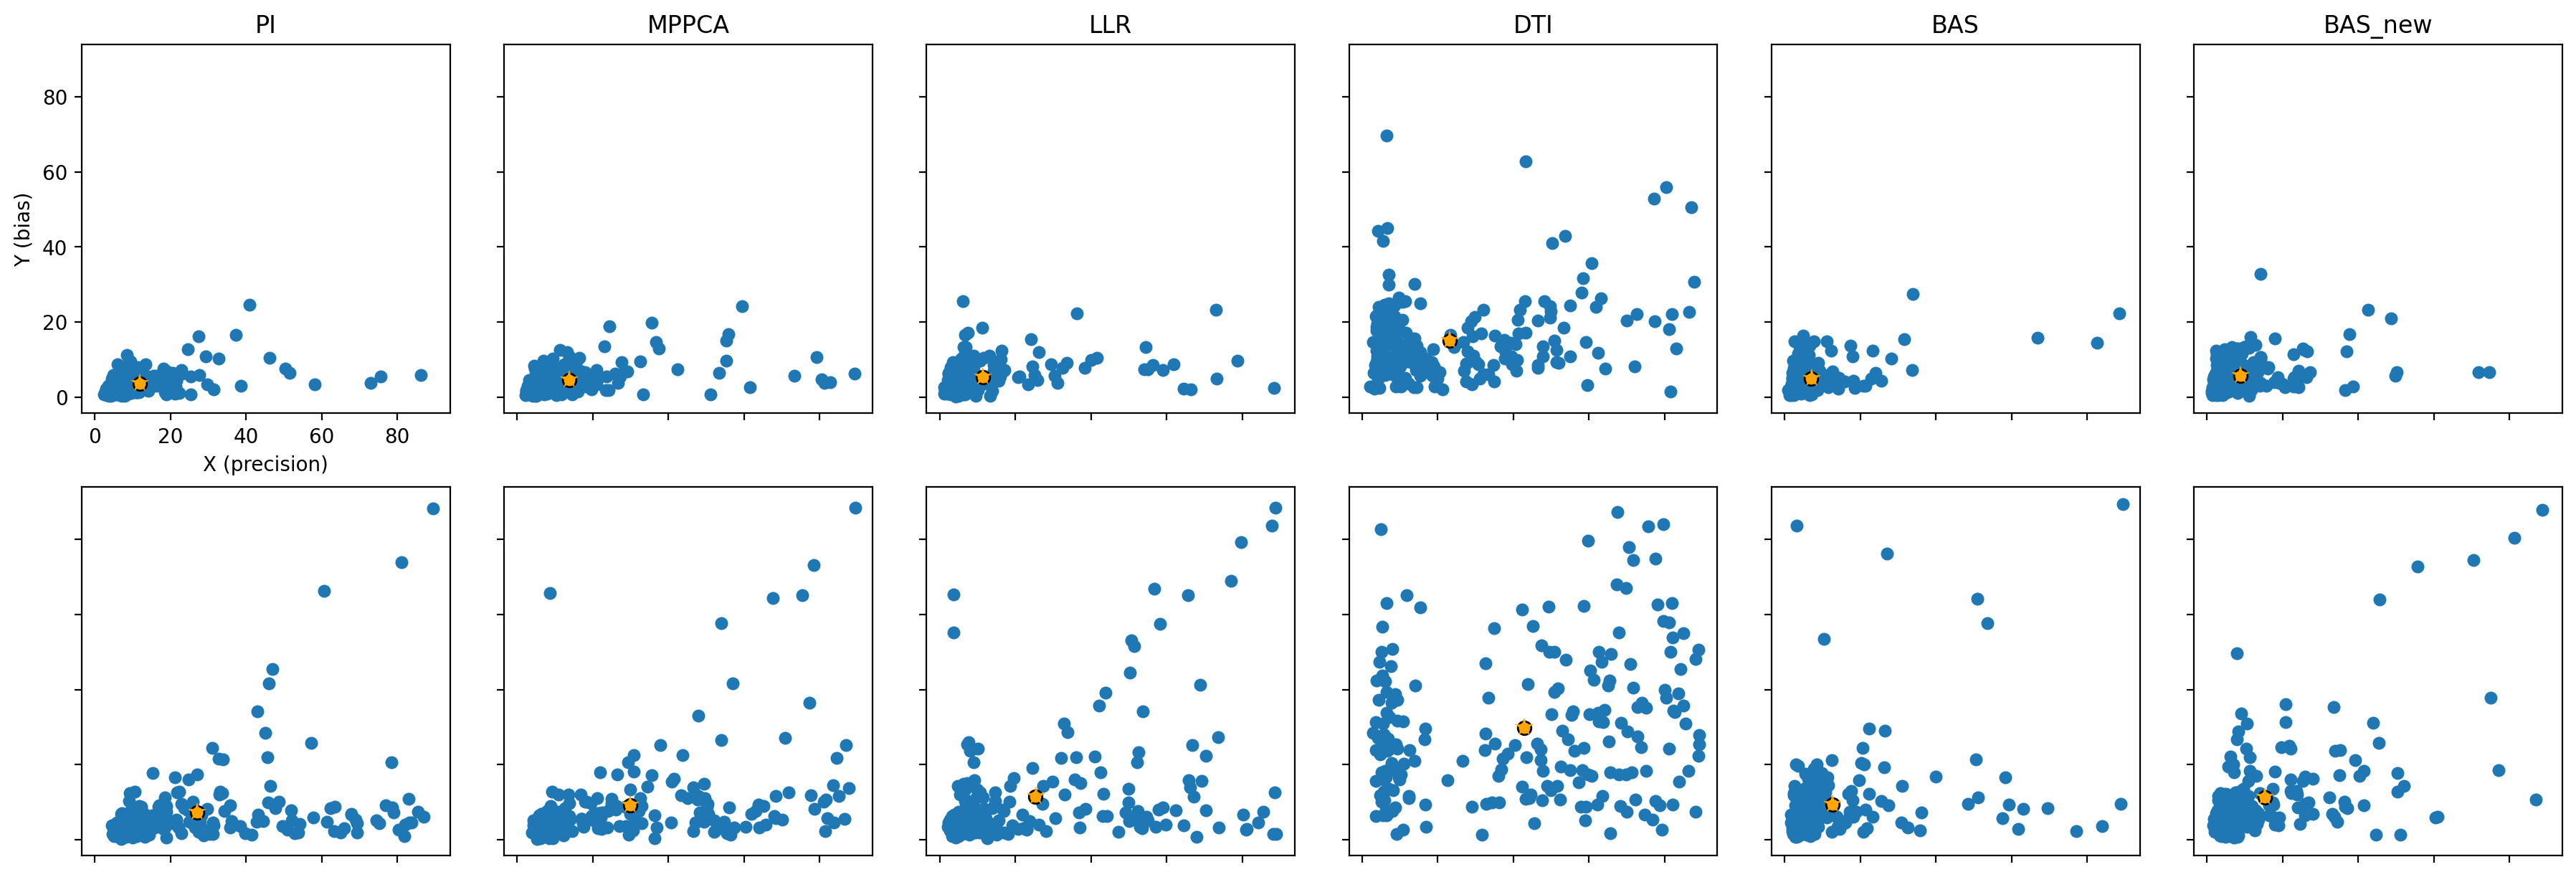

In [29]:
prec1_CS_all, prec2_CS_all = run_statistics_on_angles_masked_data(prec_data_1, prec_data_2, CS_all, mask2=mask_2_fiber_float_all*CS_all)
bias1_CS_all, bias2_CS_all = run_statistics_on_angles_masked_data(bias_data_1, bias_data_2, CS_all, mask2=mask_2_fiber_float_all*CS_all)

angles_var1 = bias1_CS_all
angles_var2 = bias2_CS_all
prec_var1 = prec1_CS_all
prec_var2 = prec2_CS_all
# --- settings you can tweak ---
DPI = 200
marker_size = 30
first_row_titles = dataNames  # or supply your own list
# ------------------------------

n = len(angles_var1)
assert n == len(prec_var1) == len(angles_var2) == len(prec_var2), "Mismatched list lengths."

# Compute global axis limits across ALL subplots (both rows)
def _flatten_concat(seq_of_arrays):
    return np.concatenate([np.ravel(a) for a in seq_of_arrays if a is not None and len(a) > 0])

x_all = _flatten_concat(list(prec_var1) + list(prec_var2))
y_all = _flatten_concat(list(angles_var1) + list(angles_var2))

# Handle cases with NaNs
x_all = x_all[~np.isnan(x_all)]
y_all = y_all[~np.isnan(y_all)]

x_min, x_max = (np.min(x_all), np.max(x_all)) if x_all.size else (0.0, 1.0)
y_min, y_max = (np.min(y_all), np.max(y_all)) if y_all.size else (0.0, 1.0)

# Add a small padding
def _pad(lo, hi, frac=0.05):
    span = hi - lo
    if span == 0:
        span = 1.0
    pad = span * frac
    return lo - pad, hi + pad

x_min, x_max = _pad(x_min, x_max)
y_min, y_max = _pad(y_min, y_max)

# Create the figure/grid
fig, axes = plt.subplots(
    2, n, figsize=(n*3, 2*3), dpi=DPI, constrained_layout=True
)

# If n==1, axes comes back as 1D; normalize to 2D indexing
if n == 1:
    axes = np.array([[axes[0]], [axes[1]]])

# First row
for i in range(n):
    ax = axes[0, i]
    x = prec_var1[i]
    y = angles_var1[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)
    ax.set_title(first_row_titles[i] if i < len(first_row_titles) else f"Plot {i+1}")



# Second row
for i in range(n):
    ax = axes[1, i]
    x = prec_var2[i]
    y = angles_var2[i]
    ax.scatter(x, y, s=marker_size)
    
    # <<< ADDED >>>
    if len(x) > 0 and len(y) > 0:
        x_mean = np.nanmean(x)
        y_mean = np.nanmean(y)
        ax.scatter(x_mean, y_mean, color='orange', s=marker_size*1.5, edgecolor='black', zorder=3)
        ax.text(x_mean, y_mean, '★', color='orange', ha='center', va='center', fontsize=12, zorder=4)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_box_aspect(1)

# Axis labels: only on the first subplot; hide tick labels elsewhere
for r in range(2):
    for c in range(n):
        ax = axes[r, c]
        if r == 0 and c == 0:
            ax.set_xlabel("X (precision)")
            ax.set_ylabel("Y (bias)")
            continue
        ax.tick_params(labelbottom=False, labelleft=False)

save_path = "angles_precision_bias_grid_CS.png"  # change if you like
fig.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
